# Model

## Moving Avg

In [ ]:
!pip install hydroeval


Overall NSE across all years: 0.7342
Overall R² across all years: 0.7741
    Year      RMSE      NMSE        R²       NSE
0   2005  0.379072  0.171837  0.828163  0.815103
1   2006  0.361831  0.129849  0.870151  0.822332
2   2007  0.358678  0.120038  0.879962  0.833843
3   2008  0.645005  0.294345  0.705655  0.483081
4   2009  0.384412  0.125641  0.874359  0.838085
5   2010  0.358943  0.125834  0.874166  0.864610
6   2011  0.459840  0.196884  0.803116  0.787551
7   2012  0.476383  0.291446  0.708554  0.772612
8   2013  0.464796  0.194398  0.805602  0.769580
9   2014  0.407491  0.157778  0.842222  0.816985
10  2015  0.465397  0.181867  0.818133  0.756329
11  2016  0.586415  0.424844  0.575156  0.626676
12  2017  0.504852  0.247182  0.752818  0.699084
13  2018  0.442816  0.182347  0.817653  0.780667
14  2019  0.439214  0.225171  0.774829  0.784480
15  2020  0.928245  0.616215  0.383785  0.008460
16  2021  0.434938  0.219468  0.780532  0.769913
17  2022  0.503620  0.346283  0.653717  0.70

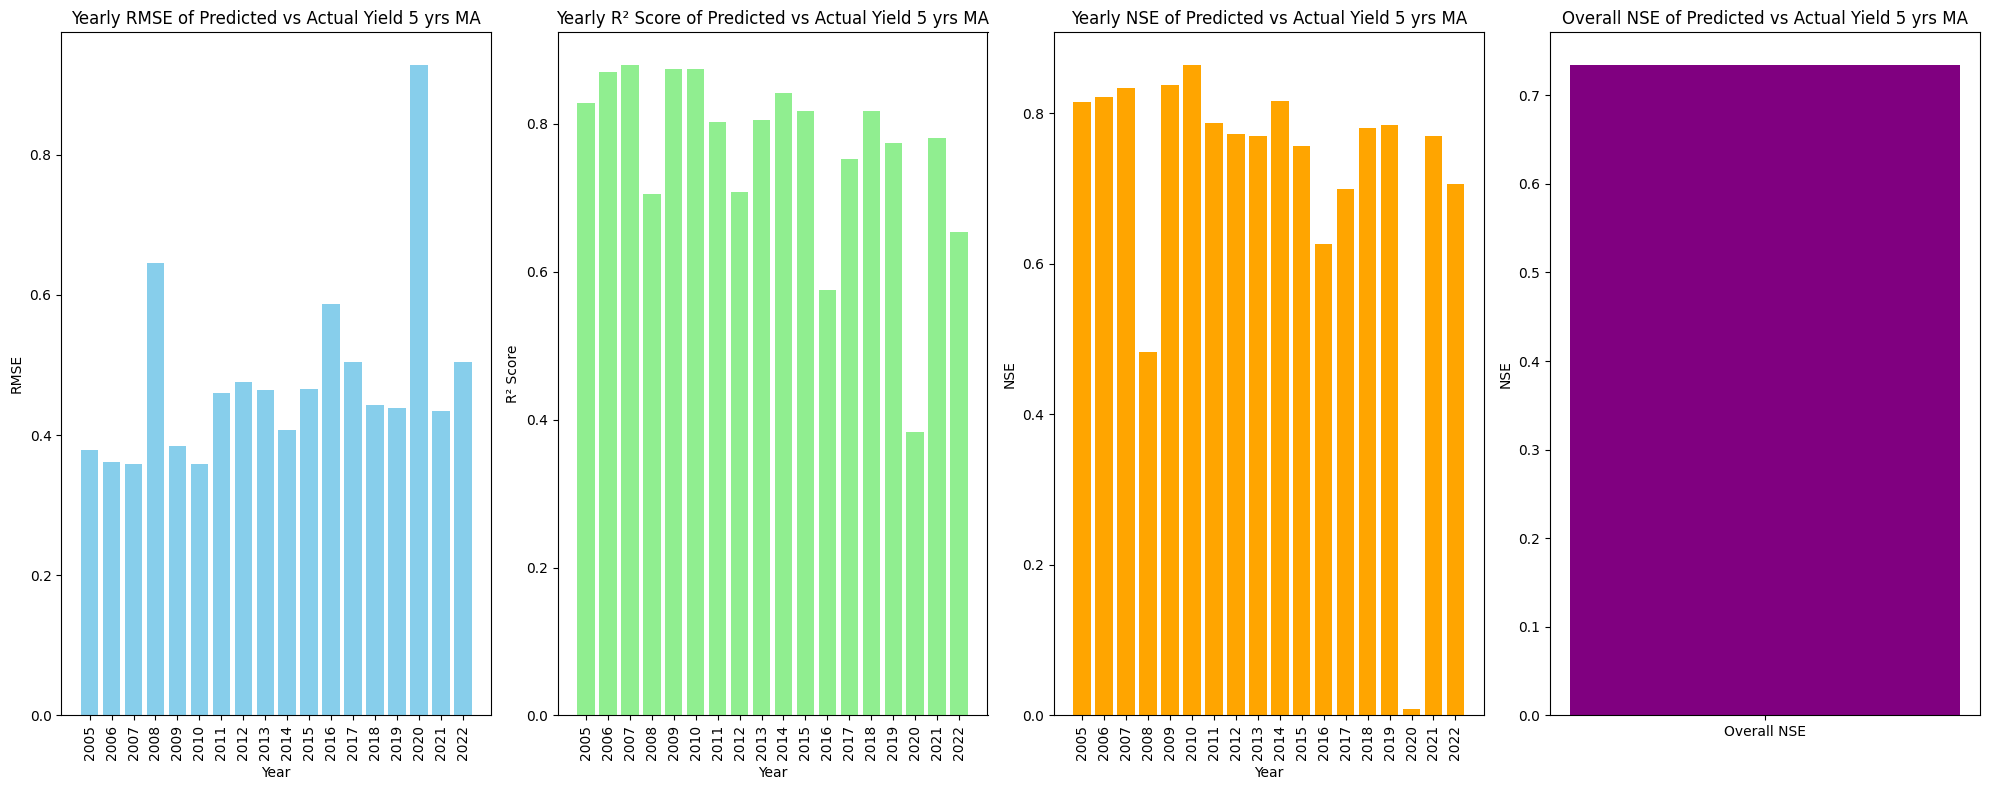

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import hydroeval as he

# Load dataset
df = pd.read_csv('/content/detrended_rice_district_yield_sens_slope.csv')

# Initialize lists to store yearly results and overall actual/predicted values
years = []
rmse_list = []
nmse_list = []
r2_list = []
nse_list = []  # List to store yearly NSE values
records = []
# Lists to collect all actual and predicted values across all years
all_actual_yield = []
all_predicted_yield = []

# Sort by District and Year to ensure correct rolling operations
df = df.sort_values(by=['District', 'Year'])

# Iterate over years starting from 2000 (since we're using a 5-year moving average)
for year in range(2005, 2023):
    window_data = df[(df['Year'] >= year - 5) & (df['Year'] < year)]
    if window_data.groupby('District')['Detrended_Yield'].count().min() < 5:
        print(f"Warning: Insufficient data for year {year}. Skipping.")
        continue
    moving_avg = df[(df['Year'] >= year - 5) & (df['Year'] < year)].groupby('District')['Detrended_Yield'].mean()

    # Get the actual yield for the comparison year (e.g., actual yield of 2000)
    actual_yield = df[df['Year'] == year].set_index('District')['Actual']

    # Get the corresponding trend for the comparison year (for the same districts)
    trend = df[df['Year'] == year].set_index('District')['Trend']

    # Align the indices to ensure correct comparison
    common_districts = actual_yield.index.intersection(moving_avg.index)
    actual_yield = actual_yield.loc[common_districts]
    moving_avg = moving_avg.loc[common_districts]
    trend = trend.loc[common_districts]

    # Add the trend back to the moving average to get the predicted yield
    predicted_yield = moving_avg + trend

    for district in common_districts:
        records.append({
            'Year': year,
            'District': district,
            'Actual_Yield': actual_yield[district],
            'Predicted_Yield': predicted_yield[district]
        })

    # Append to overall lists for NSE and R² across all years
    all_actual_yield.extend(actual_yield.values)
    all_predicted_yield.extend(predicted_yield.values)

    # Calculate RMSE and NMSE for the year
    mse = mean_squared_error(actual_yield, predicted_yield)
    rmse = np.sqrt(mse)
    nmse = mse / np.var(actual_yield)  # Normalized MSE

    rmse_list.append(rmse)
    nmse_list.append(nmse)

    # Calculate R-squared for the year
    r2 = r2_score(actual_yield, predicted_yield)
    r2_list.append(r2)

    # Calculate NSE using hydroeval
    nse = he.evaluator(he.nse, actual_yield.values, predicted_yield.values)[0]  # Extract NSE from the tuple
    nse_list.append(nse)

    # Store the year
    years.append(year)

# Calculate overall NSE and R² for all years at once using the aggregated lists
overall_nse = he.evaluator(he.nse, np.array(all_actual_yield), np.array(all_predicted_yield))[0]  # Extract NSE
overall_r2 = r2_score(all_actual_yield, all_predicted_yield)

print(f"\nOverall NSE across all years: {overall_nse:.4f}")
print(f"Overall R² across all years: {overall_r2:.4f}")

# Create a summary DataFrame for the overall results
results = pd.DataFrame({
    'Year': years,
    'RMSE': rmse_list,
    'NMSE': nmse_list,
    'R²': r2_list,
    'NSE': nse_list  # Added NSE column
})

# Print the results for all years
print(results)
# Create the DataFrame
yield_df = pd.DataFrame(records)

# Save to CSV
yield_df.to_csv('/content/actual_vs_predicted_yield_by_district.csv', index=False)

# Calculate average metrics across all years
average_rmse = np.mean(rmse_list)
average_nmse = np.mean(nmse_list)
average_r2 = np.mean(r2_list)
average_nse = np.mean(nse_list)  # Calculate average NSE

print(f"\nAverage RMSE across all years: {average_rmse:.4f}")
print(f"Average NMSE across all years: {average_nmse:.4f}")
print(f"Average R² across all years: {average_r2:.4f}")
print(f"Average NSE across all years: {average_nse:.4f}")  # Print average NSE

# Plot RMSE, NMSE, R², and NSE scores as bar graphs
plt.figure(figsize=(20, 8))

# RMSE Bar Plot
plt.subplot(1, 4, 1)
plt.bar(results['Year'], results['RMSE'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('Yearly RMSE of Predicted vs Actual Yield 5 yrs MA')
plt.xticks(results['Year'], rotation=90)

# R² Score Bar Plot
plt.subplot(1, 4, 2)
plt.bar(results['Year'], results['R²'], color='lightgreen')
plt.xlabel('Year')
plt.ylabel('R² Score')
plt.title('Yearly R² Score of Predicted vs Actual Yield 5 yrs MA')
plt.xticks(results['Year'], rotation=90)

# NSE Score Bar Plot
plt.subplot(1, 4, 3)
plt.bar(results['Year'], results['NSE'], color='orange')
plt.xlabel('Year')
plt.ylabel('NSE')
plt.title('Yearly NSE of Predicted vs Actual Yield 5 yrs MA')
plt.xticks(results['Year'], rotation=90)

# Overall NSE Plot
plt.subplot(1, 4, 4)
plt.bar(['Overall NSE'], [overall_nse], color='purple')
plt.ylabel('NSE')
plt.title('Overall NSE of Predicted vs Actual Yield 5 yrs MA')

plt.tight_layout()
plt.show()


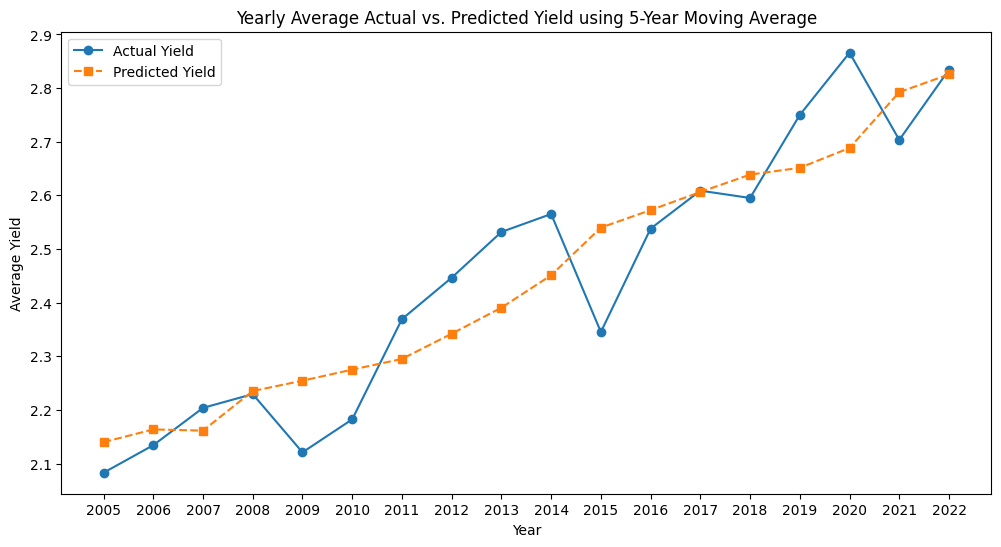

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the results file
results_df = pd.read_csv('/content/actual_vs_predicted_yield_by_district.csv')

# Group by year and compute mean actual and predicted yields
yearly_avg_yield = results_df.groupby('Year')[['Actual_Yield', 'Predicted_Yield']].mean().reset_index()

# Plot the actual vs predicted yield over the years
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_yield['Year'], yearly_avg_yield['Actual_Yield'], marker='o', linestyle='-', label='Actual Yield')
plt.plot(yearly_avg_yield['Year'], yearly_avg_yield['Predicted_Yield'], marker='s', linestyle='--', label='Predicted Yield')

# Formatting the plot
plt.xlabel('Year')
plt.ylabel('Average Yield')
plt.title('Yearly Average Actual vs. Predicted Yield using 5-Year Moving Average')
plt.legend()
plt.xticks(yearly_avg_yield['Year'])  # Ensure all years appear as ticks
plt.show()


## Decision Tree

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint

# Set seed for reproducibility
np.random.seed(8)

# Load Dataset
df = pd.read_csv("/content/cp_rs_centroid_sowing_month_2000.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=10):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeRegressor(random_state=8))
])

# Define Hyperparameter Search Space
param_dist = {
    'dt__max_depth': randint(1, 30),            # Depth of tree
    'dt__min_samples_split': randint(2, 50),    # Min samples to split node
    'dt__min_samples_leaf': randint(1, 20),     # Min samples per leaf
}

# Initialize GroupKFold
n_splits = 10
group_kfold = GroupKFold(n_splits=n_splits)

# Perform Hyperparameter Tuning using a Full Training Dataset
full_X, full_y = features, target
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=10, cv=group_kfold, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=8, verbose=1
)
search.fit(full_X, full_y, groups=groups)

# Extract Best Parameters
best_params = search.best_params_
print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeRegressor(
        random_state=8,
        max_depth=best_params['dt__max_depth'],
        min_samples_split=best_params['dt__min_samples_split'],
        min_samples_leaf=best_params['dt__min_samples_leaf']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")

# Save Predictions to CSV
df.to_csv("decision_tree_predictions.csv", index=False)


Fitting 10 folds for each of 10 candidates, totalling 100 fits

=== Best Hyperparameters Found ===
{'dt__max_depth': 10, 'dt__min_samples_leaf': 16, 'dt__min_samples_split': 31}

=== Fold 1 ===
Training Years: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2000), np.int64(2001), np.int64(2002)]
Train RMSE: 0.44, Train R²: 0.82
Test RMSE: 0.58, Test R²: 0.65

=== Fold 2 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.i

<ipython-input-16-9fea0b8efd04>:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


In [ ]:
from sklearn.inspection import permutation_importance

# Compute Permutation Feature Importance
pfi_results = permutation_importance(
    best_model, full_X, full_y, scoring='neg_mean_squared_error', n_repeats=10, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': full_X.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("permutation_feature_importance.csv", index=False)

# Print Results
print("\n=== Permutation Feature Importance ===")
print(feature_importance_df)



=== Permutation Feature Importance ===
               Feature  Importance   Std_Dev
0    Centroid Latitude    0.732237  0.014327
1   Centroid Longitude    0.583384  0.009480
8                rad_3    0.188878  0.010144
15                rh_2    0.135294  0.003174
28              tmin_3    0.100885  0.004720
35                ws_2    0.093195  0.004545
36                ws_3    0.065768  0.004657
51              ndvi_2    0.055528  0.005874
3                pet_2    0.041660  0.002830
45             gosif_4    0.034942  0.001920
46               lai_1    0.028895  0.002426
19             smtop_2    0.027720  0.001802
21             smtop_4    0.021011  0.001336
6                rad_1    0.014818  0.000912
49               lai_4    0.009875  0.001474
30               vpd_1    0.009715  0.000950
14                rh_1    0.009574  0.000800
37                ws_4    0.009248  0.001180
22              tmax_1    0.008216  0.001236
54                Year    0.006773  0.000460
48             

<ipython-input-18-c1a6fab90508>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


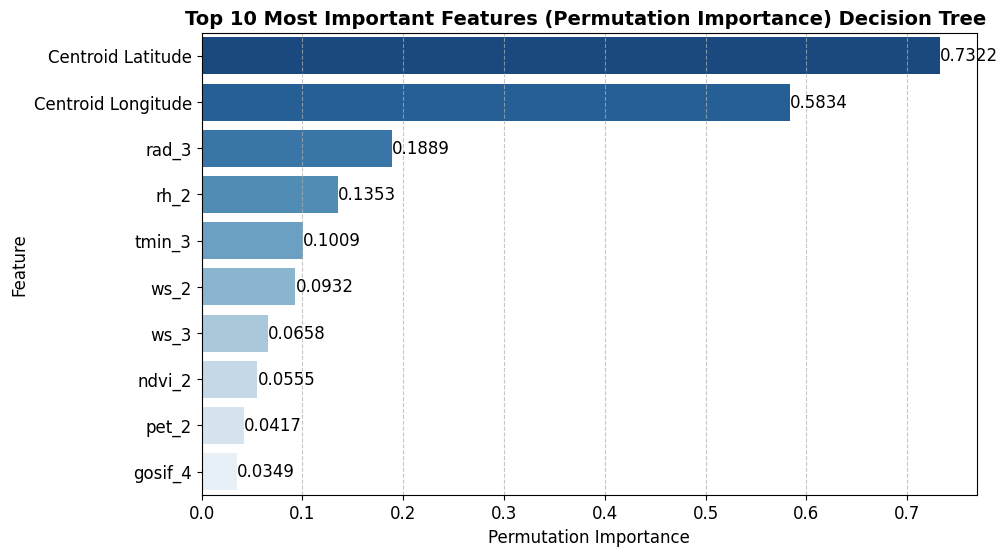

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 10 most important features
top_10_features = feature_importance_df.head(10)

# Define a color palette (using cool blues for aesthetics)
colors = sns.color_palette("Blues_r", len(top_10_features))

# Plot Bar Chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette=colors
)

# Annotate each bar with its importance value
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.4f}",  # Format importance value
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha="left", va="center",
        fontsize=12, color="black"
    )

# Set labels and title
plt.title("Top 10 Most Important Features (Permutation Importance) Decision Tree ", fontsize=14, fontweight="bold")
plt.xlabel("Permutation Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


<ipython-input-19-be211de8376a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100
<ipython-input-19-be211de8376a>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


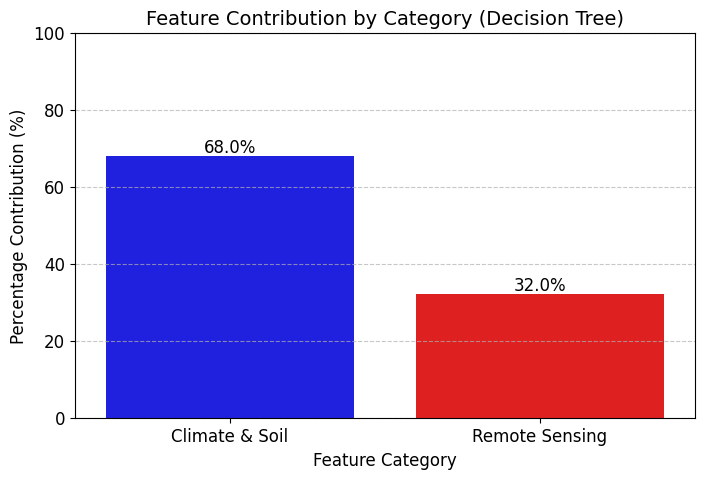

In [ ]:
# Define feature categories
climate_soil_features = ["rainfall", "pet", "rh", "rad", "tmax", "tmin", "vpd", "ws", "smtop"]
remote_sensing_features = ["evi", "ndvi", "gosif", "lai"]

# Count of features in each category
category_counts = {
    "Climate & Soil": len(climate_soil_features),
    "Remote Sensing": len(remote_sensing_features),
    "Other": 0  # Dynamic count for any unlisted features
}

# Extract base feature names by removing numeric suffixes (e.g., "evi1.3" → "evi")
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].apply(lambda x: x.split('_')[0])

# Initialize dictionary to store total importance
category_contributions = {key: 0 for key in category_counts}

# Sum importance values for each category
for _, row in feature_importance_df.iterrows():
    base_feature = row["Base_Feature"]
    importance = row["Importance"]

    if base_feature in climate_soil_features:
        category_contributions["Climate & Soil"] += importance
    elif base_feature in remote_sensing_features:
        category_contributions["Remote Sensing"] += importance
    else:
        category_contributions["Other"] += importance
        category_counts["Other"] += 1  # Count unclassified features

# Compute Average Importance per Feature
category_avg_importance = {
    category: (category_contributions[category] / category_counts[category]) if category_counts[category] > 0 else 0
    for category in category_contributions
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(
    list(category_avg_importance.items()), columns=["Feature Category", "Average Importance per Feature"]
)

# Filter out "Other" category and calculate percentage contribution
filtered_df = category_importance_df[category_importance_df["Feature Category"].isin(["Climate & Soil", "Remote Sensing"])]
total_importance = filtered_df["Average Importance per Feature"].sum()
filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100

# Define better colors for clarity
colors = ['blue', 'red']

# Plot Bar Chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=filtered_df,
    x="Feature Category",
    y="Percentage Contribution",
    palette=colors
)

# Annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom",
        fontsize=12, color="black"
    )

# Set labels and grid
plt.title("Feature Contribution by Category (Decision Tree)", fontsize=14)
plt.ylabel("Percentage Contribution (%)", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Ensures y-axis goes up to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Random Forest

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform

# Set seed for reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("/content/cp_rs_centroid_sowing_month_2000.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

best_params = {'rf__max_depth': 10, 'rf__max_features': 0.8287529872223567, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 11, 'rf__n_estimators': 309}

print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        n_estimators=best_params['rf__n_estimators'],
        max_depth=best_params['rf__max_depth'],
        min_samples_split=best_params['rf__min_samples_split'],
        min_samples_leaf=best_params['rf__min_samples_leaf'],
        max_features=best_params['rf__max_features']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=5), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")



=== Best Hyperparameters Found ===
{'rf__max_depth': 10, 'rf__max_features': 0.8287529872223567, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 11, 'rf__n_estimators': 309}

=== Fold 1 ===
Training Years: [np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004)]
Train RMSE: 0.38, Train R²: 0.87
Test RMSE: 0.47, Test R²: 0.76

=== Fold 2 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.

<ipython-input-20-1288ef7bd65e>:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


In [ ]:
from sklearn.inspection import permutation_importance

# Compute Permutation Feature Importance
pfi_results = permutation_importance(
    best_model, features, target, scoring='neg_mean_squared_error',
    n_repeats=10, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("random_forest_permutation_importance.csv", index=False)

# Print Results
print("\n=== Permutation Feature Importance (Random Forest) ===")
print(feature_importance_df.head(10))  # Print top 10



=== Permutation Feature Importance (Random Forest) ===
               Feature  Importance   Std_Dev
1   Centroid Longitude    0.519177  0.011395
0    Centroid Latitude    0.415735  0.009458
8                rad_3    0.123599  0.004030
28              tmin_3    0.085518  0.003542
26              tmin_1    0.035486  0.001708
45             gosif_4    0.023828  0.000965
15                rh_2    0.022513  0.001428
3                pet_2    0.015144  0.000609
7                rad_2    0.012061  0.000879
46               lai_1    0.011180  0.000581


<ipython-input-22-a81f9ff3e530>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


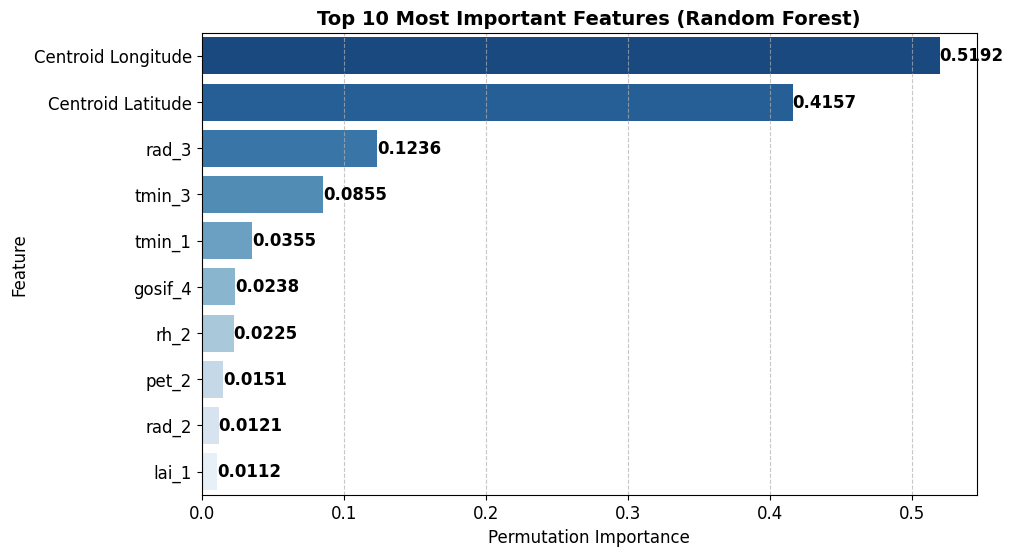

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 10 most important features
top_10_features = feature_importance_df.head(10)

# Define a color palette (blue shades for readability)
colors = sns.color_palette("Blues_r", len(top_10_features))

# Plot Bar Chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette=colors
)

# Annotate each bar with its importance value
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.4f}",  # Format importance value
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha="left", va="center",
        fontsize=12, fontweight="bold", color="black"
    )

# Set labels and title
plt.title("Top 10 Most Important Features (Random Forest)", fontsize=14, fontweight="bold")
plt.xlabel("Permutation Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


<ipython-input-23-be211de8376a>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100
<ipython-input-23-be211de8376a>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


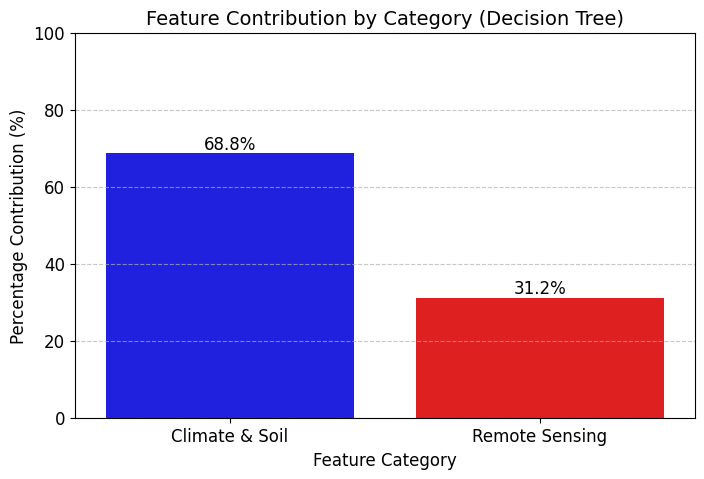

In [ ]:
# Define feature categories
climate_soil_features = ["rainfall", "pet", "rh", "rad", "tmax", "tmin", "vpd", "ws", "smtop"]
remote_sensing_features = ["evi", "ndvi", "gosif", "lai"]

# Count of features in each category
category_counts = {
    "Climate & Soil": len(climate_soil_features),
    "Remote Sensing": len(remote_sensing_features),
    "Other": 0  # Dynamic count for any unlisted features
}

# Extract base feature names by removing numeric suffixes (e.g., "evi1.3" → "evi")
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].apply(lambda x: x.split('_')[0])

# Initialize dictionary to store total importance
category_contributions = {key: 0 for key in category_counts}

# Sum importance values for each category
for _, row in feature_importance_df.iterrows():
    base_feature = row["Base_Feature"]
    importance = row["Importance"]

    if base_feature in climate_soil_features:
        category_contributions["Climate & Soil"] += importance
    elif base_feature in remote_sensing_features:
        category_contributions["Remote Sensing"] += importance
    else:
        category_contributions["Other"] += importance
        category_counts["Other"] += 1  # Count unclassified features

# Compute Average Importance per Feature
category_avg_importance = {
    category: (category_contributions[category] / category_counts[category]) if category_counts[category] > 0 else 0
    for category in category_contributions
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(
    list(category_avg_importance.items()), columns=["Feature Category", "Average Importance per Feature"]
)

# Filter out "Other" category and calculate percentage contribution
filtered_df = category_importance_df[category_importance_df["Feature Category"].isin(["Climate & Soil", "Remote Sensing"])]
total_importance = filtered_df["Average Importance per Feature"].sum()
filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100

# Define better colors for clarity
colors = ['blue', 'red']

# Plot Bar Chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=filtered_df,
    x="Feature Category",
    y="Percentage Contribution",
    palette=colors
)

# Annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom",
        fontsize=12, color="black"
    )

# Set labels and grid
plt.title("Feature Contribution by Category (Random Forest)", fontsize=14)
plt.ylabel("Percentage Contribution (%)", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Ensures y-axis goes up to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## SVR

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform

# Set seed for reproducibility
np.random.seed(42)

# Load Dataset
df = pd.read_csv("/content/cp_rs_centroid_sowing_month_2000.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Define Hyperparameter Search Space
param_dist = {
    'svr__C': uniform(0.1, 100),  # Regularization parameter
    'svr__epsilon': uniform(0.01, 1.0),  # Defines a margin of tolerance
    'svr__gamma': ['scale', 'auto']  # Kernel coefficient
}

# Initialize GroupKFold
n_splits = 10
group_kfold = GroupKFold(n_splits=n_splits)

# Perform Hyperparameter Tuning using a Full Training Dataset
full_X, full_y = features, target
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=10, cv=group_kfold, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=4, verbose=1
)
search.fit(full_X, full_y, groups=groups)

# Extract Best Parameters
best_params = search.best_params_
print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(
        C=best_params['svr__C'],
        epsilon=best_params['svr__epsilon'],
        gamma=best_params['svr__gamma']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")


Fitting 10 folds for each of 10 candidates, totalling 100 fits

=== Best Hyperparameters Found ===
{'svr__C': np.float64(26.74737779212002), 'svr__epsilon': np.float64(0.6539142670978081), 'svr__gamma': 'scale'}

=== Fold 1 ===
Training Years: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2000), np.int64(2001), np.int64(2002)]
Train RMSE: 0.44, Train R²: 0.82
Test RMSE: 0.64, Test R²: 0.58

=== Fold 2 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np

<ipython-input-25-1c56c2e7c80e>:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(



=== Permutation Feature Importance (SVR) ===
               Feature  Importance   Std_Dev
0    Centroid Latitude    0.227959  0.002295
53              ndvi_4    0.140866  0.000798
37                ws_4    0.131491  0.003592
1   Centroid Longitude    0.108586  0.002303
45             gosif_4    0.095893  0.001172
44             gosif_3    0.082187  0.003246
6                rad_1    0.078999  0.003064
39               evi_2    0.078315  0.000976
41               evi_4    0.068213  0.001767
8                rad_3    0.064998  0.000605


<ipython-input-28-f8c3ff6abd52>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


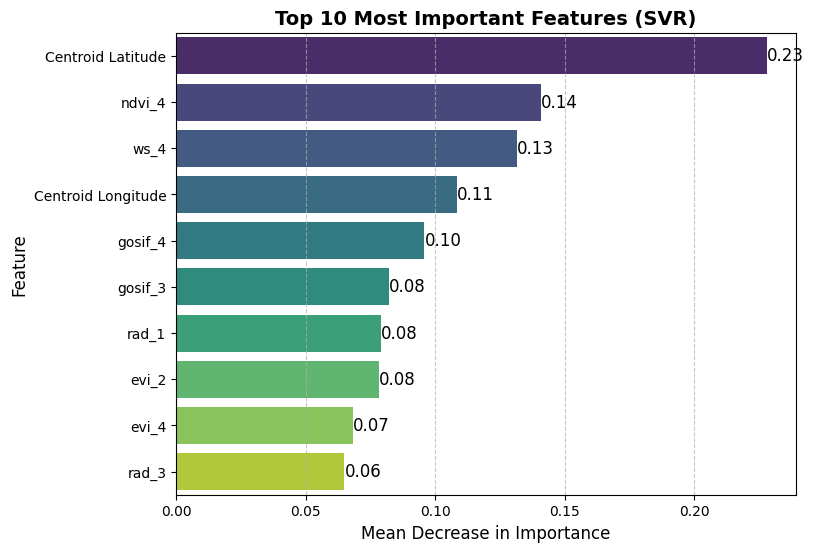

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Compute Permutation Feature Importance for SVR
pfi_results = permutation_importance(
    best_model, features, target, scoring='neg_mean_squared_error',
    n_repeats=2, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("svr_permutation_feature_importance.csv", index=False)

# Print Top 10 Features
print("\n=== Permutation Feature Importance (SVR) ===")
print(feature_importance_df.head(10))

# Select Top 10 Features
top_10_features = feature_importance_df.head(10)

# Plot Top 10 Most Important Features
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette="viridis"
)

# Annotate Values
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_width():.2f}",
                       (p.get_width(), p.get_y() + p.get_height()/2),
                       ha='left', va='center', fontsize=12, color='black')

# Labels & Title
plt.xlabel("Mean Decrease in Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features (SVR)", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

<ipython-input-29-716b87dbdbab>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100
<ipython-input-29-716b87dbdbab>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


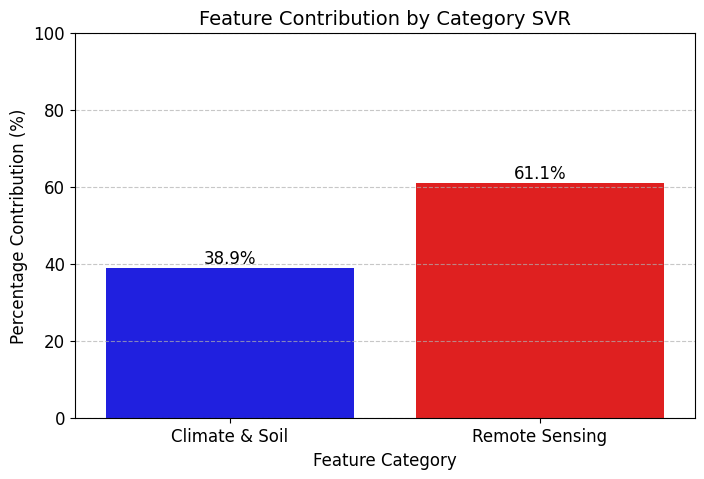

In [ ]:
# Define feature categories
climate_soil_features = ["rainfall", "pet", "rh", "rad", "tmax", "tmin", "vpd", "ws", "smtop"]
remote_sensing_features = ["evi", "ndvi", "gosif", "lai"]

# Count of features in each category
category_counts = {
    "Climate & Soil": len(climate_soil_features),
    "Remote Sensing": len(remote_sensing_features),
    "Other": 0  # Dynamic count for any unlisted features
}

# Extract base feature names by removing numeric suffixes (e.g., "evi1.3" → "evi")
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].apply(lambda x: x.split('_')[0])

# Initialize dictionary to store total importance
category_contributions = {key: 0 for key in category_counts}

# Sum importance values for each category
for _, row in feature_importance_df.iterrows():
    base_feature = row["Base_Feature"]
    importance = row["Importance"]

    if base_feature in climate_soil_features:
        category_contributions["Climate & Soil"] += importance
    elif base_feature in remote_sensing_features:
        category_contributions["Remote Sensing"] += importance
    else:
        category_contributions["Other"] += importance
        category_counts["Other"] += 1  # Count unclassified features

# Compute Average Importance per Feature
category_avg_importance = {
    category: (category_contributions[category] / category_counts[category]) if category_counts[category] > 0 else 0
    for category in category_contributions
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(
    list(category_avg_importance.items()), columns=["Feature Category", "Average Importance per Feature"]
)

# Filter out "Other" category and calculate percentage contribution
filtered_df = category_importance_df[category_importance_df["Feature Category"].isin(["Climate & Soil", "Remote Sensing"])]
total_importance = filtered_df["Average Importance per Feature"].sum()
filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100

# Define better colors for clarity
colors = ['blue', 'red']

# Plot Bar Chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=filtered_df,
    x="Feature Category",
    y="Percentage Contribution",
    palette=colors
)

# Annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom",
        fontsize=12, color="black"
    )

# Set labels and grid
plt.title("Feature Contribution by Category SVR", fontsize=14)
plt.ylabel("Percentage Contribution (%)", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Ensures y-axis goes up to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## MLP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

# Set seed for reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("/content/cp_rs_centroid_sowing_month_2000.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define MLP Pipeline
mlp_model = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(512, 128, 32, 16),  # Match TensorFlow architecture
        activation='relu',
        solver='adam',
        alpha=0.01,  # Equivalent to l2(0.01) regularization
        learning_rate_init=0.01,  # Match TensorFlow's learning rate
        batch_size=32,  # Match TensorFlow batch size
        max_iter=50,  # More iterations for stability
        early_stopping=True,  # Stops if validation loss doesn't improve
        random_state=42
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train MLP Model
    mlp_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = mlp_model.predict(X_train)
    y_test_pred_detrend = mlp_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")



=== Fold 1 ===
Training Years: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2000), np.int64(2001), np.int64(2002)]
Train RMSE: 0.51, Train R²: 0.76
Test RMSE: 0.57, Test R²: 0.67

=== Fold 2 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2003), np.int64(2004), np.int64(2005)]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Train RMSE: 0.51, Train R²: 0.77
Test RMSE: 0.53, Test R²: 0.66

=== Fold 3 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2006), np.int64(2007), np.int64(2008)]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Train RMSE: 0.49, Train R²: 0.77
Test RMSE: 0.59, Test R²: 0.70

=== Fold 4 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2009), np.int64(2010)]
Train RMSE: 0.54, Train R²: 0.73
Test RMSE: 0.65, Test R²: 0.61

=== Fold 5 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2011), np.int64(2012)]
Train RMSE: 0.52, Train R²: 0.75
Test 

<ipython-input-1-39119166a8aa>:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


```
=== Final Results ===
Average Training RMSE: 0.51
Average Training R²: 0.76
Average Testing RMSE: 0.61
Average Testing R²: 0.62
Average Yearly RMSE: 0.60
Average Yearly R² Score: 0.63

```


=== Permutation Feature Importance (MLP) ===
               Feature  Importance   Std_Dev
0    Centroid Latitude    0.256818  0.005795
1   Centroid Longitude    0.111566  0.003251
45             gosif_4    0.060432  0.002224
29              tmin_4    0.053547  0.001715
40               evi_3    0.052737  0.001927
37                ws_4    0.045712  0.001582
46               lai_1    0.043227  0.002342
41               evi_4    0.042818  0.001361
35                ws_2    0.041284  0.002563
28              tmin_3    0.039641  0.002458


<ipython-input-2-672a86f415f6>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


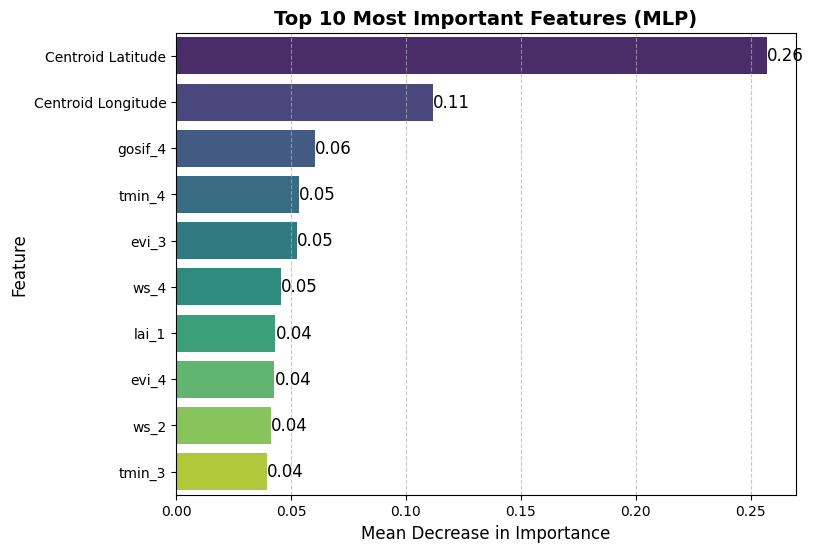

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Compute Permutation Feature Importance for MLP
pfi_results = permutation_importance(
    mlp_model, features, target, scoring='neg_mean_squared_error',
    n_repeats=10, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("mlp_permutation_feature_importance.csv", index=False)

# Print Top 10 Features
print("\n=== Permutation Feature Importance (MLP) ===")
print(feature_importance_df.head(10))

# Select Top 10 Features
top_10_features = feature_importance_df.head(10)

# Plot Top 10 Most Important Features
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette="viridis"
)

# Annotate Values
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_width():.2f}",
                       (p.get_width(), p.get_y() + p.get_height()/2),
                       ha='left', va='center', fontsize=12, color='black')

# Labels & Title
plt.xlabel("Mean Decrease in Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features (MLP)", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

<ipython-input-3-016009257f64>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100
<ipython-input-3-016009257f64>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


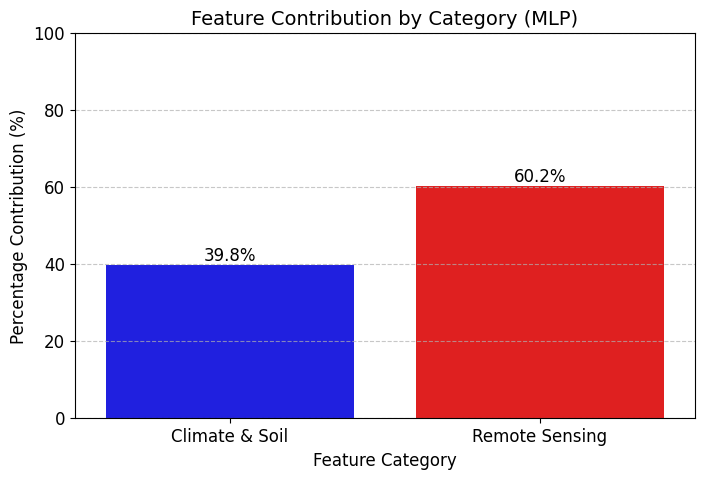

In [ ]:
# Define feature categories
climate_soil_features = ["rainfall", "pet", "rh", "rad", "tmax", "tmin", "vpd", "ws", "smtop"]
remote_sensing_features = ["evi", "ndvi", "gosif", "lai"]

# Count of features in each category
category_counts = {
    "Climate & Soil": len(climate_soil_features),
    "Remote Sensing": len(remote_sensing_features),
    "Other": 0  # Dynamic count for any unlisted features
}

# Extract base feature names by removing numeric suffixes (e.g., "evi1.3" → "evi")
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].apply(lambda x: x.split('_')[0])

# Initialize dictionary to store total importance
category_contributions = {key: 0 for key in category_counts}

# Sum importance values for each category
for _, row in feature_importance_df.iterrows():
    base_feature = row["Base_Feature"]
    importance = row["Importance"]

    if base_feature in climate_soil_features:
        category_contributions["Climate & Soil"] += importance
    elif base_feature in remote_sensing_features:
        category_contributions["Remote Sensing"] += importance
    else:
        category_contributions["Other"] += importance
        category_counts["Other"] += 1  # Count unclassified features

# Compute Average Importance per Feature
category_avg_importance = {
    category: (category_contributions[category] / category_counts[category]) if category_counts[category] > 0 else 0
    for category in category_contributions
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(
    list(category_avg_importance.items()), columns=["Feature Category", "Average Importance per Feature"]
)

# Filter out "Other" category and calculate percentage contribution
filtered_df = category_importance_df[category_importance_df["Feature Category"].isin(["Climate & Soil", "Remote Sensing"])]
total_importance = filtered_df["Average Importance per Feature"].sum()
filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100

# Define better colors for clarity
colors = ['blue', 'red']

# Plot Bar Chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=filtered_df,
    x="Feature Category",
    y="Percentage Contribution",
    palette=colors
)

# Annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom",
        fontsize=12, color="black"
    )

# Set labels and grid
plt.title("Feature Contribution by Category (MLP)", fontsize=14)
plt.ylabel("Percentage Contribution (%)", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Ensures y-axis goes up to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

```
CP : 36.2
RS : 63.8
```

## XGB

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
from scipy.stats import randint, uniform

# Set seed for full reproducibility
np.random.seed(42)

# Load Dataset
df = pd.read_csv("/content/cp_rs_centroid_sowing_month_2000.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']
# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define Hyperparameter Search Space
param_dist = {
    'xgb__n_estimators': randint(30, 400),          # Number of boosting rounds
    'xgb__max_depth': randint(1, 8),               # Tree depth
    'xgb__learning_rate': uniform(0.01, 0.3),       # Learning rate
    'xgb__subsample': uniform(0.5, 0.5),            # Subsample ratio
    'xgb__colsample_bytree': uniform(0.5, 0.5),     # Feature sampling per tree
    'xgb__reg_alpha': uniform(0, 10),               # L1 regularization
    'xgb__reg_lambda': uniform(500, 2000)           # L2 regularization
}
# Initialize GroupKFold
n_splits = 10
group_kfold = GroupKFold(n_splits=n_splits)
# Perform Hyperparameter Tuning using a Full Training Dataset
full_X, full_y = features, target
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=2, cv=group_kfold, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=320, verbose=1
)
search.fit(full_X, full_y, groups=groups)

# Extract Best Parameters
best_params = search.best_params_
print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=best_params['xgb__n_estimators'],
        max_depth=best_params['xgb__max_depth'],
        learning_rate=best_params['xgb__learning_rate'],
        subsample=best_params['xgb__subsample'],
        colsample_bytree=best_params['xgb__colsample_bytree'],
        reg_alpha=best_params['xgb__reg_alpha'],
        reg_lambda=best_params['xgb__reg_lambda']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")


Fitting 10 folds for each of 2 candidates, totalling 20 fits

=== Best Hyperparameters Found ===
{'xgb__colsample_bytree': np.float64(0.8571769927074147), 'xgb__learning_rate': np.float64(0.08678998140083036), 'xgb__max_depth': 6, 'xgb__n_estimators': 299, 'xgb__reg_alpha': np.float64(4.006918351439975), 'xgb__reg_lambda': np.float64(1916.8237062298554), 'xgb__subsample': np.float64(0.8113983936197855)}

=== Fold 1 ===
Training Years: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2000), np.int64(2001), np.int64(2002)]
Train RMSE: 0.48, Train R²: 0.79
Test RMSE: 0.53, Test R²: 0.72

=== Fold 2 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2006), np.int64(2007),

<ipython-input-33-3878735022a7>:146: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
from scipy.stats import randint, uniform

# Set seed for full reproducibility
np.random.seed(8)

# Load Dataset
df = pd.read_csv("cp_rs_centroid_sowing_month_2000.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']
# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

#=== Best Hyperparameters Found ===
# best_params ={'xgb__colsample_bytree': 0.9290418060840998,
#  'xgb__learning_rate': 0.16985284373248053,
#  'xgb__max_depth': 4,
#  'xgb__n_estimators': 390,
#  'xgb__reg_alpha': 7.508884729488528,
#  'xgb__reg_lambda': 1999.4115790271003,
#  'xgb__subsample': 0.609993861334124}

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=best_params['xgb__n_estimators'],
        max_depth=best_params['xgb__max_depth'],
        learning_rate=best_params['xgb__learning_rate'],
        subsample=best_params['xgb__subsample'],
        colsample_bytree=best_params['xgb__colsample_bytree'],
        reg_alpha=best_params['xgb__reg_alpha'],
        reg_lambda=best_params['xgb__reg_lambda']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")



=== Fold 1 ===
Training Years: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2000), np.int64(2001), np.int64(2002)]
Train RMSE: 0.48, Train R²: 0.79
Test RMSE: 0.53, Test R²: 0.72

=== Fold 2 ===
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2003), np.int64(2004), np.int64(2005)]
Train RMSE: 0.48, Train R²: 0.79
Test RMSE: 0.49, Test R²: 0.72

=== Fold 3 ===
Training Years: [np.in

<ipython-input-38-5c2cf56897d5>:128: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Compute Permutation Feature Importance
pfi_results = permutation_importance(
    best_model, features, target, scoring='neg_mean_squared_error',
    n_repeats=10, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("xgb_permutation_feature_importance.csv", index=False)

# Print Results
print("\n=== Permutation Feature Importance ===")
print(feature_importance_df.head(10))  # Show top 10



=== Permutation Feature Importance ===
               Feature  Importance   Std_Dev
1   Centroid Longitude    0.341448  0.006695
0    Centroid Latitude    0.247847  0.006298
8                rad_3    0.048052  0.001950
7                rad_2    0.044125  0.001406
26              tmin_1    0.030444  0.001280
46               lai_1    0.019512  0.000723
24              tmax_3    0.014080  0.000394
28              tmin_3    0.013607  0.000399
45             gosif_4    0.013036  0.000424
35                ws_2    0.011379  0.000407


<ipython-input-36-760a695a2013>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


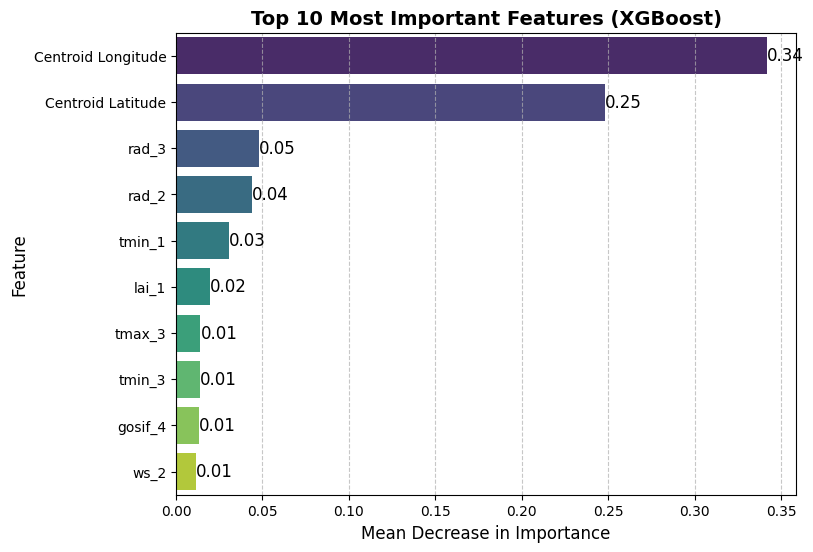

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

feature_importance_df = pd.read_csv('/content/xgb_permutation_feature_importance.csv')
# Select Top 10 Features
top_10_features = feature_importance_df.head(10)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette="viridis"
)

# Annotate Values
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_width():.2f}",
                       (p.get_width(), p.get_y() + p.get_height()/2),
                       ha='left', va='center', fontsize=12, color='black')

# Labels & Title
plt.xlabel("Mean Decrease in Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features (XGBoost)", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show Plot
plt.show()


<ipython-input-37-016017092c18>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100
<ipython-input-37-016017092c18>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


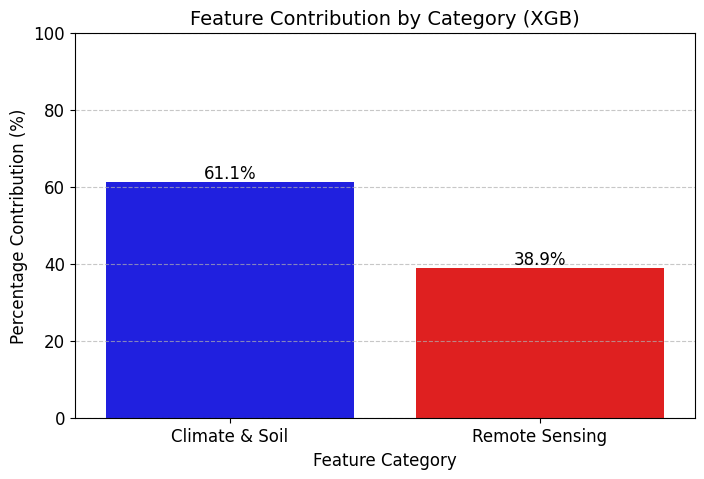

In [ ]:
# Define feature categories
climate_soil_features = ["rainfall", "pet", "rh", "rad", "tmax", "tmin", "vpd", "ws", "smtop"]
remote_sensing_features = ["evi", "ndvi", "gosif", "lai"]

# Count of features in each category
category_counts = {
    "Climate & Soil": len(climate_soil_features),
    "Remote Sensing": len(remote_sensing_features),
    "Other": 0  # Dynamic count for any unlisted features
}

# Extract base feature names by removing numeric suffixes (e.g., "evi1.3" → "evi")
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].apply(lambda x: x.split('_')[0])

# Initialize dictionary to store total importance
category_contributions = {key: 0 for key in category_counts}

# Sum importance values for each category
for _, row in feature_importance_df.iterrows():
    base_feature = row["Base_Feature"]
    importance = row["Importance"]

    if base_feature in climate_soil_features:
        category_contributions["Climate & Soil"] += importance
    elif base_feature in remote_sensing_features:
        category_contributions["Remote Sensing"] += importance
    else:
        category_contributions["Other"] += importance
        category_counts["Other"] += 1  # Count unclassified features

# Compute Average Importance per Feature
category_avg_importance = {
    category: (category_contributions[category] / category_counts[category]) if category_counts[category] > 0 else 0
    for category in category_contributions
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(
    list(category_avg_importance.items()), columns=["Feature Category", "Average Importance per Feature"]
)

# Filter out "Other" category and calculate percentage contribution
filtered_df = category_importance_df[category_importance_df["Feature Category"].isin(["Climate & Soil", "Remote Sensing"])]
total_importance = filtered_df["Average Importance per Feature"].sum()
filtered_df["Percentage Contribution"] = (filtered_df["Average Importance per Feature"] / total_importance) * 100

# Define better colors for clarity
colors = ['blue', 'red']

# Plot Bar Chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=filtered_df,
    x="Feature Category",
    y="Percentage Contribution",
    palette=colors
)

# Annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom",
        fontsize=12, color="black"
    )

# Set labels and grid
plt.title("Feature Contribution by Category (XGB)", fontsize=14)
plt.ylabel("Percentage Contribution (%)", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Ensures y-axis goes up to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## XGB 2

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Hyperparameters found:  {'xgb__colsample_bytree': np.float64(0.5290418060840998), 'xgb__learning_rate': np.float64(0.26985284373248053), 'xgb__max_depth': 5, 'xgb__n_estimators': 369, 'xgb__reg_alpha': np.float64(7.080725777960454), 'xgb__reg_lambda': np.float64(120.58449429580244), 'xgb__subsample': np.float64(0.9849549260809971)}

Feature Importances:
               Feature  Importance
0    Centroid Latitude    0.161004
8                rad_3    0.143052
4                pet_3    0.099218
1   Centroid Longitude    0.075781
32               vpd_3    0.045559
15                rh_2    0.028507
37                ws_4    0.026014
26              tmin_1    0.022756
28              tmin_3    0.022519
24              tmax_3    0.019337
34                ws_1    0.017564
45             gosif_4    0.017338
3                pet_2    0.017056
19             smtop_2    0.016579
7                rad_2    0.015628
49               l

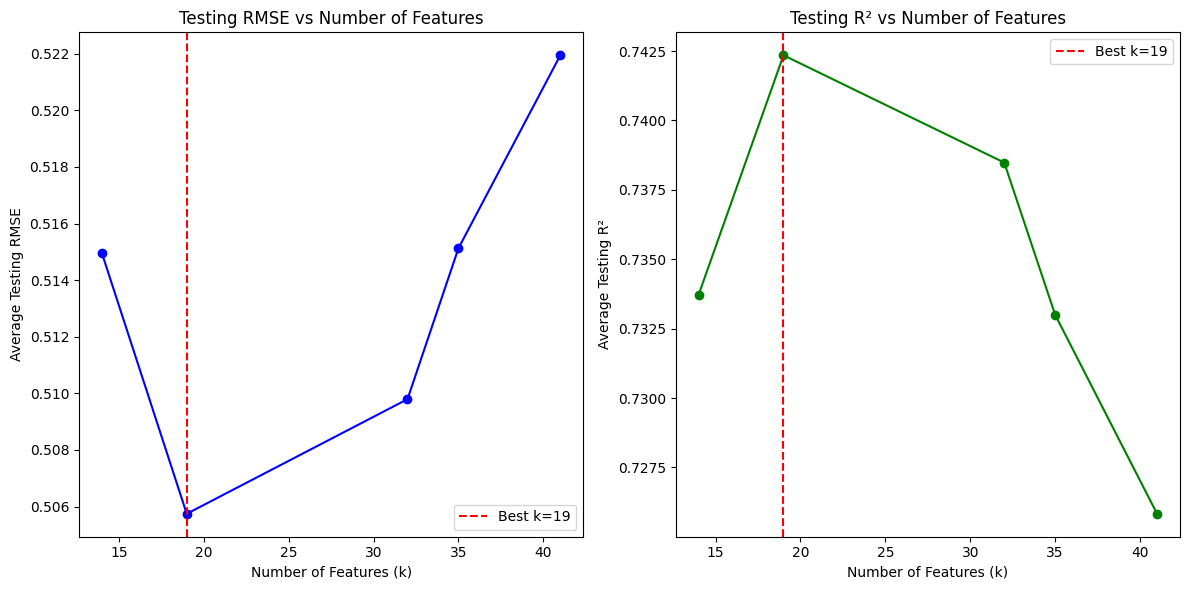


Top 19 Features Selected:
['Centroid Latitude', 'rad_3', 'pet_3', 'Centroid Longitude', 'vpd_3', 'rh_2', 'ws_4', 'tmin_1', 'tmin_3', 'tmax_3', 'ws_1', 'gosif_4', 'pet_2', 'smtop_2', 'rad_2', 'lai_4', 'tmax_1', 'lai_1', 'smtop_1']
Using Best Hyperparameters: {'xgb__colsample_bytree': np.float64(0.5290418060840998), 'xgb__learning_rate': np.float64(0.26985284373248053), 'xgb__max_depth': 5, 'xgb__n_estimators': 369, 'xgb__reg_alpha': np.float64(7.080725777960454), 'xgb__reg_lambda': np.float64(120.58449429580244), 'xgb__subsample': np.float64(0.9849549260809971)}


In [ ]:

# Load the dataset
df = pd.read_csv('/content/cp_rs_centroid_sowing_month_2000.csv')

features = df.drop(['Actual', 'Trend', 'Detrended_Yield','District','Year'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
groups = df['Year']
feature_names = features.columns

# Function for consecutive GroupKFold splits
def consecutive_group_kfold(df, n_splits = 10):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)
    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Initialize GroupKFold for RandomizedSearchCV
n_splits = 10
group_kfold = GroupKFold(n_splits=n_splits)

# Define parameter distribution
param_dist = {
    'xgb__n_estimators': randint(10, 400),
    'xgb__max_depth': randint(2, 15),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.5, 0.5),
    'xgb__reg_alpha': uniform(0, 10),
    'xgb__reg_lambda': uniform(100, 1000)
}

# Initial model training with all features to find best hyperparameters
pipeline = Pipeline([('scaler', StandardScaler()), ('xgb', XGBRegressor())])
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=5,
    cv=group_kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search.fit(features, target, groups=groups)

# Best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters found: ", best_params)

# Extract feature importances from the best model
best_pipeline = random_search.best_estimator_
feature_importances = best_pipeline.named_steps['xgb'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)

# Function to evaluate performance with top k features using best params
def evaluate_top_k_features(k, features, target, trend, groups, best_params, n_splits = 10):
    top_k_features = feature_importance_df['Feature'].head(k).tolist()
    X_top_k = features[top_k_features]

    # Initialize pipeline with best parameters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(
            colsample_bytree=best_params['xgb__colsample_bytree'],
            learning_rate=best_params['xgb__learning_rate'],
            max_depth=best_params['xgb__max_depth'],
            n_estimators=best_params['xgb__n_estimators'],
            reg_alpha=best_params['xgb__reg_alpha'],
            reg_lambda=best_params['xgb__reg_lambda'],
            subsample=best_params['xgb__subsample']
        ))
    ])

    train_rmse_list, train_r2_list, test_rmse_list, test_r2_list = [], [], [], []

    # Perform consecutive GroupKFold cross-validation
    for fold, (train_df, test_df) in enumerate(consecutive_group_kfold(df, n_splits=n_splits), start=1):
        print(f"Fold {fold}:")
        print(f"Training Years: {sorted(train_df['Year'].unique())}")
        print(f"Testing Years: {sorted(test_df['Year'].unique())}\n")

        train_index = train_df.index
        test_index = test_df.index

        X_train, X_test = X_top_k.iloc[train_index], X_top_k.iloc[test_index]
        y_train_detrend, y_test_detrend = target.iloc[train_index], target.iloc[test_index]
        trend_train, trend_test = trend.iloc[train_index], trend[test_index]

        y_train_actual = y_train_detrend + trend_train
        y_test_actual = y_test_detrend + trend_test

        pipeline.fit(X_train, y_train_detrend)

        # Training predictions
        y_train_pred_detrend = pipeline.predict(X_train)
        y_train_pred = y_train_pred_detrend + trend_train

        # Testing predictions
        y_pred_test_detrend = pipeline.predict(X_test)
        y_pred_test = y_pred_test_detrend + trend_test

        # Calculate training metrics
        train_rmse = root_mean_squared_error(y_train_actual, y_train_pred)
        train_r2 = r2_score(y_train_actual, y_train_pred)
        train_rmse_list.append(train_rmse)
        train_r2_list.append(train_r2)

        # Calculate testing metrics
        test_rmse = root_mean_squared_error(y_test_actual, y_pred_test)
        test_r2 = r2_score(y_test_actual, y_pred_test)
        test_rmse_list.append(test_rmse)
        test_r2_list.append(test_r2)

    avg_train_rmse = np.mean(train_rmse_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_test_rmse = np.mean(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)

    return avg_train_rmse, avg_train_r2, avg_test_rmse, avg_test_r2

# Randomly sample 10 k values
n_features = len(feature_names)
k_values = random.sample(range(2, min(n_features, 70) + 1), 5)
k_values.sort()  # Sort for better visualization
rmse_results = []
r2_results = []

# Evaluate performance for each k
for k in k_values:
    avg_train_rmse, avg_train_r2, avg_test_rmse, avg_test_r2 = evaluate_top_k_features(
        k, features, target, trend, groups, best_params, n_splits
    )
    rmse_results.append(avg_test_rmse)
    r2_results.append(avg_test_r2)
    print(f"\nk={k}:")
    print(f"Average Training RMSE: {avg_train_rmse:.2f}")
    print(f"Average Training R²: {avg_train_r2:.2f}")
    print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
    print(f"Average Testing R²: {avg_test_r2:.2f}")
    print(f"Average RMSE: {avg_test_rmse:.2f}")

# Find best k
best_k_rmse = k_values[np.argmin(rmse_results)]
best_rmse = min(rmse_results)
best_k_r2 = k_values[np.argmax(r2_results)]
best_r2 = max(r2_results)

print(f"\nBest k for minimum RMSE: k={best_k_rmse}, RMSE={best_rmse:.2f}")
print(f"Best k for maximum R²: k={best_k_r2}, R²={best_r2:.2f}")

# Plot RMSE and R² vs k
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_results, marker='o', color='blue')
plt.xlabel('Number of Features (k)')
plt.ylabel('Average Testing RMSE')
plt.title('Testing RMSE vs Number of Features')
plt.axvline(x=best_k_rmse, color='red', linestyle='--', label=f'Best k={best_k_rmse}')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(k_values, r2_results, marker='o', color='green')
plt.xlabel('Number of Features (k)')
plt.ylabel('Average Testing R²')
plt.title('Testing R² vs Number of Features')
plt.axvline(x=best_k_r2, color='red', linestyle='--', label=f'Best k={best_k_r2}')
plt.legend()

plt.tight_layout()
plt.show()

# Final output
best_k = best_k_r2  # Default to RMSE; switch to best_k_r2 if preferred
top_k_features = feature_importance_df['Feature'].head(best_k).tolist()
print(f"\nTop {best_k} Features Selected:")
print(top_k_features)
print(f"Using Best Hyperparameters: {best_params}")

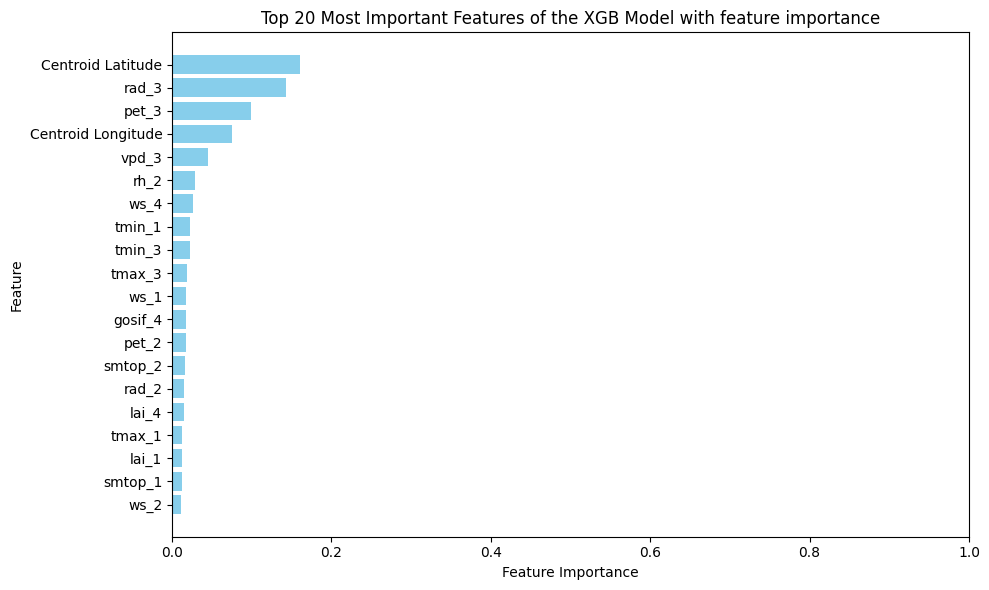

In [ ]:
# Plotting the top 10 important features
top_10_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features of the XGB Model with feature importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.xlim(0,1)
plt.tight_layout()
plt.show()

```
 K = 113

 ```

In [ ]:
best_params

{'xgb__colsample_bytree': np.float64(0.5290418060840998),
 'xgb__learning_rate': np.float64(0.26985284373248053),
 'xgb__max_depth': 5,
 'xgb__n_estimators': 369,
 'xgb__reg_alpha': np.float64(7.080725777960454),
 'xgb__reg_lambda': np.float64(120.58449429580244),
 'xgb__subsample': np.float64(0.9849549260809971)}

In [ ]:
# --- Step 2: Re-tune hyperparameters with top k features for multiple seeds ---
seeds = [8]  # 3 different seed values
K = 22
top_k_features = feature_importance_df['Feature'].head(K).tolist()
features_top_k = features[top_k_features]

# Lists to store metrics across seeds
train_rmse_seeds, train_r2_seeds, test_rmse_seeds, test_r2_seeds = [], [], [], []
yearly_rmse_seeds, yearly_r2_seeds = [], []
all_results = []

for seed in seeds:
    print(f"\n--- Re-tuning Hyperparameters with Top {K} Features (Seed: {seed}) ---")

    # Reset predictions in DataFrame for each seed
    df['Predicted'] = np.nan

    # Re-run RandomizedSearchCV with top k features
    random_search_top_k = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=5,
        cv=group_kfold,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=2,
        random_state=seed
    )
    random_search_top_k.fit(features_top_k, target, groups=groups)

    # Best hyperparameters for top k
    best_params_top_k = random_search_top_k.best_params_
    print(f"Best Hyperparameters found (top k run, seed {seed}): ", best_params_top_k)

    # Evaluate with the new best parameters
    pipeline_top_k = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(
            colsample_bytree=best_params_top_k['xgb__colsample_bytree'],
            learning_rate=best_params_top_k['xgb__learning_rate'],
            max_depth=best_params_top_k['xgb__max_depth'],
            n_estimators=best_params_top_k['xgb__n_estimators'],
            reg_alpha=best_params_top_k['xgb__reg_alpha'],
            reg_lambda=best_params_top_k['xgb__reg_lambda'],
            subsample=best_params_top_k['xgb__subsample']
        ))
    ])

    train_rmse_list, train_r2_list, test_rmse_list, test_r2_list = [], [], [], []

    for fold, (train_df, test_df) in enumerate(consecutive_group_kfold(df, n_splits=n_splits), start=1):
        print(f"Fold {fold}:")
        print(f"Training Years: {sorted(train_df['Year'].unique())}")
        print(f"Testing Years: {sorted(test_df['Year'].unique())}\n")

        train_index = train_df.index
        test_index = test_df.index

        X_train, X_test = features_top_k.iloc[train_index], features_top_k.iloc[test_index]
        y_train_detrend, y_test_detrend = target.iloc[train_index], target.iloc[test_index]
        trend_train, trend_test = trend.iloc[train_index], trend[test_index]

        y_train_actual = y_train_detrend + trend_train
        y_test_actual = y_test_detrend + trend_test

        pipeline_top_k.fit(X_train, y_train_detrend)

        y_train_pred_detrend = pipeline_top_k.predict(X_train)
        y_train_pred = y_train_pred_detrend + trend_train

        y_pred_test_detrend = pipeline_top_k.predict(X_test)
        y_pred_test = y_pred_test_detrend + trend_test

        df.loc[test_index, 'Predicted'] = y_pred_test
        # Save prediction results at district-year level
        for idx in test_index:
            year = df.loc[idx, 'Year']
            district = df.loc[idx, 'District']
            actual_yield = df.loc[idx, 'Actual']
            predicted_yield = df.loc[idx, 'Predicted']

            all_results.append({
                'Seed': seed,
                'Fold': fold,
                'Year': year,
                'District': district,
                'Actual_Yield': actual_yield,
                'Predicted_Yield_XGB': predicted_yield
            })

        train_rmse = root_mean_squared_error(y_train_actual, y_train_pred)
        train_r2 = r2_score(y_train_actual, y_train_pred)
        test_rmse = root_mean_squared_error(y_test_actual, y_pred_test)
        test_r2 = r2_score(y_test_actual, y_pred_test)

        train_rmse_list.append(train_rmse)
        train_r2_list.append(train_r2)
        test_rmse_list.append(test_rmse)
        test_r2_list.append(test_r2)

    avg_train_rmse = np.mean(train_rmse_list)
    avg_train_r2 = np.mean(train_r2_list)
    avg_test_rmse = np.mean(test_rmse_list)
    avg_test_r2 = np.mean(test_r2_list)

    print(f"\nFinal Model with Top {K} Features (Seed {seed}):")
    print(f"Average Training RMSE: {avg_train_rmse:.2f}")
    print(f"Average Training R²: {avg_train_r2:.2f}")
    print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
    print(f"Average Testing R²: {avg_test_r2:.2f}")

    # Calculate yearly metrics
    yearly_metrics = df.groupby('Year').apply(
        lambda x: pd.Series({
            'RMSE': root_mean_squared_error(x['Actual'], x['Predicted']),
            'R2_Score': r2_score(x['Actual'], x['Predicted'])
        })
    ).reset_index()

    avg_yearly_rmse = yearly_metrics['RMSE'].mean()
    avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

    print(f"\nAverage Yearly RMSE (Seed {seed}): {avg_yearly_rmse:.2f}")
    print(f"Average Yearly R² Score (Seed {seed}): {avg_yearly_r2_score:.2f}")
    print("\nYearly Metrics (RMSE & R² Score):")
    print(yearly_metrics)

    # Store metrics for this seed
    train_rmse_seeds.append(avg_train_rmse)
    train_r2_seeds.append(avg_train_r2)
    test_rmse_seeds.append(avg_test_rmse)
    test_r2_seeds.append(avg_test_r2)
    yearly_rmse_seeds.append(avg_yearly_rmse)
    yearly_r2_seeds.append(avg_yearly_r2_score)

# Compute mean and std across seeds
mean_train_rmse = np.mean(train_rmse_seeds)
std_train_rmse = np.std(train_rmse_seeds)
mean_train_r2 = np.mean(train_r2_seeds)
std_train_r2 = np.std(train_r2_seeds)
mean_test_rmse = np.mean(test_rmse_seeds)
std_test_rmse = np.std(test_rmse_seeds)
mean_test_r2 = np.mean(test_r2_seeds)
std_test_r2 = np.std(test_r2_seeds)
mean_yearly_rmse = np.mean(yearly_rmse_seeds)
std_yearly_rmse = np.std(yearly_rmse_seeds)
mean_yearly_r2 = np.mean(yearly_r2_seeds)
std_yearly_r2 = np.std(yearly_r2_seeds)

# Print mean ± std results
print("\n--- Final Results Across Seeds ---")
print(f"Mean Training RMSE: {mean_train_rmse:.2f} ± {std_train_rmse:.2f}")
print(f"Mean Training R²: {mean_train_r2:.2f} ± {std_train_r2:.2f}")
print(f"Mean Testing RMSE: {mean_test_rmse:.2f} ± {std_test_rmse:.2f}")
print(f"Mean Testing R²: {mean_test_r2:.2f} ± {std_test_r2:.2f}")
print(f"Mean Yearly RMSE: {mean_yearly_rmse:.2f} ± {std_yearly_rmse:.2f}")
print(f"Mean Yearly R²: {mean_yearly_r2:.2f} ± {std_yearly_r2:.2f}")

# Plotting can be done for one seed (e.g., last seed) or averaged, here we skip for brevity
print(f"\nTop {K} Features Selected:")
print(top_k_features)

# Convert all_results to DataFrame and save to CSV
results_df = pd.DataFrame(all_results)
results_csv_path = f"/content/XGB_Rice_yield_predictions_top{K}_features.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"\n✅ Saved prediction results to {results_csv_path}")



--- Re-tuning Hyperparameters with Top 22 Features (Seed: 8) ---
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best Hyperparameters found (top k run, seed 8):  {'xgb__colsample_bytree': np.float64(0.9367147013959081), 'xgb__learning_rate': np.float64(0.3005621988462796), 'xgb__max_depth': 7, 'xgb__n_estimators': 146, 'xgb__reg_alpha': np.float64(8.1646128172225), 'xgb__reg_lambda': np.float64(522.3508016124277), 'xgb__subsample': np.float64(0.806016666555661)}
Fold 1:
Training Years: [np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]
Testing Years: [np.int64(2000), np.int64(2001), np.int64(2002)]

Fold 2:
Training Years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2006), np.int64(2007), np.i

<ipython-input-10-3c0ed72de57c>:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


## GAT - LSTM

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch_geometric.nn import GATConv, GATv2Conv, GINConv, TransformerConv
import random
import seaborn as sns


Fold 1/10 - Test Years: [np.int64(2000), np.int64(2001), np.int64(2002)]
Fold 1 Epoch [1/30] - Train Loss: 1.1825, Test Loss: 0.8360, Train RMSE: 1.0874, Test RMSE: 0.9143, Train R²: -0.0981, Test R²: 0.1411
Fold 1 Epoch [2/30] - Train Loss: 0.8361, Test Loss: 0.6056, Train RMSE: 0.9144, Test RMSE: 0.7782, Train R²: 0.2236, Test R²: 0.3778
Fold 1 Epoch [3/30] - Train Loss: 0.7057, Test Loss: 0.6325, Train RMSE: 0.8401, Test RMSE: 0.7953, Train R²: 0.3447, Test R²: 0.3502
Fold 1 Epoch [4/30] - Train Loss: 0.6380, Test Loss: 0.5450, Train RMSE: 0.7988, Test RMSE: 0.7382, Train R²: 0.4075, Test R²: 0.4401
Fold 1 Epoch [5/30] - Train Loss: 0.5921, Test Loss: 0.4938, Train RMSE: 0.7695, Test RMSE: 0.7027, Train R²: 0.4502, Test R²: 0.4927
Fold 1 Epoch [6/30] - Train Loss: 0.5660, Test Loss: 0.4538, Train RMSE: 0.7523, Test RMSE: 0.6736, Train R²: 0.4744, Test R²: 0.5338
Fold 1 Epoch [7/30] - Train Loss: 0.5264, Test Loss: 0.4317, Train RMSE: 0.7255, Test RMSE: 0.6570, Train R²: 0.5112, Tes

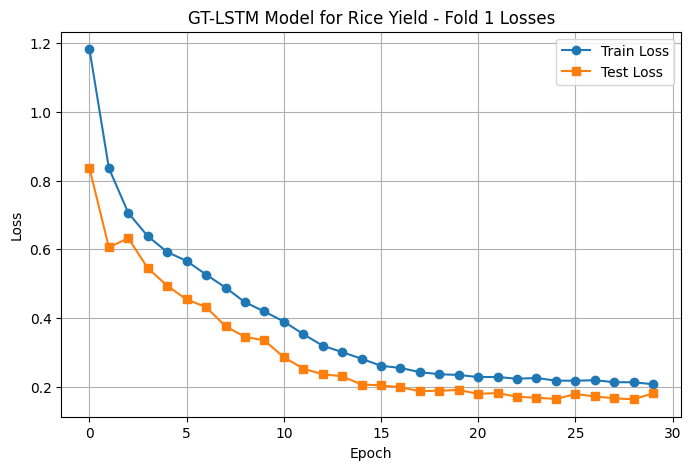


Fold 2/10 - Test Years: [np.int64(2003), np.int64(2004), np.int64(2005)]
Fold 2 Epoch [1/30] - Train Loss: 1.9065, Test Loss: 0.8739, Train RMSE: 1.3808, Test RMSE: 0.9348, Train R²: -0.7217, Test R²: -0.0375
Fold 2 Epoch [2/30] - Train Loss: 1.0425, Test Loss: 0.7288, Train RMSE: 1.0210, Test RMSE: 0.8537, Train R²: 0.0586, Test R²: 0.1348
Fold 2 Epoch [3/30] - Train Loss: 0.8113, Test Loss: 0.5904, Train RMSE: 0.9007, Test RMSE: 0.7684, Train R²: 0.2674, Test R²: 0.2991
Fold 2 Epoch [4/30] - Train Loss: 0.7013, Test Loss: 0.5310, Train RMSE: 0.8375, Test RMSE: 0.7287, Train R²: 0.3667, Test R²: 0.3695
Fold 2 Epoch [5/30] - Train Loss: 0.6511, Test Loss: 0.5009, Train RMSE: 0.8069, Test RMSE: 0.7078, Train R²: 0.4120, Test R²: 0.4053
Fold 2 Epoch [6/30] - Train Loss: 0.6082, Test Loss: 0.4450, Train RMSE: 0.7799, Test RMSE: 0.6671, Train R²: 0.4508, Test R²: 0.4717
Fold 2 Epoch [7/30] - Train Loss: 0.5422, Test Loss: 0.4000, Train RMSE: 0.7364, Test RMSE: 0.6324, Train R²: 0.5104, Te

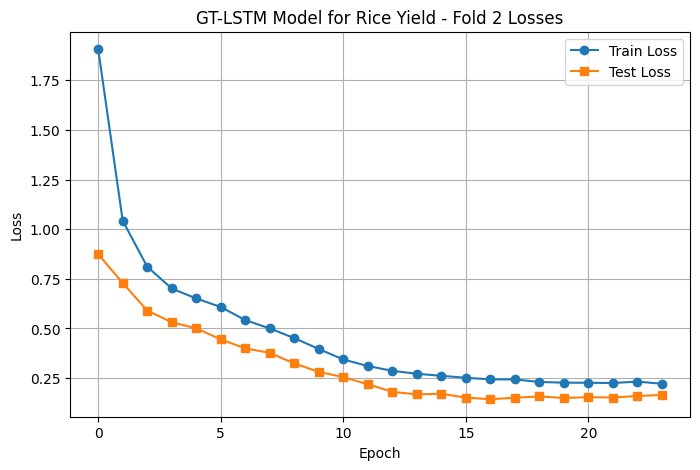


Fold 3/10 - Test Years: [np.int64(2006), np.int64(2007), np.int64(2008)]
Fold 3 Epoch [1/30] - Train Loss: 1.7271, Test Loss: 1.2734, Train RMSE: 1.3142, Test RMSE: 1.1284, Train R²: -0.6181, Test R²: -0.0920
Fold 3 Epoch [2/30] - Train Loss: 0.9809, Test Loss: 0.8676, Train RMSE: 0.9904, Test RMSE: 0.9315, Train R²: 0.0810, Test R²: 0.2559
Fold 3 Epoch [3/30] - Train Loss: 0.7346, Test Loss: 0.7577, Train RMSE: 0.8571, Test RMSE: 0.8705, Train R²: 0.3118, Test R²: 0.3502
Fold 3 Epoch [4/30] - Train Loss: 0.6603, Test Loss: 0.6728, Train RMSE: 0.8126, Test RMSE: 0.8203, Train R²: 0.3813, Test R²: 0.4230
Fold 3 Epoch [5/30] - Train Loss: 0.6233, Test Loss: 0.6279, Train RMSE: 0.7895, Test RMSE: 0.7924, Train R²: 0.4160, Test R²: 0.4615
Fold 3 Epoch [6/30] - Train Loss: 0.5839, Test Loss: 0.5827, Train RMSE: 0.7642, Test RMSE: 0.7634, Train R²: 0.4529, Test R²: 0.5003
Fold 3 Epoch [7/30] - Train Loss: 0.5472, Test Loss: 0.5486, Train RMSE: 0.7397, Test RMSE: 0.7406, Train R²: 0.4874, Te

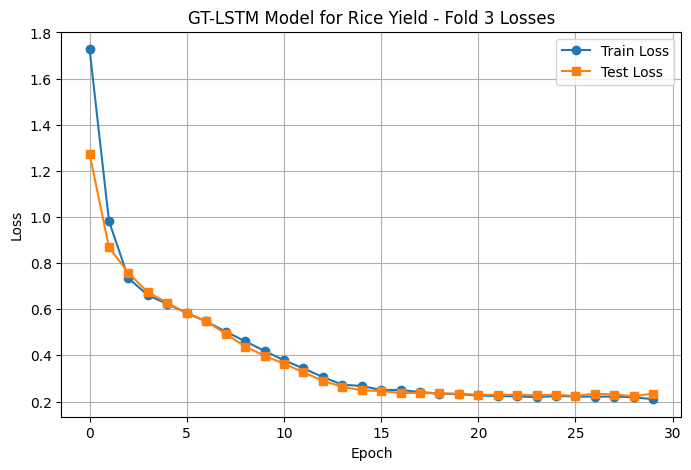


Fold 4/10 - Test Years: [np.int64(2009), np.int64(2010)]
Fold 4 Epoch [1/30] - Train Loss: 1.8161, Test Loss: 1.3089, Train RMSE: 1.3476, Test RMSE: 1.1441, Train R²: -0.6839, Test R²: -0.1889
Fold 4 Epoch [2/30] - Train Loss: 1.0008, Test Loss: 0.9486, Train RMSE: 1.0004, Test RMSE: 0.9739, Train R²: 0.0720, Test R²: 0.1384
Fold 4 Epoch [3/30] - Train Loss: 0.7485, Test Loss: 0.7351, Train RMSE: 0.8652, Test RMSE: 0.8574, Train R²: 0.3059, Test R²: 0.3323
Fold 4 Epoch [4/30] - Train Loss: 0.6504, Test Loss: 0.7014, Train RMSE: 0.8065, Test RMSE: 0.8375, Train R²: 0.3969, Test R²: 0.3629
Fold 4 Epoch [5/30] - Train Loss: 0.6183, Test Loss: 0.6596, Train RMSE: 0.7863, Test RMSE: 0.8122, Train R²: 0.4267, Test R²: 0.4009
Fold 4 Epoch [6/30] - Train Loss: 0.5797, Test Loss: 0.6214, Train RMSE: 0.7614, Test RMSE: 0.7883, Train R²: 0.4625, Test R²: 0.4356
Fold 4 Epoch [7/30] - Train Loss: 0.5311, Test Loss: 0.6052, Train RMSE: 0.7288, Test RMSE: 0.7780, Train R²: 0.5075, Test R²: 0.4503
Fo

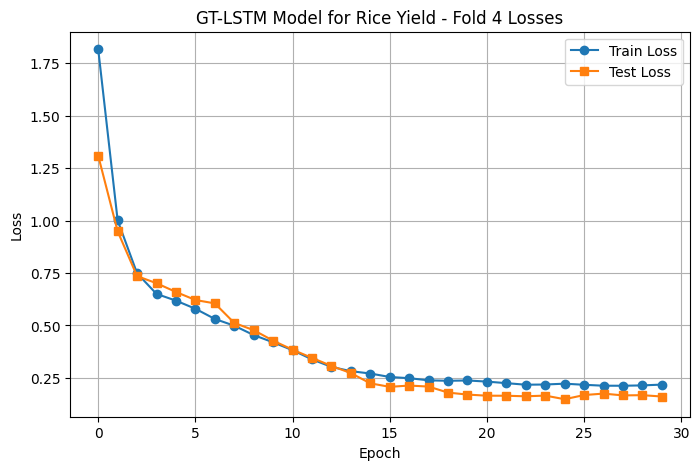


Fold 5/10 - Test Years: [np.int64(2011), np.int64(2012)]
Fold 5 Epoch [1/30] - Train Loss: 1.9292, Test Loss: 1.0512, Train RMSE: 1.3890, Test RMSE: 1.0253, Train R²: -0.7553, Test R²: -0.1329
Fold 5 Epoch [2/30] - Train Loss: 1.1169, Test Loss: 0.9281, Train RMSE: 1.0568, Test RMSE: 0.9634, Train R²: -0.0162, Test R²: -0.0003
Fold 5 Epoch [3/30] - Train Loss: 0.8859, Test Loss: 0.6804, Train RMSE: 0.9412, Test RMSE: 0.8249, Train R²: 0.1940, Test R²: 0.2667
Fold 5 Epoch [4/30] - Train Loss: 0.7259, Test Loss: 0.5977, Train RMSE: 0.8520, Test RMSE: 0.7731, Train R²: 0.3395, Test R²: 0.3558
Fold 5 Epoch [5/30] - Train Loss: 0.6364, Test Loss: 0.5652, Train RMSE: 0.7978, Test RMSE: 0.7518, Train R²: 0.4209, Test R²: 0.3908
Fold 5 Epoch [6/30] - Train Loss: 0.6007, Test Loss: 0.5115, Train RMSE: 0.7751, Test RMSE: 0.7152, Train R²: 0.4534, Test R²: 0.4487
Fold 5 Epoch [7/30] - Train Loss: 0.5306, Test Loss: 0.4700, Train RMSE: 0.7284, Test RMSE: 0.6856, Train R²: 0.5173, Test R²: 0.4934


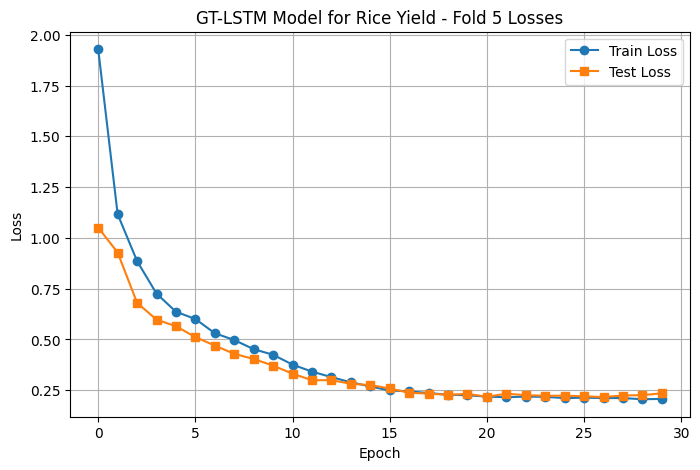


Fold 6/10 - Test Years: [np.int64(2013), np.int64(2014)]
Fold 6 Epoch [1/30] - Train Loss: 2.0396, Test Loss: 1.1946, Train RMSE: 1.4281, Test RMSE: 1.0930, Train R²: -0.8870, Test R²: -0.1040
Fold 6 Epoch [2/30] - Train Loss: 1.0463, Test Loss: 0.8263, Train RMSE: 1.0229, Test RMSE: 0.9090, Train R²: 0.0320, Test R²: 0.2364
Fold 6 Epoch [3/30] - Train Loss: 0.7536, Test Loss: 0.6607, Train RMSE: 0.8681, Test RMSE: 0.8128, Train R²: 0.3028, Test R²: 0.3894
Fold 6 Epoch [4/30] - Train Loss: 0.6795, Test Loss: 0.5806, Train RMSE: 0.8243, Test RMSE: 0.7619, Train R²: 0.3713, Test R²: 0.4635
Fold 6 Epoch [5/30] - Train Loss: 0.6184, Test Loss: 0.5251, Train RMSE: 0.7864, Test RMSE: 0.7246, Train R²: 0.4279, Test R²: 0.5148
Fold 6 Epoch [6/30] - Train Loss: 0.5830, Test Loss: 0.4946, Train RMSE: 0.7636, Test RMSE: 0.7033, Train R²: 0.4606, Test R²: 0.5430
Fold 6 Epoch [7/30] - Train Loss: 0.5305, Test Loss: 0.4498, Train RMSE: 0.7284, Test RMSE: 0.6707, Train R²: 0.5092, Test R²: 0.5843
Fo

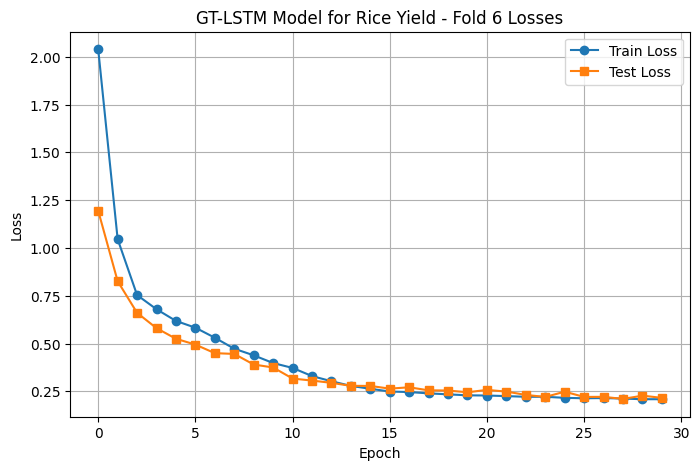


Fold 7/10 - Test Years: [np.int64(2015), np.int64(2016)]
Fold 7 Epoch [1/30] - Train Loss: 1.9850, Test Loss: 1.2165, Train RMSE: 1.4089, Test RMSE: 1.1030, Train R²: -0.8197, Test R²: -0.2051
Fold 7 Epoch [2/30] - Train Loss: 0.9703, Test Loss: 0.8385, Train RMSE: 0.9850, Test RMSE: 0.9157, Train R²: 0.1105, Test R²: 0.1693
Fold 7 Epoch [3/30] - Train Loss: 0.7334, Test Loss: 0.7183, Train RMSE: 0.8564, Test RMSE: 0.8475, Train R²: 0.3276, Test R²: 0.2885
Fold 7 Epoch [4/30] - Train Loss: 0.6388, Test Loss: 0.6615, Train RMSE: 0.7992, Test RMSE: 0.8133, Train R²: 0.4144, Test R²: 0.3447
Fold 7 Epoch [5/30] - Train Loss: 0.5774, Test Loss: 0.6185, Train RMSE: 0.7599, Test RMSE: 0.7864, Train R²: 0.4706, Test R²: 0.3874
Fold 7 Epoch [6/30] - Train Loss: 0.5330, Test Loss: 0.5496, Train RMSE: 0.7301, Test RMSE: 0.7413, Train R²: 0.5114, Test R²: 0.4556
Fold 7 Epoch [7/30] - Train Loss: 0.4895, Test Loss: 0.5303, Train RMSE: 0.6996, Test RMSE: 0.7282, Train R²: 0.5513, Test R²: 0.4747
Fo

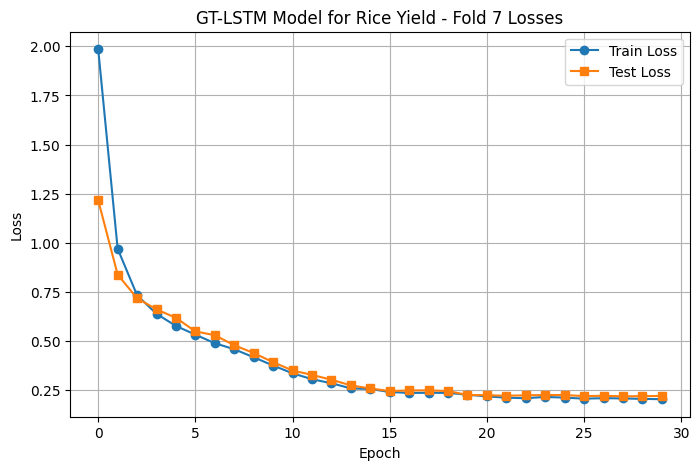


Fold 8/10 - Test Years: [np.int64(2017), np.int64(2018)]
Fold 8 Epoch [1/30] - Train Loss: 1.7297, Test Loss: 1.0804, Train RMSE: 1.3152, Test RMSE: 1.0394, Train R²: -0.5999, Test R²: -0.0257
Fold 8 Epoch [2/30] - Train Loss: 0.9737, Test Loss: 0.6724, Train RMSE: 0.9868, Test RMSE: 0.8200, Train R²: 0.0994, Test R²: 0.3617
Fold 8 Epoch [3/30] - Train Loss: 0.7318, Test Loss: 0.5781, Train RMSE: 0.8555, Test RMSE: 0.7603, Train R²: 0.3231, Test R²: 0.4512
Fold 8 Epoch [4/30] - Train Loss: 0.6484, Test Loss: 0.5264, Train RMSE: 0.8052, Test RMSE: 0.7255, Train R²: 0.4002, Test R²: 0.5002
Fold 8 Epoch [5/30] - Train Loss: 0.5994, Test Loss: 0.4616, Train RMSE: 0.7742, Test RMSE: 0.6794, Train R²: 0.4456, Test R²: 0.5617
Fold 8 Epoch [6/30] - Train Loss: 0.5439, Test Loss: 0.4120, Train RMSE: 0.7375, Test RMSE: 0.6419, Train R²: 0.4969, Test R²: 0.6088
Fold 8 Epoch [7/30] - Train Loss: 0.4886, Test Loss: 0.3821, Train RMSE: 0.6990, Test RMSE: 0.6182, Train R²: 0.5481, Test R²: 0.6372
Fo

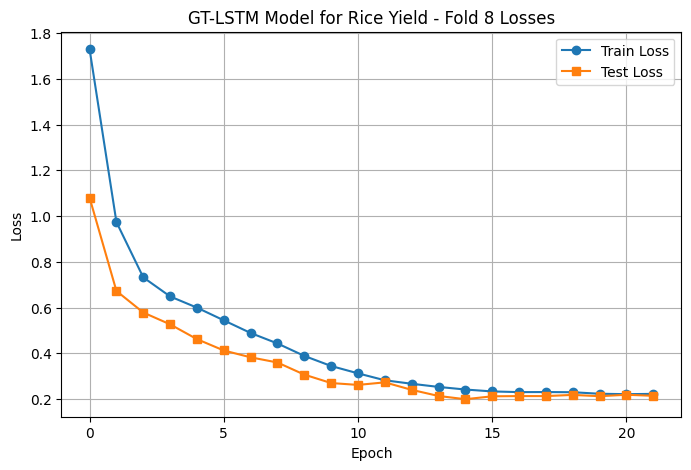


Fold 9/10 - Test Years: [np.int64(2019), np.int64(2020)]
Fold 9 Epoch [1/30] - Train Loss: 1.7971, Test Loss: 1.2135, Train RMSE: 1.3406, Test RMSE: 1.1016, Train R²: -0.6974, Test R²: -0.0731
Fold 9 Epoch [2/30] - Train Loss: 1.0590, Test Loss: 1.0734, Train RMSE: 1.0291, Test RMSE: 1.0360, Train R²: -0.0002, Test R²: 0.0508
Fold 9 Epoch [3/30] - Train Loss: 0.8038, Test Loss: 0.8513, Train RMSE: 0.8966, Test RMSE: 0.9227, Train R²: 0.2408, Test R²: 0.2472
Fold 9 Epoch [4/30] - Train Loss: 0.6771, Test Loss: 0.7402, Train RMSE: 0.8229, Test RMSE: 0.8603, Train R²: 0.3604, Test R²: 0.3455
Fold 9 Epoch [5/30] - Train Loss: 0.5935, Test Loss: 0.7260, Train RMSE: 0.7704, Test RMSE: 0.8520, Train R²: 0.4395, Test R²: 0.3581
Fold 9 Epoch [6/30] - Train Loss: 0.5420, Test Loss: 0.6814, Train RMSE: 0.7362, Test RMSE: 0.8255, Train R²: 0.4881, Test R²: 0.3974
Fold 9 Epoch [7/30] - Train Loss: 0.4886, Test Loss: 0.6529, Train RMSE: 0.6990, Test RMSE: 0.8080, Train R²: 0.5385, Test R²: 0.4226
F

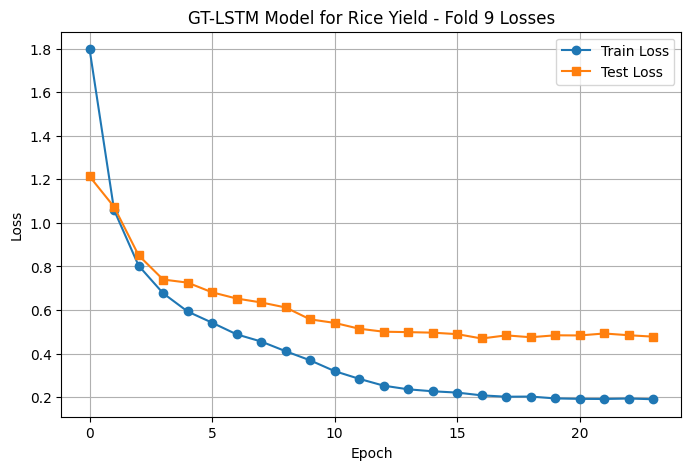


Fold 10/10 - Test Years: [np.int64(2021), np.int64(2022)]
Fold 10 Epoch [1/30] - Train Loss: 1.5219, Test Loss: 0.8491, Train RMSE: 1.2337, Test RMSE: 0.9214, Train R²: -0.3916, Test R²: -0.0593
Fold 10 Epoch [2/30] - Train Loss: 0.9915, Test Loss: 0.6107, Train RMSE: 0.9957, Test RMSE: 0.7814, Train R²: 0.0934, Test R²: 0.2381
Fold 10 Epoch [3/30] - Train Loss: 0.7564, Test Loss: 0.5445, Train RMSE: 0.8697, Test RMSE: 0.7379, Train R²: 0.3084, Test R²: 0.3206
Fold 10 Epoch [4/30] - Train Loss: 0.6640, Test Loss: 0.4321, Train RMSE: 0.8148, Test RMSE: 0.6573, Train R²: 0.3929, Test R²: 0.4609
Fold 10 Epoch [5/30] - Train Loss: 0.6252, Test Loss: 0.4028, Train RMSE: 0.7907, Test RMSE: 0.6346, Train R²: 0.4283, Test R²: 0.4975
Fold 10 Epoch [6/30] - Train Loss: 0.5784, Test Loss: 0.3621, Train RMSE: 0.7605, Test RMSE: 0.6017, Train R²: 0.4712, Test R²: 0.5482
Fold 10 Epoch [7/30] - Train Loss: 0.5372, Test Loss: 0.3433, Train RMSE: 0.7329, Test RMSE: 0.5859, Train R²: 0.5088, Test R²: 0

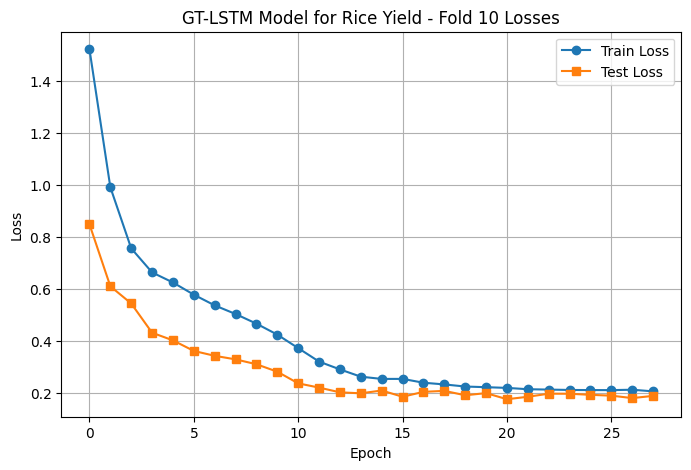


Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4579 (±0.0097)
Average Train R²: 0.8064 (±0.0073)
Average Test RMSE: 0.4726 (±0.0783)
Average Test R²: 0.7737 (±0.0709)
Cross-validation results saved to /content/gt_lstm_rice_yield_predictions.csv

District-wise Metrics:
Average RMSE: 0.4171 (±0.2258)
Average R²: 0.1315 (±0.4371)
Number of Negative R² Districts: 93
Worst 5 Districts by R²:
            District      RMSE        R2       MAE
76   Fatehgarh Sahib  0.430193 -2.120776  0.316254
7           Amritsar  0.508512 -1.873741  0.326308
126       Kapurthala  0.437740 -1.524260  0.307410
275              Una  0.387818 -1.232990  0.313915
161       Malappuram  0.238933 -1.209092  0.176324

Top 5 districts connected to District Amritsar (Index 7):
  District Kapurthala (Index 126): Weight = 0.505
  District Gurdaspur (Index 91): Weight = 0.503
  District Jalandhar (Index 107): Weight = 0.503
  District Moga (Index 173): Weight = 0.503
  District Hoshiar

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from math import radians, sin, cos, sqrt, atan2
import plotly.graph_objects as go

# Set seeds for reproducibility
SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Parameters
num_districts = 292
num_years = 23
climate_features = 36
rs_features = 16

# Load and preprocess data
climate_data = pd.read_csv('/content/cp_sowing_month_cp.csv')
climate_features_cols = [col for col in climate_data.columns if col not in ['District', 'year']]
climate_data_values = climate_data[climate_features_cols].values
scaler_cp = StandardScaler()
climate_data_normalized = scaler_cp.fit_transform(climate_data_values)
climate_data_reshaped = climate_data_normalized.reshape(num_years, num_districts, 4, 9).transpose(0, 1, 2, 3)
climate_data_tensor = torch.tensor(climate_data_reshaped, dtype=torch.float32)

rs_data = pd.read_csv('/content/rs_sowing_month_rs.csv')
rs_features_cols = [col for col in rs_data.columns if col not in ['District', 'year']]
rs_data_values = rs_data[rs_features_cols].values
scaler_rs = StandardScaler()
rs_data_normalized = scaler_rs.fit_transform(rs_data_values)
rs_data_reshaped = rs_data_normalized.reshape(num_years, num_districts, 4, 4).transpose(0, 1, 2, 3)
rs_data_tensor = torch.tensor(rs_data_reshaped, dtype=torch.float32)

yield_data = pd.read_csv('/content/detrended_rice_district_yield_sens_slope.csv')
district_names = yield_data['District'].unique()
district_name_to_index = {name: idx for idx, name in enumerate(district_names)}
yield_data['District'] = yield_data['District'].map(district_name_to_index)
yield_values = yield_data[['Year', 'Detrended_Yield', 'District', 'Trend', 'Actual']].values
years = yield_values[:, 0].astype(int)
detrended_yields = yield_values[:, 1]
districts = yield_values[:, 2].astype(int)
trends = yield_values[:, 3]
actual_yields = yield_values[:, 4]
district_mapping_df = pd.DataFrame(list(district_name_to_index.items()), columns=['District_Name', 'District_Index'])
district_mapping_df.to_csv('/content/district_name_to_index_rice.csv', index=False)

district_yields = np.zeros((num_districts, num_years))
trends_per_district = np.zeros((num_districts, num_years))
actual_yields_per_district = np.zeros((num_districts, num_years))
for i in range(len(years)):
    district_index = districts[i]
    year_index = years[i] - 2000
    district_yields[district_index, year_index] = detrended_yields[i]
    trends_per_district[district_index, year_index] = trends[i]
    actual_yields_per_district[district_index, year_index] = actual_yields[i]

district_yields_tensor = torch.tensor(district_yields, dtype=torch.float32)
trends_tensor = torch.tensor(trends_per_district, dtype=torch.float32)
actual_yields_tensor = torch.tensor(actual_yields_per_district, dtype=torch.float32)

# Function for consecutive GroupKFold splits
def consecutive_group_kfold(df, n_splits=7):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)
    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define the GT-LSTM Model
class GTLSTMYieldPrediction(nn.Module):
    def __init__(self, num_districts=292, climate_features=36, rs_features=16,
                 hidden_dim=512, embedding_size=32, num_layers=2, heads=1):
        super(GTLSTMYieldPrediction, self).__init__()
        self.num_districts = num_districts
        self.embedding_size = embedding_size
        self.heads = heads

        self.climate_lstm = nn.LSTM(input_size=9, hidden_size=hidden_dim,
                                    num_layers=num_layers, batch_first=True)
        self.rs_lstm = nn.LSTM(input_size=4, hidden_size=hidden_dim,
                               num_layers=num_layers, batch_first=True)
        self.dense = nn.Sequential(
            nn.Linear(hidden_dim * 2, embedding_size),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.LayerNorm(embedding_size)
        )
        self.gat1 = GATConv(in_channels=embedding_size, out_channels=embedding_size // heads, heads=heads, dropout=0.2)
        self.gat2 = GATConv(in_channels=embedding_size, out_channels=embedding_size, heads=1, dropout=0.2)
        self.norm2 = nn.LayerNorm(embedding_size)
        self.yield_mlp = nn.Sequential(
            nn.Linear(embedding_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

        try:
            districts_df = pd.read_csv('/content/district_centroid_file.csv')
            # Check for lat/lon columns
            lat_col = next((col for col in districts_df.columns if 'lat' in col.lower()), 'centroid_x')
            lon_col = next((col for col in districts_df.columns if 'lon' in col.lower()), 'centroid_y')
            districts_df = districts_df.rename(columns={lat_col: 'centroid_x', lon_col: 'centroid_y'})

            # Swap centroid_x and centroid_y
            districts_df['temp'] = districts_df['centroid_x']
            districts_df['centroid_x'] = districts_df['centroid_y']  # centroid_x now latitude
            districts_df['centroid_y'] = districts_df['temp']       # centroid_y now longitude
            districts_df = districts_df.drop(columns=['temp'])

            # Validate coordinates
            districts_df = districts_df.dropna(subset=['centroid_x', 'centroid_y'])
            valid_districts = districts_df[
                (districts_df['centroid_x'].between(8, 37)) &
                (districts_df['centroid_y'].between(68, 97))
            ]
            if len(valid_districts) < len(districts_df):
                print(f"Warning: {len(districts_df) - len(valid_districts)} invalid coordinates removed.")
                districts_df = valid_districts

            district_to_centroid = dict(zip(np.arange(len(districts_df)),
                                         districts_df[['centroid_x', 'centroid_y']].values))
            if len(district_to_centroid) != num_districts:
                print(f"Warning: Number of districts in centroid file ({len(district_to_centroid)}) does not match num_districts ({num_districts}). Initializing edge_weights randomly.")
                self.edge_weights = nn.Parameter(torch.randn(num_districts, num_districts))
            else:
                distance_matrix = np.zeros((num_districts, num_districts))
                for i in range(num_districts):
                    for j in range(num_districts):
                        if i != j and i in district_to_centroid and j in district_to_centroid:
                            distance_matrix[i, j] = haversine_distance(
                                district_to_centroid[i][0], district_to_centroid[i][1],
                                district_to_centroid[j][0], district_to_centroid[j][1]
                            )
                        else:
                            distance_matrix[i, j] = np.inf
                MAX_DISTANCE_KM = 100
                edge_weights_init = np.where(distance_matrix <= MAX_DISTANCE_KM,
                                            1 / (distance_matrix + 1e-6), 0)
                self.edge_weights = nn.Parameter(torch.tensor(edge_weights_init, dtype=torch.float32))
        except FileNotFoundError:
            print("Warning: district_centroid_file.csv not found. Initializing edge_weights randomly.")
            self.edge_weights = nn.Parameter(torch.randn(num_districts, num_districts))

        self.residual_scale = nn.Parameter(torch.ones(num_districts, 1))

    def forward(self, climate_data, rs_data):
        climate_out, _ = self.climate_lstm(climate_data)
        rs_out, _ = self.rs_lstm(rs_data)
        climate_emb = climate_out[:, -1, :]
        rs_emb = rs_out[:, -1, :]
        combined_emb = torch.cat([climate_emb, rs_emb], dim=-1)
        dense_out = self.dense(combined_emb)
        adj_matrix = torch.sigmoid(self.edge_weights)
        adj_matrix = adj_matrix * (1 - torch.eye(self.num_districts, device=adj_matrix.device))
        edge_index = (adj_matrix > 0.5).nonzero(as_tuple=False).t().contiguous()
        edge_index = edge_index[:, edge_index[0] != edge_index[1]]
        gat_out = self.gat1(dense_out, edge_index)
        gat_out = torch.relu(gat_out)
        gat_out = self.gat2(gat_out, edge_index)
        gat_out = torch.relu(gat_out)
        gat_out = self.norm2(gat_out)
        scaled_residual = dense_out * self.residual_scale
        combined_out = gat_out + scaled_residual
        district_yields = self.yield_mlp(combined_out)
        return district_yields

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# # Combined loss function
# class CombinedLoss(nn.Module):
#     def __init__(self, alpha=0.5):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.mae = nn.L1Loss()
#         self.alpha = alpha
#     def forward(self, pred, target):
#         return self.alpha * self.mse(pred, target) + (1 - self.alpha) * self.mae(pred, target)

# Cross-validation setup
n_splits = 10
fold_train_rmses = []
fold_train_r2s = []
fold_test_rmses = []
fold_test_r2s = []
all_results = []
fold_edge_weights = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cross-validation loop using consecutive_group_kfold
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(yield_data, n_splits=n_splits)):
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"\nFold {fold + 1}/{n_splits} - Test Years: {test_years}")

    # Convert years to tensor indices
    train_indices = np.array([y - 2000 for y in train_years])
    test_indices = np.array([y - 2000 for y in test_years])

    # Validate fold coverage
    if len(set(train_years + test_years)) != num_years:
        print(f"Error: Fold {fold + 1} does not cover all years.")
        raise ValueError("Fold configuration invalid")

    train_climate = climate_data_tensor[train_indices]
    train_rs = rs_data_tensor[train_indices]
    train_yields = district_yields_tensor[:, train_indices]
    train_trends = trends_tensor[:, train_indices]
    train_actual = actual_yields_tensor[:, train_indices]
    test_climate = climate_data_tensor[test_indices]
    test_rs = rs_data_tensor[test_indices]
    test_yields = district_yields_tensor[:, test_indices]
    test_trends = trends_tensor[:, test_indices]
    test_actual = actual_yields_tensor[:, test_indices]

    model = GTLSTMYieldPrediction().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.MSELoss()

    patience = 7
    min_delta = 0.001
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    train_losses = []
    test_losses = []

    num_epochs = 25
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_targets = []
        for year_idx in range(len(train_indices)):
            climate_batch = train_climate[year_idx].to(device)
            rs_batch = train_rs[year_idx].to(device)
            trend_batch = train_trends[:, year_idx:year_idx+1].to(device)
            actual_batch = train_actual[:, year_idx:year_idx+1].to(device)
            pred = model(climate_batch, rs_batch)
            predicted_yields = pred + trend_batch
            loss = criterion(predicted_yields, actual_batch)
            train_loss += loss.item()
            all_train_preds.extend(predicted_yields.detach().cpu().numpy())
            all_train_targets.extend(actual_batch.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_indices)
        train_losses.append(avg_train_loss)
        train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_preds))
        train_r2 = r2_score(all_train_targets, all_train_preds)

        model.eval()
        test_loss = 0
        all_test_preds = []
        all_test_targets = []
        with torch.no_grad():
            for year_idx in range(len(test_indices)):
                climate_batch = test_climate[year_idx].to(device)
                rs_batch = test_rs[year_idx].to(device)
                trend_batch = test_trends[:, year_idx:year_idx+1].to(device)
                actual_batch = test_actual[:, year_idx:year_idx+1].to(device)
                pred = model(climate_batch, rs_batch)
                predicted_yields = pred + trend_batch
                loss = criterion(predicted_yields, actual_batch)
                test_loss += loss.item()
                all_test_preds.extend(predicted_yields.cpu().numpy())
                all_test_targets.extend(actual_batch.cpu().numpy())

        avg_test_loss = test_loss / len(test_indices)
        test_losses.append(avg_test_loss)
        test_rmse = np.sqrt(mean_squared_error(all_test_targets, all_test_preds))
        test_r2 = r2_score(all_test_targets, all_test_preds)

        print(f"Fold {fold + 1} Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, "
              f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

        if avg_test_loss < best_val_loss - min_delta:
            best_val_loss = avg_test_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    fold_edge_weights.append(model.edge_weights.detach().cpu().numpy())
    fold_train_rmses.append(train_rmse)
    fold_train_r2s.append(train_r2)
    fold_test_rmses.append(test_rmse)
    fold_test_r2s.append(test_r2)

    for year_idx, year in enumerate(test_indices):
        preds = all_test_preds[year_idx * num_districts:(year_idx + 1) * num_districts]
        targets = all_test_targets[year_idx * num_districts:(year_idx + 1) * num_districts]
        for district in range(num_districts):
            actual_yield = actual_yields_per_district[district, year].item()
            predicted_yield = preds[district][0] if isinstance(preds[district], np.ndarray) else preds[district]
            all_results.append({
                'Fold': fold + 1,
                'Year': 2000 + year,
                'District': district_names[district],
                'Actual_Yield': actual_yield,
                'Predicted_Yield': predicted_yield
            })

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='s')
    plt.title(f'GT-LSTM Model for Rice Yield - Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'/content/fold_{fold + 1}_loss_plot.png')
    plt.close()

# Compute and print overall metrics
avg_train_rmse = np.mean(fold_train_rmses)
avg_train_r2 = np.mean(fold_train_r2s)
avg_test_rmse = np.mean(fold_test_rmses)
avg_test_r2 = np.mean(fold_test_r2s)

print("\nOverall Cross-Validation Metrics for Rice Yield Prediction:")
print(f"Average Train RMSE: {avg_train_rmse:.4f} (±{np.std(fold_train_rmses):.4f})")
print(f"Average Train R²: {avg_train_r2:.4f} (±{np.std(fold_train_r2s):.4f})")
print(f"Average Test RMSE: {avg_test_rmse:.4f} (±{np.std(fold_test_rmses):.4f})")
print(f"Average Test R²: {avg_test_r2:.4f} (±{np.std(fold_test_r2s):.4f})")

results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/gt_lstm_rice_yield_predictions.csv', index=False)
print(f"Cross-validation results saved to /content/gt_lstm_rice_yield_predictions.csv")

# Compute district-wise metrics
district_metrics = []
for district_idx in range(num_districts):
    district_actual = actual_yields_per_district[district_idx]
    district_results = results_df[results_df['District'] == district_names[district_idx]]
    district_pred = np.zeros(num_years)
    for year in range(num_years):
        year_result = district_results[district_results['Year'] == 2000 + year]
        if not year_result.empty:
            district_pred[year] = year_result['Predicted_Yield'].iloc[0]
        else:
            model.eval()
            with torch.no_grad():
                climate_batch = climate_data_tensor[year:year+1, district_idx:district_idx+1].to(device)
                rs_batch = rs_data_tensor[year:year+1, district_idx:district_idx+1].to(device)
                trend_batch = trends_tensor[district_idx:district_idx+1, year:year+1].to(device)
                pred = model(climate_batch.squeeze(0), rs_batch.squeeze(0))
                district_pred[year] = (pred + trend_batch).cpu().numpy().item()
    rmse = np.sqrt(mean_squared_error(district_actual, district_pred))
    r2 = r2_score(district_actual, district_pred)
    mae = np.mean(np.abs(district_actual - district_pred))
    district_metrics.append({
        'District': district_names[district_idx],
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    })

district_metrics_df = pd.DataFrame(district_metrics)
district_metrics_df.to_csv('/content/district_metrics_rice.csv', index=False)
print("\nDistrict-wise Metrics:")
print(f"Average RMSE: {district_metrics_df['RMSE'].mean():.4f} (±{district_metrics_df['RMSE'].std():.4f})")
print(f"Average R²: {district_metrics_df['R2'].mean():.4f} (±{district_metrics_df['R2'].std():.4f})")
print(f"Number of Negative R² Districts: {(district_metrics_df['R2'] < 0).sum()}")
print("Worst 5 Districts by R²:")
print(district_metrics_df.sort_values('R2').head(5)[['District', 'RMSE', 'R2', 'MAE']])

# Plot connections for district 7
avg_edge_weights = np.mean(fold_edge_weights, axis=0)
adj_matrix = torch.sigmoid(torch.tensor(avg_edge_weights, dtype=torch.float32))
adj_matrix = adj_matrix * (1 - torch.eye(num_districts))
edge_index = (adj_matrix > 0.5).nonzero(as_tuple=False).t().cpu().numpy()
edge_weights_map = adj_matrix[edge_index[0], edge_index[1]].cpu().numpy()

try:
    districts_df = pd.read_csv('/content/district_centroid_file.csv')
    # Check for lat/lon columns
    lat_col = next((col for col in districts_df.columns if 'lat' in col.lower()), 'centroid_x')
    lon_col = next((col for col in districts_df.columns if 'lon' in col.lower()), 'centroid_y')
    districts_df = districts_df.rename(columns={lat_col: 'centroid_x', lon_col: 'centroid_y'})

    # Swap centroid_x and centroid_y
    districts_df['temp'] = districts_df['centroid_x']
    districts_df['centroid_x'] = districts_df['centroid_y']  # centroid_x now latitude
    districts_df['centroid_y'] = districts_df['temp']       # centroid_y now longitude
    districts_df = districts_df.drop(columns=['temp'])

    # Validate coordinates
    districts_df = districts_df.dropna(subset=['centroid_x', 'centroid_y'])
    valid_districts = districts_df[
        (districts_df['centroid_x'].between(8, 37)) &
        (districts_df['centroid_y'].between(68, 97))
    ]
    if len(valid_districts) < len(districts_df):
        print(f"Warning: {len(districts_df) - len(valid_districts)} invalid coordinates removed.")
        districts_df = valid_districts

    district_to_centroid = dict(zip(np.arange(len(districts_df)),
                                   districts_df[['centroid_x', 'centroid_y']].values))
    if len(district_to_centroid) != num_districts:
        print(f"Warning: Number of districts in centroid file ({len(district_to_centroid)}) does not match num_districts ({num_districts}). Skipping visualization.")
        raise ValueError("Mismatch in district count")
except (FileNotFoundError, ValueError) as e:
    print(f"Error: {e}. Cannot generate Mapbox visualization without valid centroid data.")
else:
    district_1 = 7
    connected_indices = edge_index[1][edge_index[0] == district_1]
    if len(connected_indices) > 0:
        edge_mask = edge_index[0] == district_1
        relevant_weights = edge_weights_map[edge_mask]
        relevant_targets = connected_indices
        top_5_indices = relevant_targets[np.argsort(relevant_weights)[::-1][:min(5, len(relevant_weights))]]
        print(f"\nTop 5 districts connected to District {district_names[district_1]} (Index {district_1}):")
        for idx, weight in zip(top_5_indices, [relevant_weights[np.where(relevant_targets == i)[0][0]] for i in top_5_indices]):
            print(f"  District {district_names[idx]} (Index {idx}): Weight = {weight:.3f}")
    else:
        top_5_indices = np.array([], dtype=int)
        print(f"No connections found for District {district_names[district_1]} (Index {district_1}).")

    district_1_centroid = district_to_centroid[district_1]
    connected_centroids = [district_to_centroid[idx] for idx in top_5_indices if idx in district_to_centroid]
    num_connected_districts = len(top_5_indices)

    lat = [district_1_centroid[0]] + [centroid[0] for centroid in connected_centroids]
    lon = [district_1_centroid[1]] + [centroid[1] for centroid in connected_centroids]
    names = [district_names[district_1]] + [district_names[idx] for idx in top_5_indices if idx < len(district_names)]
    weights = [1.0] + [relevant_weights[np.where(relevant_targets == idx)[0][0]] for idx in top_5_indices if idx in relevant_targets]
    selected_weights = [round(w, 2) for w in weights]

    fig = go.Figure()
    for i in range(len(connected_centroids)):
        delta_lat = connected_centroids[i][0] - district_1_centroid[0]
        delta_lon = connected_centroids[i][1] - district_1_centroid[1]
        distance = np.sqrt(delta_lat**2 + delta_lon**2)
        if distance == 0:
            continue
        direction_lat = delta_lat / distance
        direction_lon = delta_lon / distance
        offset = 0.1
        start_lat = district_1_centroid[0] + direction_lat * offset
        start_lon = district_1_centroid[1] + direction_lon * offset
        fig.add_trace(go.Scattermapbox(
            lat=[start_lat, connected_centroids[i][0]],
            lon=[start_lon, connected_centroids[i][1]],
            mode="lines",
            line=dict(width=1, color="gray"),
            hoverinfo="none",
            showlegend=False
        ))

    fig.add_trace(go.Scattermapbox(
        lat=[centroid[0] for centroid in connected_centroids],
        lon=[centroid[1] for centroid in connected_centroids],
        mode="markers+text",
        marker=dict(size=12, color="blue"),
        text=selected_weights[1:],
        textfont=dict(size=12, color="black"),
        textposition="top center",
        name="Connected Districts"
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[district_1_centroid[0]],
        lon=[district_1_centroid[1]],
        mode="markers+text",
        marker=dict(size=22, color="red", opacity=0.8),
        text=[str(num_connected_districts)],
        textfont=dict(size=14, color="black"),
        textposition="middle center",
        name=f"{district_names[district_1]} Centroid"
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": np.mean(lat), "lon": np.mean(lon)},
        mapbox_zoom=5,
        showlegend=True,
        title=f'Top 5 Connections for District {district_names[district_1]} with Distance Weights',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
    )

    fig.show()

In [ ]:
# Plot connections for district 7
avg_edge_weights = np.mean(fold_edge_weights, axis=0)
adj_matrix = torch.sigmoid(torch.tensor(avg_edge_weights, dtype=torch.float32))
adj_matrix = adj_matrix * (1 - torch.eye(num_districts))
edge_index = (adj_matrix > 0.5).nonzero(as_tuple=False).t().cpu().numpy()
edge_weights_map = adj_matrix[edge_index[0], edge_index[1]].cpu().numpy()

try:
    districts_df = pd.read_csv('/content/district_centroid_file.csv')
    # Check for lat/lon columns
    lat_col = next((col for col in districts_df.columns if 'lat' in col.lower()), 'centroid_x')
    lon_col = next((col for col in districts_df.columns if 'lon' in col.lower()), 'centroid_y')
    districts_df = districts_df.rename(columns={lat_col: 'centroid_x', lon_col: 'centroid_y'})

    # Swap centroid_x and centroid_y
    districts_df['temp'] = districts_df['centroid_x']
    districts_df['centroid_x'] = districts_df['centroid_y']  # centroid_x now latitude
    districts_df['centroid_y'] = districts_df['temp']       # centroid_y now longitude
    districts_df = districts_df.drop(columns=['temp'])

    # Validate coordinates
    districts_df = districts_df.dropna(subset=['centroid_x', 'centroid_y'])
    valid_districts = districts_df[
        (districts_df['centroid_x'].between(8, 37)) &
        (districts_df['centroid_y'].between(68, 97))
    ]
    if len(valid_districts) < len(districts_df):
        print(f"Warning: {len(districts_df) - len(valid_districts)} invalid coordinates removed.")
        districts_df = valid_districts

    district_to_centroid = dict(zip(np.arange(len(districts_df)),
                                   districts_df[['centroid_x', 'centroid_y']].values))
    if len(district_to_centroid) != num_districts:
        print(f"Warning: Number of districts in centroid file ({len(district_to_centroid)}) does not match num_districts ({num_districts}). Skipping visualization.")
        raise ValueError("Mismatch in district count")
except (FileNotFoundError, ValueError) as e:
    print(f"Error: {e}. Cannot generate Mapbox visualization without valid centroid data.")
else:
    district_1 = 12
    connected_indices = edge_index[1][edge_index[0] == district_1]
    if len(connected_indices) > 0:
        edge_mask = edge_index[0] == district_1
        relevant_weights = edge_weights_map[edge_mask]
        relevant_targets = connected_indices
        top_5_indices = relevant_targets[np.argsort(relevant_weights)[::-1][:min(5, len(relevant_weights))]]
        print(f"\nTop 5 districts connected to District {district_names[district_1]} (Index {district_1}):")
        for idx, weight in zip(top_5_indices, [relevant_weights[np.where(relevant_targets == i)[0][0]] for i in top_5_indices]):
            print(f"  District {district_names[idx]} (Index {idx}): Weight = {weight:.3f}")
    else:
        top_5_indices = np.array([], dtype=int)
        print(f"No connections found for District {district_names[district_1]} (Index {district_1}).")

    district_1_centroid = district_to_centroid[district_1]
    connected_centroids = [district_to_centroid[idx] for idx in top_5_indices if idx in district_to_centroid]
    num_connected_districts = len(top_5_indices)

    lat = [district_1_centroid[0]] + [centroid[0] for centroid in connected_centroids]
    lon = [district_1_centroid[1]] + [centroid[1] for centroid in connected_centroids]
    names = [district_names[district_1]] + [district_names[idx] for idx in top_5_indices if idx < len(district_names)]
    weights = [1.0] + [relevant_weights[np.where(relevant_targets == idx)[0][0]] for idx in top_5_indices if idx in relevant_targets]
    selected_weights = [round(w, 2) for w in weights]

    fig = go.Figure()
    for i in range(len(connected_centroids)):
        delta_lat = connected_centroids[i][0] - district_1_centroid[0]
        delta_lon = connected_centroids[i][1] - district_1_centroid[1]
        distance = np.sqrt(delta_lat**2 + delta_lon**2)
        if distance == 0:
            continue
        direction_lat = delta_lat / distance
        direction_lon = delta_lon / distance
        offset = 0.1
        start_lat = district_1_centroid[0] + direction_lat * offset
        start_lon = district_1_centroid[1] + direction_lon * offset
        fig.add_trace(go.Scattermapbox(
            lat=[start_lat, connected_centroids[i][0]],
            lon=[start_lon, connected_centroids[i][1]],
            mode="lines",
            line=dict(width=1, color="gray"),
            hoverinfo="none",
            showlegend=False
        ))

    fig.add_trace(go.Scattermapbox(
        lat=[centroid[0] for centroid in connected_centroids],
        lon=[centroid[1] for centroid in connected_centroids],
        mode="markers+text",
        marker=dict(size=12, color="blue"),
        text=selected_weights[1:],
        textfont=dict(size=12, color="black"),
        textposition="top center",
        name="Connected Districts"
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[district_1_centroid[0]],
        lon=[district_1_centroid[1]],
        mode="markers+text",
        marker=dict(size=22, color="red", opacity=0.8),
        text=[str(num_connected_districts)],
        textfont=dict(size=14, color="black"),
        textposition="middle center",
        name=f"{district_names[district_1]} Centroid"
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": np.mean(lat), "lon": np.mean(lon)},
        mapbox_zoom=5,
        showlegend=True,
        title=f'Top 5 Connections for District {district_names[district_1]} with Distance Weights',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
    )

    fig.show()

No connections found for District Baghpat (Index 12).


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the centroid file
try:
    districts_df = pd.read_csv('/content/district_centroid_file.csv')
except FileNotFoundError:
    print("Error: /content/district_centroid_file.csv not found.")
    exit()

# Print column names and first few rows
print("Column names:", districts_df.columns.tolist())
print("\nFirst 5 rows of the centroid file:")
print(districts_df.head())

# Check for expected columns
expected_columns = ['centroid_x', 'centroid_y']
if not all(col in districts_df.columns for col in expected_columns):
    print("Warning: Expected columns 'centroid_x' and 'centroid_y' not found. Available columns:", districts_df.columns.tolist())
    # Attempt to infer lat/lon columns
    possible_lat_cols = [col for col in districts_df.columns if 'lat' in col.lower()]
    possible_lon_cols = [col for col in districts_df.columns if 'lon' in col.lower()]
    if len(possible_lat_cols) == 1 and len(possible_lon_cols) == 1:
        districts_df = districts_df.rename(columns={possible_lat_cols[0]: 'centroid_x', possible_lon_cols[0]: 'centroid_y'})
        print(f"Renamed columns {possible_lat_cols[0]} to 'centroid_x' and {possible_lon_cols[0]} to 'centroid_y'.")
    else:
        print("Error: Cannot infer latitude and longitude columns. Please ensure correct column names.")
        exit()

# Summary statistics for original coordinates
print("\nSummary statistics for centroid_x (assumed longitude) and centroid_y (assumed latitude):")
print(districts_df[['centroid_x', 'centroid_y']].describe())

# Swap centroid_x and centroid_y
districts_df['temp'] = districts_df['centroid_x']
districts_df['centroid_x'] = districts_df['centroid_y']  # centroid_x now latitude
districts_df['centroid_y'] = districts_df['temp']       # centroid_y now longitude
districts_df = districts_df.drop(columns=['temp'])

# Summary statistics after swap
print("\nSummary statistics after swapping (centroid_x as latitude, centroid_y as longitude):")
print(districts_df[['centroid_x', 'centroid_y']].describe())

# Check for valid coordinates (India: ~8–37°N latitude, 68–97°E longitude)
invalid_lat = districts_df[(districts_df['centroid_x'] < 8) | (districts_df['centroid_x'] > 37)]
invalid_lon = districts_df[(districts_df['centroid_y'] < 68) | (districts_df['centroid_y'] > 97)]
print(f"\nNumber of invalid latitudes (outside 8–37°N): {len(invalid_lat)}")
print(f"Number of invalid longitudes (outside 68–97°E): {len(invalid_lon)}")
if len(invalid_lat) > 0:
    print("Invalid latitude entries (after swap):")
    print(invalid_lat[['centroid_x', 'centroid_y']].head())
if len(invalid_lon) > 0:
    print("Invalid longitude entries (after swap):")
    print(invalid_lon[['centroid_x', 'centroid_y']].head())

# Plot all district centroids with swapped coordinates
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
    lat=districts_df['centroid_x'],  # Now latitude
    lon=districts_df['centroid_y'],  # Now longitude
    mode='markers+text',
    marker=dict(size=10, color='blue', opacity=0.7),
    text=[str(i) for i in range(len(districts_df))],  # Label points with district indices
    textposition='top center',
    name='District Centroids (Swapped)'
))

fig.update_layout(
    mapbox_style='open-street-map',
    mapbox_center={'lat': districts_df['centroid_x'].mean(), 'lon': districts_df['centroid_y'].mean()},
    mapbox_zoom=5,
    showlegend=True,
    title='All District Centroids (Swapped: centroid_x as Latitude, centroid_y as Longitude)',
    legend=dict(yanchor='top', y=0.99, xanchor='left', x=0.01)
)

fig.show()

Column names: ['State', 'district', 'centroid_x', 'centroid_y']

First 5 rows of the centroid file:
           State    district  centroid_x  centroid_y
0      Telangana    Adilabad   78.966698   19.254433
1        Gujarat   Ahmadabad   72.203300   22.727278
2    Maharashtra  Ahmednagar   74.645500   19.233217
3  Uttar Pradesh     Aligarh   78.077202   27.926165
4  Uttar Pradesh   Allahabad   81.964798   25.299889

Summary statistics for centroid_x (assumed longitude) and centroid_y (assumed latitude):
       centroid_x  centroid_y
count  292.000000  292.000000
mean    79.796411   22.156216
std      3.949787    6.424855
min     72.203300    8.606249
25%     76.755047   17.250472
50%     79.282951   23.316342
75%     82.607525   27.033155
max     89.080101   32.678322

Summary statistics after swapping (centroid_x as latitude, centroid_y as longitude):
       centroid_x  centroid_y
count  292.000000  292.000000
mean    22.156216   79.796411
std      6.424855    3.949787
min      8.60624

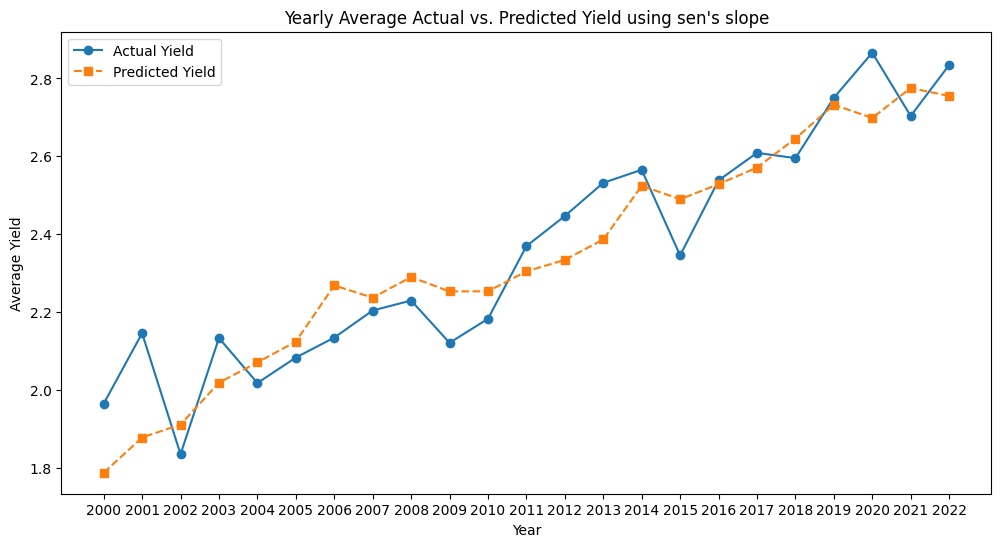

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the results file
results_df = pd.read_csv('/content/gt_lstm_rice_yield_predictions.csv')

# Group by year and compute mean actual and predicted yields
yearly_avg_yield = results_df.groupby('Year')[['Actual_Yield', 'Predicted_Yield']].mean().reset_index()

# Plot the actual vs predicted yield over the years
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_yield['Year'], yearly_avg_yield['Actual_Yield'], marker='o', linestyle='-', label='Actual Yield')
plt.plot(yearly_avg_yield['Year'], yearly_avg_yield['Predicted_Yield'], marker='s', linestyle='--', label='Predicted Yield')

# Formatting the plot
plt.xlabel('Year')
plt.ylabel('Average Yield')
plt.title('Yearly Average Actual vs. Predicted Yield using sen\'s slope')
plt.legend()
plt.xticks(yearly_avg_yield['Year'])  # Ensure all years appear as ticks
plt.show()


------------Yearly Metrics----------------
    Year      RMSE        R2
0   2000  0.433896  0.827862
1   2001  0.440252  0.761060
2   2002  0.399571  0.834820
3   2003  0.439842  0.715437
4   2004  0.397881  0.842343
5   2005  0.378263  0.828895
6   2006  0.344094  0.882569
7   2007  0.430292  0.827243
8   2008  0.632386  0.717059
9   2009  0.413046  0.854944
10  2010  0.390606  0.850986
11  2011  0.440265  0.819522
12  2012  0.524875  0.646201
13  2013  0.482373  0.790620
14  2014  0.446625  0.810462
15  2015  0.422543  0.850083
16  2016  0.513849  0.673795
17  2017  0.475173  0.781026
18  2018  0.449300  0.812274
19  2019  0.398223  0.814897
20  2020  0.892976  0.429721
21  2021  0.405718  0.809031
22  2022  0.462621  0.707803

------------Average Yearly Metrics----------------
Average yearly RMSE: 0.4615
Average yearly R²: 0.7778


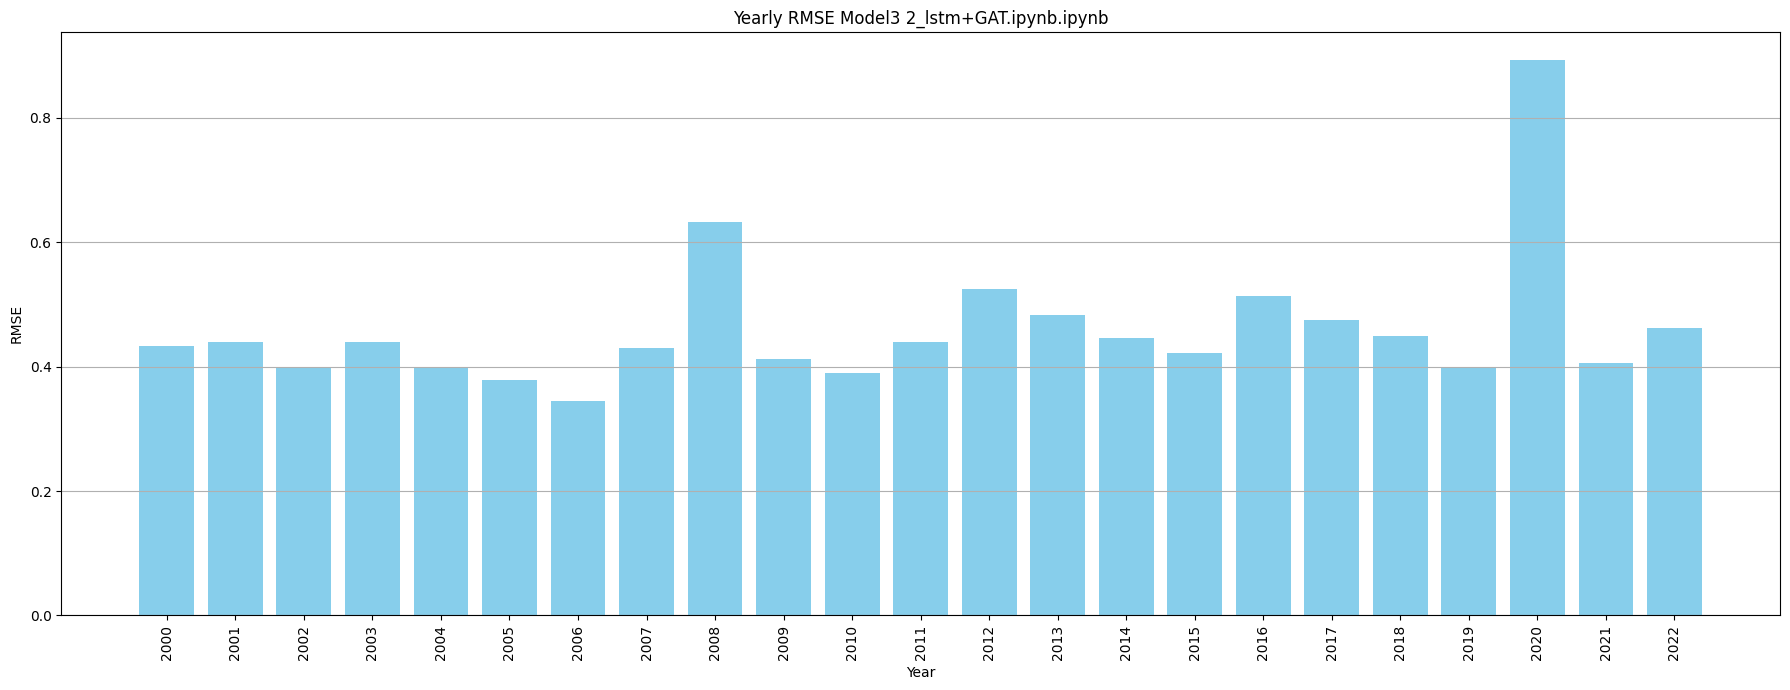

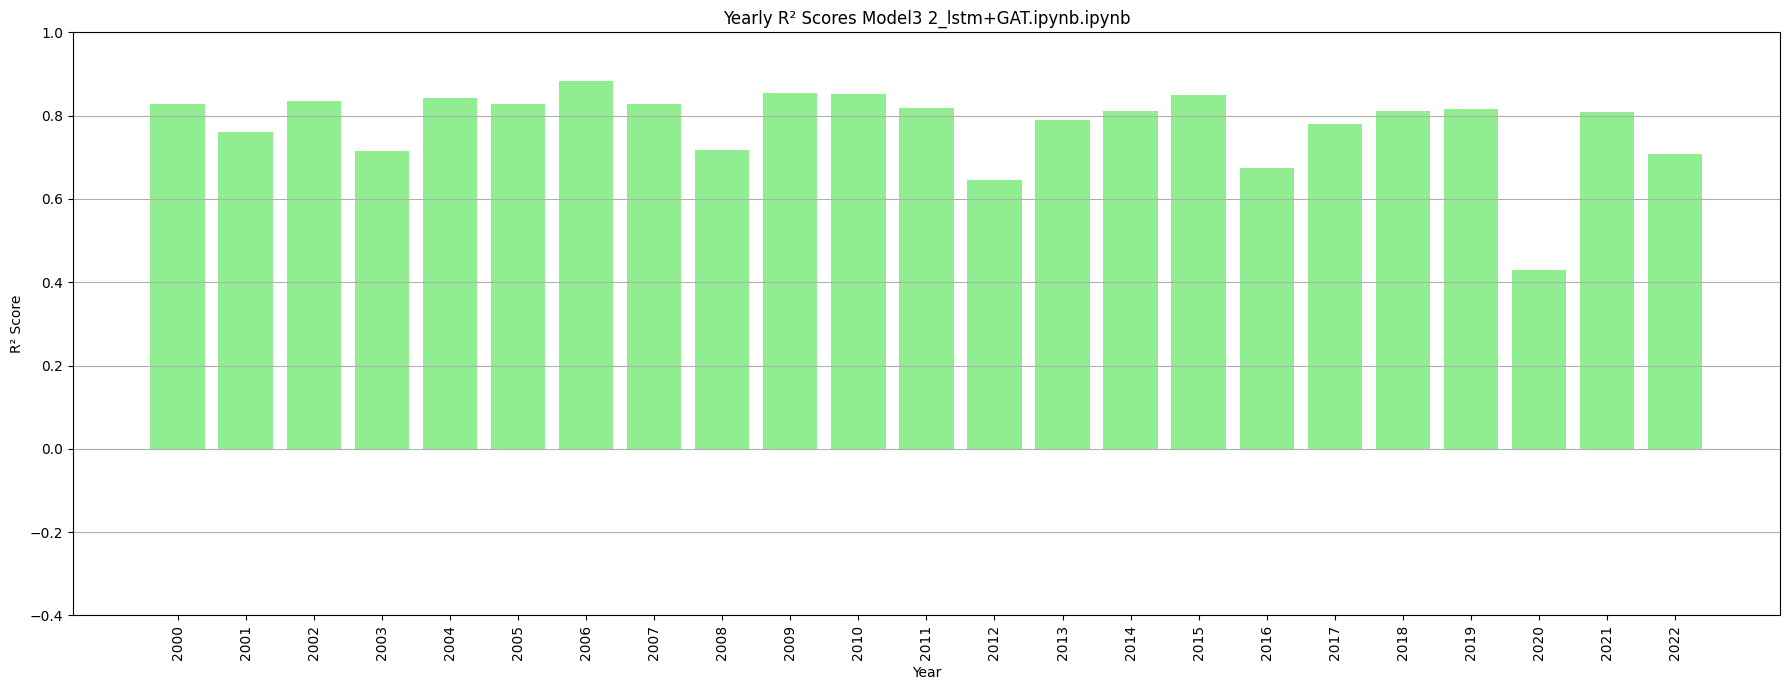

In [ ]:
# Load the results file
results_df = pd.read_csv('/content/gt_lstm_rice_yield_predictions.csv')

# Initialize dictionaries to store RMSE and R² for each year
yearly_rmse = {}
yearly_r2 = {}

# Group by year and calculate RMSE and R² for each year
for year, group in results_df.groupby('Year'):
    actual_yields = group['Actual_Yield'].values
    predicted_yields = group['Predicted_Yield'].values

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(actual_yields, predicted_yields))
    r2 = r2_score(actual_yields, predicted_yields)

    # Store the results in the dictionaries
    yearly_rmse[year] = rmse
    yearly_r2[year] = r2

# Convert the dictionaries to a DataFrame for easier viewing and visualization
yearly_metrics_df = pd.DataFrame({
    'Year': list(yearly_rmse.keys()),
    'RMSE': list(yearly_rmse.values()),
    'R2': list(yearly_r2.values())
})

# Save the yearly metrics to a CSV file
yearly_metrics_df.to_csv('/content/yearly_yield_metrics3.csv', index=False)

# Calculate and print the average yearly metrics separately
average_yearly_rmse = yearly_metrics_df['RMSE'].mean()
average_yearly_r2 = yearly_metrics_df['R2'].mean()

print("------------Yearly Metrics----------------")
print(yearly_metrics_df)
print("\n------------Average Yearly Metrics----------------")
print(f"Average yearly RMSE: {average_yearly_rmse:.4f}")
print(f"Average yearly R²: {average_yearly_r2:.4f}")

# Visualization of Yearly Metrics

# Yearly RMSE Plot
plt.figure(figsize=(18, 7))
plt.bar(yearly_metrics_df['Year'], yearly_metrics_df['RMSE'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('Yearly RMSE Model3 2_lstm+GAT')
plt.xticks(yearly_metrics_df['Year'], rotation=90)

plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Yearly R² Plot
plt.figure(figsize=(18, 7))
plt.bar(yearly_metrics_df['Year'], yearly_metrics_df['R2'], color='lightgreen')
plt.xlabel('Year')
plt.ylabel('R² Score')
plt.title('Yearly R² Scores Model3 2_lstm+GAT')
plt.xticks(yearly_metrics_df['Year'], rotation=90)
plt.ylim(-0.4, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


```
------------Average Yearly Metrics----------------
Average yearly RMSE: 0.4615
Average yearly R²: 0.7778
```


Fold 1/10 - Test Years: [np.int64(2000), np.int64(2001), np.int64(2002)]
Fold 1 Epoch [1/50] - Train Loss: 2.5372, Test Loss: 1.0735, Train RMSE: 1.5929, Test RMSE: 1.0361, Train R²: -1.3562, Test R²: -0.1029
Fold 1 Epoch [2/50] - Train Loss: 1.1309, Test Loss: 0.9579, Train RMSE: 1.0634, Test RMSE: 0.9787, Train R²: -0.0502, Test R²: 0.0159
Fold 1 Epoch [3/50] - Train Loss: 1.0684, Test Loss: 0.9018, Train RMSE: 1.0336, Test RMSE: 0.9496, Train R²: 0.0079, Test R²: 0.0736
Fold 1 Epoch [4/50] - Train Loss: 0.9117, Test Loss: 0.6194, Train RMSE: 0.9548, Test RMSE: 0.7870, Train R²: 0.1533, Test R²: 0.3637
Fold 1 Epoch [5/50] - Train Loss: 0.7010, Test Loss: 0.5635, Train RMSE: 0.8373, Test RMSE: 0.7506, Train R²: 0.3490, Test R²: 0.4211
Fold 1 Epoch [6/50] - Train Loss: 0.6366, Test Loss: 0.5027, Train RMSE: 0.7979, Test RMSE: 0.7090, Train R²: 0.4088, Test R²: 0.4836
Fold 1 Epoch [7/50] - Train Loss: 0.5792, Test Loss: 0.4641, Train RMSE: 0.7610, Test RMSE: 0.6812, Train R²: 0.4622, T

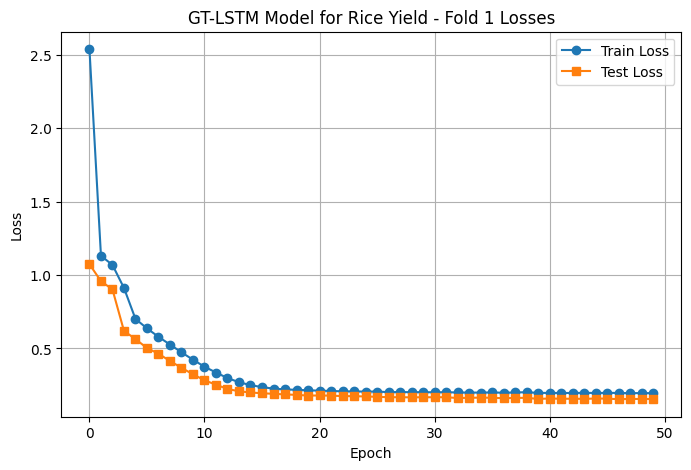


Fold 2/10 - Test Years: [np.int64(2003), np.int64(2004), np.int64(2005)]
Fold 2 Epoch [1/50] - Train Loss: 1.8495, Test Loss: 0.9337, Train RMSE: 1.3600, Test RMSE: 0.9663, Train R²: -0.6702, Test R²: -0.1085
Fold 2 Epoch [2/50] - Train Loss: 1.1311, Test Loss: 0.8652, Train RMSE: 1.0635, Test RMSE: 0.9301, Train R²: -0.0215, Test R²: -0.0271
Fold 2 Epoch [3/50] - Train Loss: 1.0747, Test Loss: 0.8287, Train RMSE: 1.0367, Test RMSE: 0.9103, Train R²: 0.0295, Test R²: 0.0161
Fold 2 Epoch [4/50] - Train Loss: 1.0302, Test Loss: 0.7856, Train RMSE: 1.0150, Test RMSE: 0.8863, Train R²: 0.0696, Test R²: 0.0673
Fold 2 Epoch [5/50] - Train Loss: 0.9772, Test Loss: 0.7313, Train RMSE: 0.9885, Test RMSE: 0.8552, Train R²: 0.1176, Test R²: 0.1317
Fold 2 Epoch [6/50] - Train Loss: 0.8767, Test Loss: 0.5354, Train RMSE: 0.9363, Test RMSE: 0.7317, Train R²: 0.2083, Test R²: 0.3644
Fold 2 Epoch [7/50] - Train Loss: 0.6462, Test Loss: 0.4377, Train RMSE: 0.8038, Test RMSE: 0.6616, Train R²: 0.4165, 

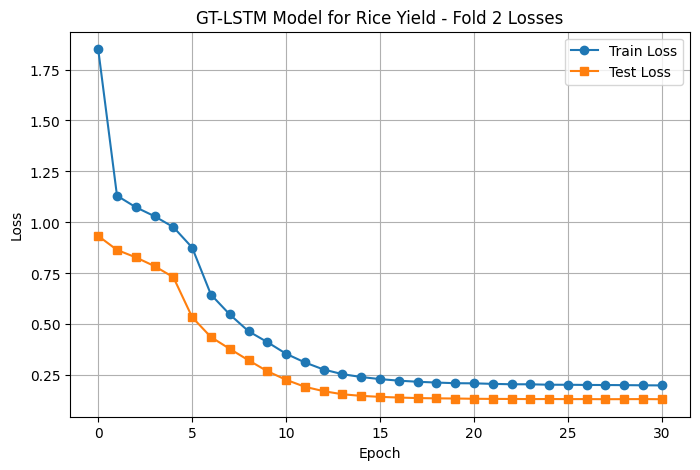


Fold 3/10 - Test Years: [np.int64(2006), np.int64(2007), np.int64(2008)]
Fold 3 Epoch [1/50] - Train Loss: 1.6705, Test Loss: 1.2639, Train RMSE: 1.2925, Test RMSE: 1.1243, Train R²: -0.5651, Test R²: -0.0839
Fold 3 Epoch [2/50] - Train Loss: 1.0272, Test Loss: 1.1868, Train RMSE: 1.0135, Test RMSE: 1.0894, Train R²: 0.0376, Test R²: -0.0178
Fold 3 Epoch [3/50] - Train Loss: 0.8731, Test Loss: 0.8020, Train RMSE: 0.9344, Test RMSE: 0.8955, Train R²: 0.1820, Test R²: 0.3122
Fold 3 Epoch [4/50] - Train Loss: 0.6493, Test Loss: 0.7322, Train RMSE: 0.8058, Test RMSE: 0.8557, Train R²: 0.3917, Test R²: 0.3721
Fold 3 Epoch [5/50] - Train Loss: 0.6070, Test Loss: 0.6656, Train RMSE: 0.7791, Test RMSE: 0.8158, Train R²: 0.4313, Test R²: 0.4292
Fold 3 Epoch [6/50] - Train Loss: 0.5542, Test Loss: 0.6183, Train RMSE: 0.7445, Test RMSE: 0.7863, Train R²: 0.4808, Test R²: 0.4697
Fold 3 Epoch [7/50] - Train Loss: 0.5172, Test Loss: 0.5686, Train RMSE: 0.7191, Test RMSE: 0.7541, Train R²: 0.5155, T

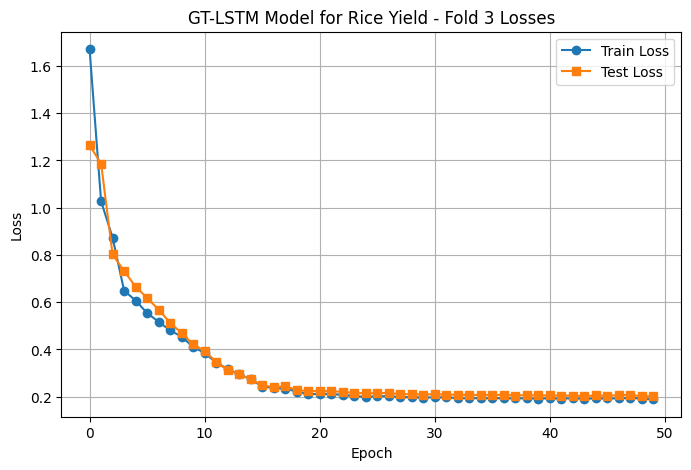


Fold 4/10 - Test Years: [np.int64(2009), np.int64(2010)]
Fold 4 Epoch [1/50] - Train Loss: 1.8512, Test Loss: 1.3343, Train RMSE: 1.3606, Test RMSE: 1.1551, Train R²: -0.7165, Test R²: -0.2119
Fold 4 Epoch [2/50] - Train Loss: 1.0626, Test Loss: 1.2047, Train RMSE: 1.0308, Test RMSE: 1.0976, Train R²: 0.0147, Test R²: -0.0942
Fold 4 Epoch [3/50] - Train Loss: 0.9574, Test Loss: 0.9766, Train RMSE: 0.9785, Test RMSE: 0.9883, Train R²: 0.1122, Test R²: 0.1129
Fold 4 Epoch [4/50] - Train Loss: 0.7287, Test Loss: 0.7709, Train RMSE: 0.8537, Test RMSE: 0.8780, Train R²: 0.3243, Test R²: 0.2998
Fold 4 Epoch [5/50] - Train Loss: 0.6355, Test Loss: 0.7161, Train RMSE: 0.7972, Test RMSE: 0.8462, Train R²: 0.4108, Test R²: 0.3495
Fold 4 Epoch [6/50] - Train Loss: 0.5794, Test Loss: 0.6530, Train RMSE: 0.7612, Test RMSE: 0.8081, Train R²: 0.4628, Test R²: 0.4069
Fold 4 Epoch [7/50] - Train Loss: 0.5353, Test Loss: 0.5937, Train RMSE: 0.7316, Test RMSE: 0.7705, Train R²: 0.5037, Test R²: 0.4608
F

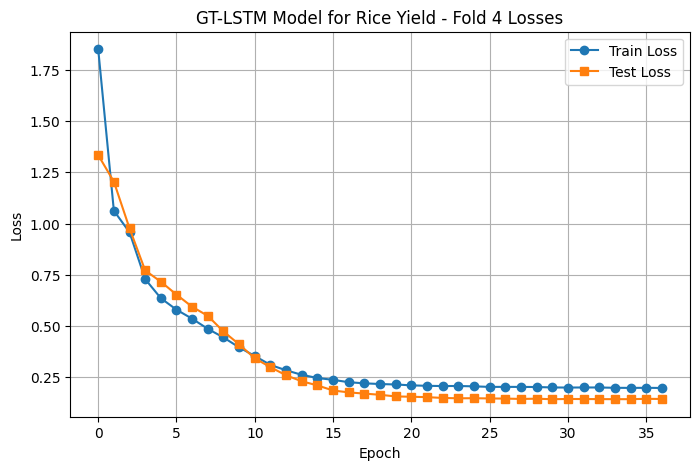


Fold 5/10 - Test Years: [np.int64(2011), np.int64(2012)]
Fold 5 Epoch [1/50] - Train Loss: 1.3557, Test Loss: 1.0360, Train RMSE: 1.1643, Test RMSE: 1.0178, Train R²: -0.2335, Test R²: -0.1165
Fold 5 Epoch [2/50] - Train Loss: 1.0663, Test Loss: 0.9902, Train RMSE: 1.0326, Test RMSE: 0.9951, Train R²: 0.0298, Test R²: -0.0673
Fold 5 Epoch [3/50] - Train Loss: 0.9601, Test Loss: 0.7154, Train RMSE: 0.9798, Test RMSE: 0.8458, Train R²: 0.1265, Test R²: 0.2290
Fold 5 Epoch [4/50] - Train Loss: 0.7082, Test Loss: 0.6405, Train RMSE: 0.8416, Test RMSE: 0.8003, Train R²: 0.3556, Test R²: 0.3097
Fold 5 Epoch [5/50] - Train Loss: 0.6627, Test Loss: 0.5638, Train RMSE: 0.8141, Test RMSE: 0.7509, Train R²: 0.3970, Test R²: 0.3923
Fold 5 Epoch [6/50] - Train Loss: 0.5954, Test Loss: 0.5382, Train RMSE: 0.7716, Test RMSE: 0.7336, Train R²: 0.4583, Test R²: 0.4199
Fold 5 Epoch [7/50] - Train Loss: 0.5537, Test Loss: 0.4897, Train RMSE: 0.7441, Test RMSE: 0.6998, Train R²: 0.4962, Test R²: 0.4722
F

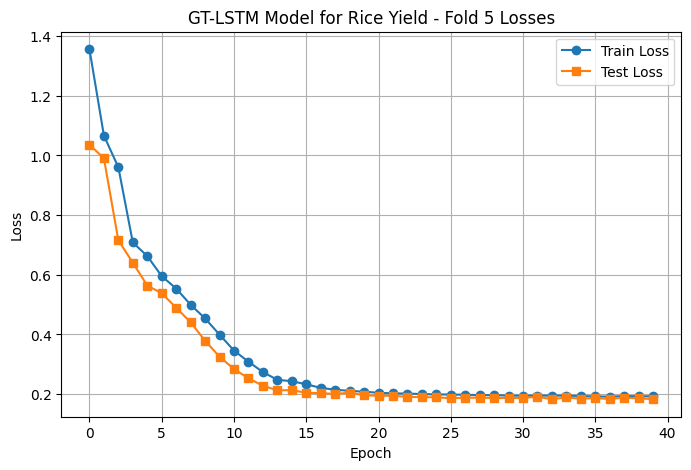


Fold 6/10 - Test Years: [np.int64(2013), np.int64(2014)]
Fold 6 Epoch [1/50] - Train Loss: 2.3361, Test Loss: 1.3424, Train RMSE: 1.5284, Test RMSE: 1.1586, Train R²: -1.1614, Test R²: -0.2405
Fold 6 Epoch [2/50] - Train Loss: 1.0920, Test Loss: 1.1808, Train RMSE: 1.0450, Test RMSE: 1.0867, Train R²: -0.0103, Test R²: -0.0912
Fold 6 Epoch [3/50] - Train Loss: 1.0459, Test Loss: 1.1385, Train RMSE: 1.0227, Test RMSE: 1.0670, Train R²: 0.0323, Test R²: -0.0520
Fold 6 Epoch [4/50] - Train Loss: 0.9969, Test Loss: 1.0324, Train RMSE: 0.9985, Test RMSE: 1.0161, Train R²: 0.0776, Test R²: 0.0459
Fold 6 Epoch [5/50] - Train Loss: 0.8090, Test Loss: 0.7750, Train RMSE: 0.8994, Test RMSE: 0.8803, Train R²: 0.2515, Test R²: 0.2838
Fold 6 Epoch [6/50] - Train Loss: 0.6595, Test Loss: 0.6518, Train RMSE: 0.8121, Test RMSE: 0.8073, Train R²: 0.3898, Test R²: 0.3977
Fold 6 Epoch [7/50] - Train Loss: 0.5947, Test Loss: 0.5882, Train RMSE: 0.7712, Test RMSE: 0.7670, Train R²: 0.4498, Test R²: 0.4564

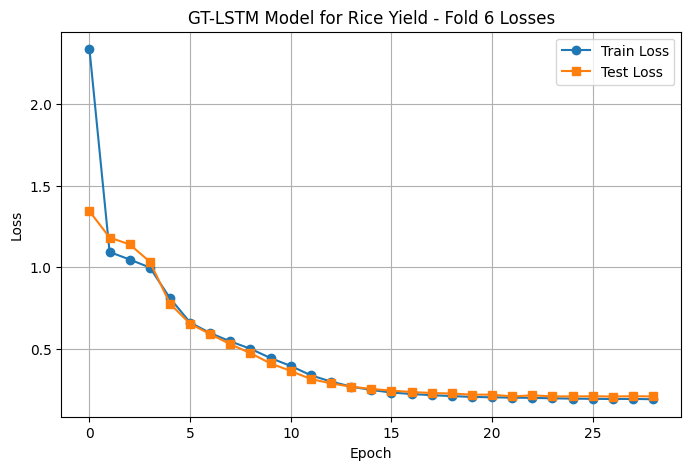


Fold 7/10 - Test Years: [np.int64(2015), np.int64(2016)]
Fold 7 Epoch [1/50] - Train Loss: 1.2363, Test Loss: 1.1565, Train RMSE: 1.1119, Test RMSE: 1.0754, Train R²: -0.1333, Test R²: -0.1456
Fold 7 Epoch [2/50] - Train Loss: 1.0306, Test Loss: 1.0402, Train RMSE: 1.0152, Test RMSE: 1.0199, Train R²: 0.0552, Test R²: -0.0304
Fold 7 Epoch [3/50] - Train Loss: 0.7441, Test Loss: 0.8109, Train RMSE: 0.8626, Test RMSE: 0.9005, Train R²: 0.3179, Test R²: 0.1967
Fold 7 Epoch [4/50] - Train Loss: 0.6584, Test Loss: 0.7818, Train RMSE: 0.8114, Test RMSE: 0.8842, Train R²: 0.3964, Test R²: 0.2255
Fold 7 Epoch [5/50] - Train Loss: 0.6009, Test Loss: 0.6784, Train RMSE: 0.7752, Test RMSE: 0.8237, Train R²: 0.4491, Test R²: 0.3279
Fold 7 Epoch [6/50] - Train Loss: 0.5311, Test Loss: 0.6092, Train RMSE: 0.7287, Test RMSE: 0.7805, Train R²: 0.5132, Test R²: 0.3966
Fold 7 Epoch [7/50] - Train Loss: 0.4795, Test Loss: 0.5368, Train RMSE: 0.6925, Test RMSE: 0.7327, Train R²: 0.5604, Test R²: 0.4682
F

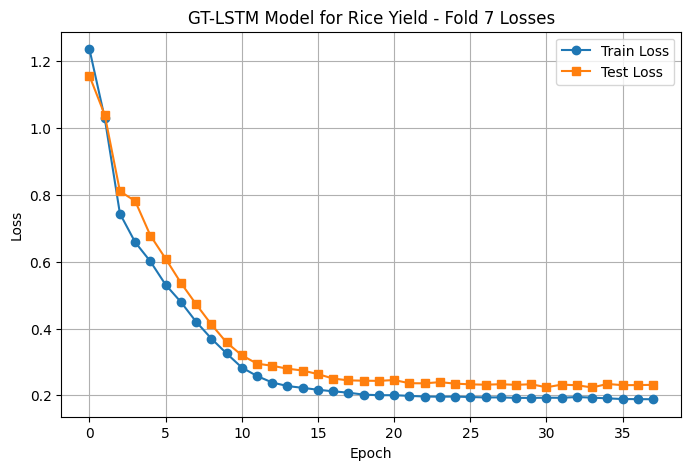


Fold 8/10 - Test Years: [np.int64(2017), np.int64(2018)]
Fold 8 Epoch [1/50] - Train Loss: 1.5355, Test Loss: 1.1049, Train RMSE: 1.2392, Test RMSE: 1.0512, Train R²: -0.4203, Test R²: -0.0490
Fold 8 Epoch [2/50] - Train Loss: 1.0631, Test Loss: 1.0423, Train RMSE: 1.0311, Test RMSE: 1.0209, Train R²: 0.0167, Test R²: 0.0104
Fold 8 Epoch [3/50] - Train Loss: 0.9232, Test Loss: 0.6699, Train RMSE: 0.9608, Test RMSE: 0.8185, Train R²: 0.1461, Test R²: 0.3639
Fold 8 Epoch [4/50] - Train Loss: 0.7021, Test Loss: 0.5710, Train RMSE: 0.8379, Test RMSE: 0.7557, Train R²: 0.3505, Test R²: 0.4579
Fold 8 Epoch [5/50] - Train Loss: 0.6445, Test Loss: 0.5235, Train RMSE: 0.8028, Test RMSE: 0.7235, Train R²: 0.4039, Test R²: 0.5030
Fold 8 Epoch [6/50] - Train Loss: 0.5957, Test Loss: 0.4865, Train RMSE: 0.7718, Test RMSE: 0.6975, Train R²: 0.4490, Test R²: 0.5381
Fold 8 Epoch [7/50] - Train Loss: 0.5511, Test Loss: 0.4519, Train RMSE: 0.7424, Test RMSE: 0.6722, Train R²: 0.4902, Test R²: 0.5710
Fo

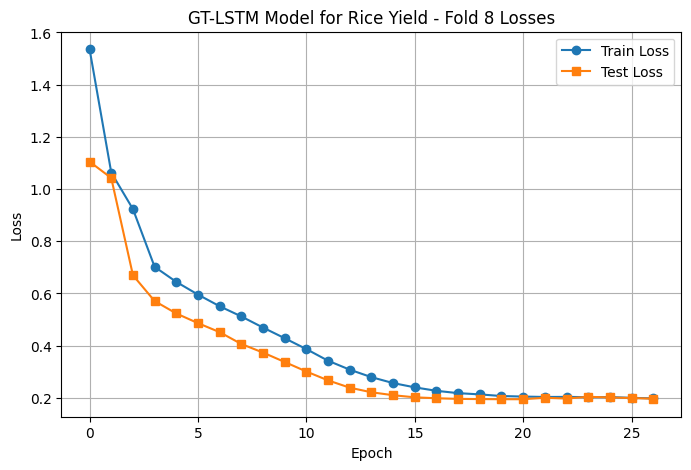


Fold 9/10 - Test Years: [np.int64(2019), np.int64(2020)]
Fold 9 Epoch [1/50] - Train Loss: 2.9052, Test Loss: 1.4117, Train RMSE: 1.7045, Test RMSE: 1.1881, Train R²: -1.7439, Test R²: -0.2483
Fold 9 Epoch [2/50] - Train Loss: 1.1053, Test Loss: 1.2461, Train RMSE: 1.0513, Test RMSE: 1.1163, Train R²: -0.0439, Test R²: -0.1019
Fold 9 Epoch [3/50] - Train Loss: 1.0317, Test Loss: 1.1056, Train RMSE: 1.0157, Test RMSE: 1.0515, Train R²: 0.0256, Test R²: 0.0223
Fold 9 Epoch [4/50] - Train Loss: 0.7847, Test Loss: 0.7984, Train RMSE: 0.8859, Test RMSE: 0.8935, Train R²: 0.2588, Test R²: 0.2940
Fold 9 Epoch [5/50] - Train Loss: 0.6462, Test Loss: 0.7615, Train RMSE: 0.8038, Test RMSE: 0.8726, Train R²: 0.3897, Test R²: 0.3267
Fold 9 Epoch [6/50] - Train Loss: 0.5706, Test Loss: 0.7043, Train RMSE: 0.7554, Test RMSE: 0.8392, Train R²: 0.4611, Test R²: 0.3772
Fold 9 Epoch [7/50] - Train Loss: 0.5221, Test Loss: 0.6784, Train RMSE: 0.7225, Test RMSE: 0.8236, Train R²: 0.5069, Test R²: 0.4001


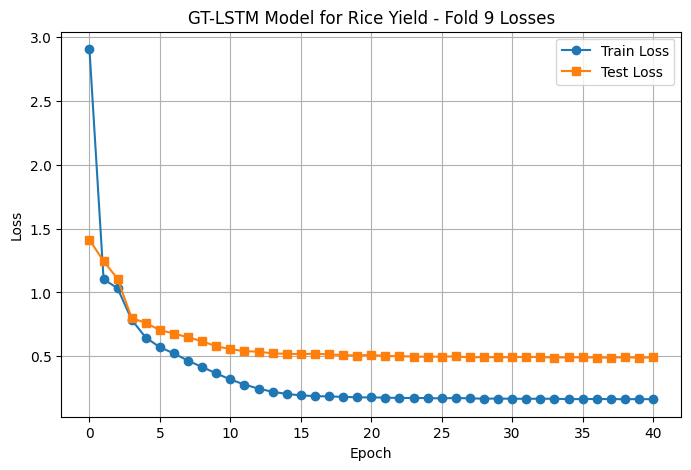


Fold 10/10 - Test Years: [np.int64(2021), np.int64(2022)]
Fold 10 Epoch [1/50] - Train Loss: 1.9070, Test Loss: 0.8563, Train RMSE: 1.3810, Test RMSE: 0.9254, Train R²: -0.7437, Test R²: -0.0684
Fold 10 Epoch [2/50] - Train Loss: 1.1091, Test Loss: 0.8141, Train RMSE: 1.0531, Test RMSE: 0.9023, Train R²: -0.0141, Test R²: -0.0157
Fold 10 Epoch [3/50] - Train Loss: 1.0267, Test Loss: 0.7211, Train RMSE: 1.0132, Test RMSE: 0.8492, Train R²: 0.0613, Test R²: 0.1003
Fold 10 Epoch [4/50] - Train Loss: 0.7971, Test Loss: 0.5592, Train RMSE: 0.8928, Test RMSE: 0.7478, Train R²: 0.2711, Test R²: 0.3023
Fold 10 Epoch [5/50] - Train Loss: 0.6835, Test Loss: 0.5086, Train RMSE: 0.8267, Test RMSE: 0.7132, Train R²: 0.3751, Test R²: 0.3654
Fold 10 Epoch [6/50] - Train Loss: 0.6308, Test Loss: 0.4764, Train RMSE: 0.7942, Test RMSE: 0.6902, Train R²: 0.4233, Test R²: 0.4056
Fold 10 Epoch [7/50] - Train Loss: 0.5880, Test Loss: 0.4371, Train RMSE: 0.7668, Test RMSE: 0.6612, Train R²: 0.4623, Test R²:

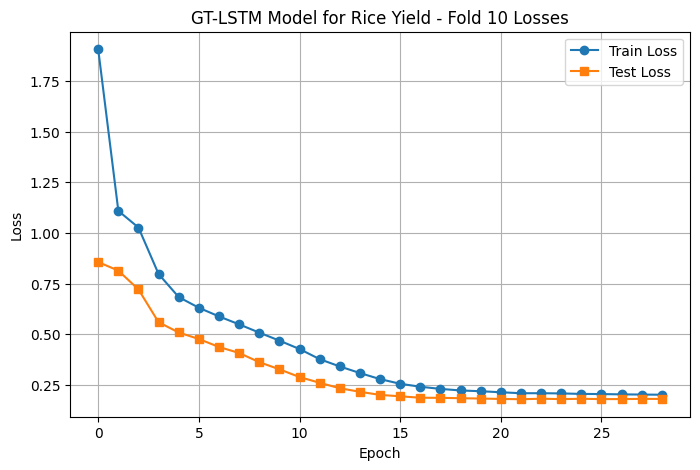


Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4376 (±0.0121)
Average Train R²: 0.8232 (±0.0083)
Average Test RMSE: 0.4521 (±0.0896)
Average Test R²: 0.7914 (±0.0805)
Cross-validation results saved to /content/gt_lstm_rice_yield_predictions.csv

District-wise Metrics:
Average RMSE: 0.3894 (±0.2338)
Average R²: 0.2907 (±0.2874)
Number of Negative R² Districts: 57
Worst 5 Districts by R²:
          District      RMSE        R2       MAE
33          Bijnor  0.224671 -0.564519  0.169886
212        Raigarh  0.368902 -0.489414  0.266716
177  Muzaffarnagar  0.213366 -0.447506  0.185023
150     Kushinagar  0.328891 -0.311640  0.256727
73       Faridabad  0.302974 -0.308612  0.217062

Top 5 districts connected to District Amritsar (Index 7):
  District Kapurthala (Index 126): Weight = 0.505
  District Gurdaspur (Index 91): Weight = 0.503
  District Jalandhar (Index 107): Weight = 0.503
  District Moga (Index 173): Weight = 0.503
  District Hoshiarpur (Index 1

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from math import radians, sin, cos, sqrt, atan2
import plotly.graph_objects as go

# Set seeds for reproducibility
SEED = 4
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Parameters
num_districts = 292
num_years = 23
climate_features = 36
rs_features = 16

# Load and preprocess data
climate_data = pd.read_csv('/content/cp_sowing_month_cp.csv')
climate_features_cols = [col for col in climate_data.columns if col not in ['District', 'year']]
climate_data_values = climate_data[climate_features_cols].values
scaler_cp = StandardScaler()
climate_data_normalized = scaler_cp.fit_transform(climate_data_values)
climate_data_reshaped = climate_data_normalized.reshape(num_years, num_districts, 4, 9).transpose(0, 1, 2, 3)
climate_data_tensor = torch.tensor(climate_data_reshaped, dtype=torch.float32)

rs_data = pd.read_csv('/content/rs_sowing_month_rs.csv')
rs_features_cols = [col for col in rs_data.columns if col not in ['District', 'year']]
rs_data_values = rs_data[rs_features_cols].values
scaler_rs = StandardScaler()
rs_data_normalized = scaler_rs.fit_transform(rs_data_values)
rs_data_reshaped = rs_data_normalized.reshape(num_years, num_districts, 4, 4).transpose(0, 1, 2, 3)
rs_data_tensor = torch.tensor(rs_data_reshaped, dtype=torch.float32)

yield_data = pd.read_csv('/content/detrended_rice_district_yield_sens_slope.csv')
district_names = yield_data['District'].unique()
district_name_to_index = {name: idx for idx, name in enumerate(district_names)}
yield_data['District'] = yield_data['District'].map(district_name_to_index)
yield_values = yield_data[['Year', 'Detrended_Yield', 'District', 'Trend', 'Actual']].values
years = yield_values[:, 0].astype(int)
detrended_yields = yield_values[:, 1]
districts = yield_values[:, 2].astype(int)
trends = yield_values[:, 3]
actual_yields = yield_values[:, 4]
district_mapping_df = pd.DataFrame(list(district_name_to_index.items()), columns=['District_Name', 'District_Index'])
district_mapping_df.to_csv('/content/district_name_to_index_rice.csv', index=False)

district_yields = np.zeros((num_districts, num_years))
trends_per_district = np.zeros((num_districts, num_years))
actual_yields_per_district = np.zeros((num_districts, num_years))
for i in range(len(years)):
    district_index = districts[i]
    year_index = years[i] - 2000
    district_yields[district_index, year_index] = detrended_yields[i]
    trends_per_district[district_index, year_index] = trends[i]
    actual_yields_per_district[district_index, year_index] = actual_yields[i]

district_yields_tensor = torch.tensor(district_yields, dtype=torch.float32)
trends_tensor = torch.tensor(trends_per_district, dtype=torch.float32)
actual_yields_tensor = torch.tensor(actual_yields_per_district, dtype=torch.float32)

# Load centroid data
centroid_df = pd.read_csv('/content/district_centroid_file.csv')
lat_col = next((col for col in centroid_df.columns if 'lat' in col.lower()), 'centroid_x')
lon_col = next((col for col in centroid_df.columns if 'lon' in col.lower()), 'centroid_y')
centroid_df = centroid_df.rename(columns={lat_col: 'latitude', lon_col: 'longitude'})
centroid_df['temp'] = centroid_df['latitude']
centroid_df['latitude'] = centroid_df['longitude']  # latitude
centroid_df['longitude'] = centroid_df['temp']     # longitude
centroid_df = centroid_df.drop(columns=['temp'])
centroid_df = centroid_df.dropna(subset=['latitude', 'longitude'])
valid_centroids = centroid_df[
    (centroid_df['latitude'].between(8, 37)) &
    (centroid_df['longitude'].between(68, 97))
]
if len(valid_centroids) < len(centroid_df):
    print(f"Warning: {len(centroid_df) - len(valid_centroids)} invalid coordinates removed.")
    centroid_df = valid_centroids

centroid_tensor = torch.tensor(centroid_df[['latitude', 'longitude']].values, dtype=torch.float32)

# Function for consecutive GroupKFold splits
def consecutive_group_kfold(df, n_splits=10):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)
    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define the GT-LSTM Model with Centroid Embeddings
class GTLSTMYieldPrediction(nn.Module):
    def __init__(self, num_districts=292, climate_features=36, rs_features=16,
                 hidden_dim=256, embedding_size=32, num_layers=2, heads=2):
        super(GTLSTMYieldPrediction, self).__init__()
        self.num_districts = num_districts
        self.embedding_size = embedding_size
        self.heads = heads

        # Centroid embedding layer
        self.centroid_embedding = nn.Sequential(
            nn.Linear(2, 16),  # Input: 2D (lat, lon), Output: 16D
            nn.ReLU(),
            nn.Linear(16, embedding_size)  # Match embedding size
        )

        # LSTM layers
        self.climate_lstm = nn.LSTM(input_size=9, hidden_size=hidden_dim,
                                    num_layers=num_layers, batch_first=True)
        self.rs_lstm = nn.LSTM(input_size=4, hidden_size=hidden_dim,
                               num_layers=num_layers, batch_first=True)

        # Dense layer to combine temporal and centroid embeddings
        self.dense = nn.Sequential(
            nn.Linear(hidden_dim * 2 + embedding_size, embedding_size),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.LayerNorm(embedding_size)
        )

        # GAT layers
        self.gat1 = GATConv(in_channels=embedding_size, out_channels=embedding_size // heads, heads=heads, dropout=0.2)
        self.gat2 = GATConv(in_channels=embedding_size, out_channels=embedding_size, heads=1, dropout=0.2)
        self.norm2 = nn.LayerNorm(embedding_size)

        # Output layer
        self.yield_mlp = nn.Sequential(
            nn.Linear(embedding_size, 32),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

        # Edge weights initialization (unchanged)
        try:
            districts_df = pd.read_csv('/content/district_centroid_file.csv')
            lat_col = next((col for col in districts_df.columns if 'lat' in col.lower()), 'centroid_x')
            lon_col = next((col for col in districts_df.columns if 'lon' in col.lower()), 'centroid_y')
            districts_df = districts_df.rename(columns={lat_col: 'centroid_x', lon_col: 'centroid_y'})
            districts_df['temp'] = districts_df['centroid_x']
            districts_df['centroid_x'] = districts_df['centroid_y']
            districts_df['centroid_y'] = districts_df['temp']
            districts_df = districts_df.drop(columns=['temp'])
            districts_df = districts_df.dropna(subset=['centroid_x', 'centroid_y'])
            valid_districts = districts_df[
                (districts_df['centroid_x'].between(8, 37)) &
                (districts_df['centroid_y'].between(68, 97))
            ]
            if len(valid_districts) < len(districts_df):
                print(f"Warning: {len(districts_df) - len(valid_districts)} invalid coordinates removed.")
                districts_df = valid_districts

            district_to_centroid = dict(zip(np.arange(len(districts_df)),
                                         districts_df[['centroid_x', 'centroid_y']].values))
            if len(district_to_centroid) != num_districts:
                print(f"Warning: Number of districts in centroid file ({len(district_to_centroid)}) does not match num_districts ({num_districts}). Initializing edge_weights randomly.")
                self.edge_weights = nn.Parameter(torch.randn(num_districts, num_districts))
            else:
                distance_matrix = np.zeros((num_districts, num_districts))
                for i in range(num_districts):
                    for j in range(num_districts):
                        if i != j and i in district_to_centroid and j in district_to_centroid:
                            distance_matrix[i, j] = haversine_distance(
                                district_to_centroid[i][0], district_to_centroid[i][1],
                                district_to_centroid[j][0], district_to_centroid[j][1]
                            )
                        else:
                            distance_matrix[i, j] = np.inf
                MAX_DISTANCE_KM = 100
                edge_weights_init = np.where(distance_matrix <= MAX_DISTANCE_KM,
                                            1 / (distance_matrix + 1e-6), 0)
                self.edge_weights = nn.Parameter(torch.tensor(edge_weights_init, dtype=torch.float32))
        except FileNotFoundError:
            print("Warning: district_centroid_file.csv not found. Initializing edge_weights randomly.")
            self.edge_weights = nn.Parameter(torch.randn(num_districts, num_districts))

        self.residual_scale = nn.Parameter(torch.ones(num_districts, 1))

    def forward(self, climate_data, rs_data, centroid_data):
        # Generate centroid embeddings
        centroid_emb = self.centroid_embedding(centroid_data)

        # Process temporal data
        climate_out, _ = self.climate_lstm(climate_data)
        rs_out, _ = self.rs_lstm(rs_data)
        climate_emb = climate_out[:, -1, :]
        rs_emb = rs_out[:, -1, :]

        # Combine temporal and centroid embeddings
        combined_emb = torch.cat([climate_emb, rs_emb, centroid_emb], dim=-1)
        dense_out = self.dense(combined_emb)

        # GAT processing
        adj_matrix = torch.sigmoid(self.edge_weights)
        adj_matrix = adj_matrix * (1 - torch.eye(self.num_districts, device=adj_matrix.device))
        edge_index = (adj_matrix > 0.5).nonzero(as_tuple=False).t().contiguous()
        edge_index = edge_index[:, edge_index[0] != edge_index[1]]
        gat_out = self.gat1(dense_out, edge_index)
        gat_out = torch.relu(gat_out)
        gat_out = self.gat2(gat_out, edge_index)
        gat_out = torch.relu(gat_out)
        gat_out = self.norm2(gat_out)
        scaled_residual = dense_out * self.residual_scale
        combined_out = gat_out + scaled_residual
        district_yields = self.yield_mlp(combined_out)
        return district_yields

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Cross-validation setup
n_splits = 10
fold_train_rmses = []
fold_train_r2s = []
fold_test_rmses = []
fold_test_r2s = []
all_results = []
fold_edge_weights = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
centroid_tensor = centroid_tensor.to(device)

# Cross-validation loop using consecutive_group_kfold
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(yield_data, n_splits=n_splits)):
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"\nFold {fold + 1}/{n_splits} - Test Years: {test_years}")

    train_indices = np.array([y - 2000 for y in train_years])
    test_indices = np.array([y - 2000 for y in test_years])

    if len(set(train_years + test_years)) != num_years:
        print(f"Error: Fold {fold + 1} does not cover all years.")
        raise ValueError("Fold configuration invalid")

    train_climate = climate_data_tensor[train_indices]
    train_rs = rs_data_tensor[train_indices]
    train_yields = district_yields_tensor[:, train_indices]
    train_trends = trends_tensor[:, train_indices]
    train_actual = actual_yields_tensor[:, train_indices]
    test_climate = climate_data_tensor[test_indices]
    test_rs = rs_data_tensor[test_indices]
    test_yields = district_yields_tensor[:, test_indices]
    test_trends = trends_tensor[:, test_indices]
    test_actual = actual_yields_tensor[:, test_indices]

    model = GTLSTMYieldPrediction().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
    criterion = nn.MSELoss()

    patience = 7
    min_delta = 0.001
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    train_losses = []
    test_losses = []

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_targets = []
        for year_idx in range(len(train_indices)):
            climate_batch = train_climate[year_idx].to(device)
            rs_batch = train_rs[year_idx].to(device)
            centroid_batch = centroid_tensor.to(device)
            trend_batch = train_trends[:, year_idx:year_idx+1].to(device)
            actual_batch = train_actual[:, year_idx:year_idx+1].to(device)
            pred = model(climate_batch, rs_batch, centroid_batch)
            predicted_yields = pred + trend_batch
            loss = criterion(predicted_yields, actual_batch)
            train_loss += loss.item()
            all_train_preds.extend(predicted_yields.detach().cpu().numpy())
            all_train_targets.extend(actual_batch.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_indices)
        train_losses.append(avg_train_loss)
        train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_preds))
        train_r2 = r2_score(all_train_targets, all_train_preds)

        model.eval()
        test_loss = 0
        all_test_preds = []
        all_test_targets = []
        with torch.no_grad():
            for year_idx in range(len(test_indices)):
                climate_batch = test_climate[year_idx].to(device)
                rs_batch = test_rs[year_idx].to(device)
                centroid_batch = centroid_tensor.to(device)
                trend_batch = test_trends[:, year_idx:year_idx+1].to(device)
                actual_batch = test_actual[:, year_idx:year_idx+1].to(device)
                pred = model(climate_batch, rs_batch, centroid_batch)
                predicted_yields = pred + trend_batch
                loss = criterion(predicted_yields, actual_batch)
                test_loss += loss.item()
                all_test_preds.extend(predicted_yields.cpu().numpy())
                all_test_targets.extend(actual_batch.cpu().numpy())

        avg_test_loss = test_loss / len(test_indices)
        test_losses.append(avg_test_loss)
        test_rmse = np.sqrt(mean_squared_error(all_test_targets, all_test_preds))
        test_r2 = r2_score(all_test_targets, all_test_preds)

        print(f"Fold {fold + 1} Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, "
              f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

        if avg_test_loss < best_val_loss - min_delta:
            best_val_loss = avg_test_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    fold_edge_weights.append(model.edge_weights.detach().cpu().numpy())
    fold_train_rmses.append(train_rmse)
    fold_train_r2s.append(train_r2)
    fold_test_rmses.append(test_rmse)
    fold_test_r2s.append(test_r2)

    for year_idx, year in enumerate(test_indices):
        preds = all_test_preds[year_idx * num_districts:(year_idx + 1) * num_districts]
        targets = all_test_targets[year_idx * num_districts:(year_idx + 1) * num_districts]
        for district in range(num_districts):
            actual_yield = actual_yields_per_district[district, year].item()
            predicted_yield = preds[district][0] if isinstance(preds[district], np.ndarray) else preds[district]
            all_results.append({
                'Fold': fold + 1,
                'Year': 2000 + year,
                'District': district_names[district],
                'Actual_Yield': actual_yield,
                'Predicted_Yield': predicted_yield
            })

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='s')
    plt.title(f'GT-LSTM Model for Rice Yield - Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f'/content/fold_{fold + 1}_loss_plot.png')
    plt.close()

# Compute and print overall metrics
avg_train_rmse = np.mean(fold_train_rmses)
avg_train_r2 = np.mean(fold_train_r2s)
avg_test_rmse = np.mean(fold_test_rmses)
avg_test_r2 = np.mean(fold_test_r2s)

print("\nOverall Cross-Validation Metrics for Rice Yield Prediction:")
print(f"Average Train RMSE: {avg_train_rmse:.4f} (±{np.std(fold_train_rmses):.4f})")
print(f"Average Train R²: {avg_train_r2:.4f} (±{np.std(fold_train_r2s):.4f})")
print(f"Average Test RMSE: {avg_test_rmse:.4f} (±{np.std(fold_test_rmses):.4f})")
print(f"Average Test R²: {avg_test_r2:.4f} (±{np.std(fold_test_r2s):.4f})")

results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/gt_lstm_rice_yield_predictions.csv', index=False)
print(f"Cross-validation results saved to /content/gt_lstm_rice_yield_predictions.csv")

# Compute district-wise metrics
district_metrics = []
for district_idx in range(num_districts):
    district_actual = actual_yields_per_district[district_idx]
    district_results = results_df[results_df['District'] == district_names[district_idx]]
    district_pred = np.zeros(num_years)
    for year in range(num_years):
        year_result = district_results[district_results['Year'] == 2000 + year]
        if not year_result.empty:
            district_pred[year] = year_result['Predicted_Yield'].iloc[0]
        else:
            model.eval()
            with torch.no_grad():
                climate_batch = climate_data_tensor[year:year+1, district_idx:district_idx+1].to(device)
                rs_batch = rs_data_tensor[year:year+1, district_idx:district_idx+1].to(device)
                centroid_batch = centroid_tensor[district_idx:district_idx+1].to(device)
                trend_batch = trends_tensor[district_idx:district_idx+1, year:year+1].to(device)
                pred = model(climate_batch.squeeze(0), rs_batch.squeeze(0), centroid_batch)
                district_pred[year] = (pred + trend_batch).cpu().numpy().item()
    rmse = np.sqrt(mean_squared_error(district_actual, district_pred))
    r2 = r2_score(district_actual, district_pred)
    mae = np.mean(np.abs(district_actual - district_pred))
    district_metrics.append({
        'District': district_names[district_idx],
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    })

district_metrics_df = pd.DataFrame(district_metrics)
district_metrics_df.to_csv('/content/district_metrics_rice.csv', index=False)
print("\nDistrict-wise Metrics:")
print(f"Average RMSE: {district_metrics_df['RMSE'].mean():.4f} (±{district_metrics_df['RMSE'].std():.4f})")
print(f"Average R²: {district_metrics_df['R2'].mean():.4f} (±{district_metrics_df['R2'].std():.4f})")
print(f"Number of Negative R² Districts: {(district_metrics_df['R2'] < 0).sum()}")
print("Worst 5 Districts by R²:")
print(district_metrics_df.sort_values('R2').head(5)[['District', 'RMSE', 'R2', 'MAE']])

# Plot connections for district 7
avg_edge_weights = np.mean(fold_edge_weights, axis=0)
adj_matrix = torch.sigmoid(torch.tensor(avg_edge_weights, dtype=torch.float32))
adj_matrix = adj_matrix * (1 - torch.eye(num_districts))
edge_index = (adj_matrix > 0.5).nonzero(as_tuple=False).t().cpu().numpy()
edge_weights_map = adj_matrix[edge_index[0], edge_index[1]].cpu().numpy()

try:
    districts_df = pd.read_csv('/content/district_centroid_file.csv')
    lat_col = next((col for col in districts_df.columns if 'lat' in col.lower()), 'centroid_x')
    lon_col = next((col for col in districts_df.columns if 'lon' in col.lower()), 'centroid_y')
    districts_df = districts_df.rename(columns={lat_col: 'centroid_x', lon_col: 'centroid_y'})
    districts_df['temp'] = districts_df['centroid_x']
    districts_df['centroid_x'] = districts_df['centroid_y']
    districts_df['centroid_y'] = districts_df['temp']
    districts_df = districts_df.drop(columns=['temp'])
    districts_df = districts_df.dropna(subset=['centroid_x', 'centroid_y'])
    valid_districts = districts_df[
        (districts_df['centroid_x'].between(8, 37)) &
        (districts_df['centroid_y'].between(68, 97))
    ]
    if len(valid_districts) < len(districts_df):
        print(f"Warning: {len(districts_df) - len(valid_districts)} invalid coordinates removed.")
        districts_df = valid_districts

    district_to_centroid = dict(zip(np.arange(len(districts_df)),
                                   districts_df[['centroid_x', 'centroid_y']].values))
    if len(district_to_centroid) != num_districts:
        print(f"Warning: Number of districts in centroid file ({len(district_to_centroid)}) does not match num_districts ({num_districts}). Skipping visualization.")
        raise ValueError("Mismatch in district count")
except (FileNotFoundError, ValueError) as e:
    print(f"Error: {e}. Cannot generate Mapbox visualization without valid centroid data.")
else:
    district_1 = 7
    connected_indices = edge_index[1][edge_index[0] == district_1]
    if len(connected_indices) > 0:
        edge_mask = edge_index[0] == district_1
        relevant_weights = edge_weights_map[edge_mask]
        relevant_targets = connected_indices
        top_5_indices = relevant_targets[np.argsort(relevant_weights)[::-1][:min(5, len(relevant_weights))]]
        print(f"\nTop 5 districts connected to District {district_names[district_1]} (Index {district_1}):")
        for idx, weight in zip(top_5_indices, [relevant_weights[np.where(relevant_targets == i)[0][0]] for i in top_5_indices]):
            print(f"  District {district_names[idx]} (Index {idx}): Weight = {weight:.3f}")
    else:
        top_5_indices = np.array([], dtype=int)
        print(f"No connections found for District {district_names[district_1]} (Index {district_1}).")

    district_1_centroid = district_to_centroid[district_1]
    connected_centroids = [district_to_centroid[idx] for idx in top_5_indices if idx in district_to_centroid]
    num_connected_districts = len(top_5_indices)

    lat = [district_1_centroid[0]] + [centroid[0] for centroid in connected_centroids]
    lon = [district_1_centroid[1]] + [centroid[1] for centroid in connected_centroids]
    names = [district_names[district_1]] + [district_names[idx] for idx in top_5_indices if idx < len(district_names)]
    weights = [1.0] + [relevant_weights[np.where(relevant_targets == idx)[0][0]] for idx in top_5_indices if idx in relevant_targets]
    selected_weights = [round(w, 2) for w in weights]

    fig = go.Figure()
    for i in range(len(connected_centroids)):
        delta_lat = connected_centroids[i][0] - district_1_centroid[0]
        delta_lon = connected_centroids[i][1] - district_1_centroid[1]
        distance = np.sqrt(delta_lat**2 + delta_lon**2)
        if distance == 0:
            continue
        direction_lat = delta_lat / distance
        direction_lon = delta_lon / distance
        offset = 0.1
        start_lat = district_1_centroid[0] + direction_lat * offset
        start_lon = district_1_centroid[1] + direction_lon * offset
        fig.add_trace(go.Scattermapbox(
            lat=[start_lat, connected_centroids[i][0]],
            lon=[start_lon, connected_centroids[i][1]],
            mode="lines",
            line=dict(width=1, color="gray"),
            hoverinfo="none",
            showlegend=False
        ))

    fig.add_trace(go.Scattermapbox(
        lat=[centroid[0] for centroid in connected_centroids],
        lon=[centroid[1] for centroid in connected_centroids],
        mode="markers+text",
        marker=dict(size=12, color="blue"),
        text=selected_weights[1:],
        textfont=dict(size=12, color="black"),
        textposition="top center",
        name="Connected Districts"
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[district_1_centroid[0]],
        lon=[district_1_centroid[1]],
        mode="markers+text",
        marker=dict(size=22, color="red", opacity=0.8),
        text=[str(num_connected_districts)],
        textfont=dict(size=14, color="black"),
        textposition="middle center",
        name=f"{district_names[district_1]} Centroid"
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": np.mean(lat), "lon": np.mean(lon)},
        mapbox_zoom=5,
        showlegend=True,
        title=f'Top 5 Connections for District {district_names[district_1]} with Distance Weights',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
    )

    fig.show()

```
hidden_dim=512, embedding_size=32, num_layers=2, heads=4:
ep = 50 , p = 10

Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4879 (±0.0122)
Average Train R²: 0.7801 (±0.0107)
Average Test RMSE: 0.4733 (±0.0793)
Average Test R²: 0.7721 (±0.0755)

hidden_dim=512, embedding_size=32, num_layers=2, heads=1:
ep = 50 , p = 7
Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4393 (±0.0133)
Average Train R²: 0.8218 (±0.0095)
Average Test RMSE: 0.4550 (±0.0857)
Average Test R²: 0.7892 (±0.0769)
```

------------Yearly Metrics----------------
    Year      RMSE        R2
0   2000  0.390035  0.860904
1   2001  0.402323  0.800458
2   2002  0.390802  0.841990
3   2003  0.386069  0.780762
4   2004  0.364870  0.867418
5   2005  0.341655  0.860411
6   2006  0.313715  0.902389
7   2007  0.380410  0.864976
8   2008  0.604141  0.741770
9   2009  0.374659  0.880653
10  2010  0.383036  0.856706
11  2011  0.433043  0.825394
12  2012  0.423956  0.769173
13  2013  0.458015  0.811232
14  2014  0.449690  0.807852
15  2015  0.449553  0.830305
16  2016  0.510607  0.677898
17  2017  0.457139  0.797332
18  2018  0.430133  0.827949
19  2019  0.402506  0.810894
20  2020  0.905565  0.413528
21  2021  0.384310  0.828651
22  2022  0.462066  0.708503

------------Average Yearly Metrics----------------
Average yearly RMSE: 0.4391
Average yearly R²: 0.7986


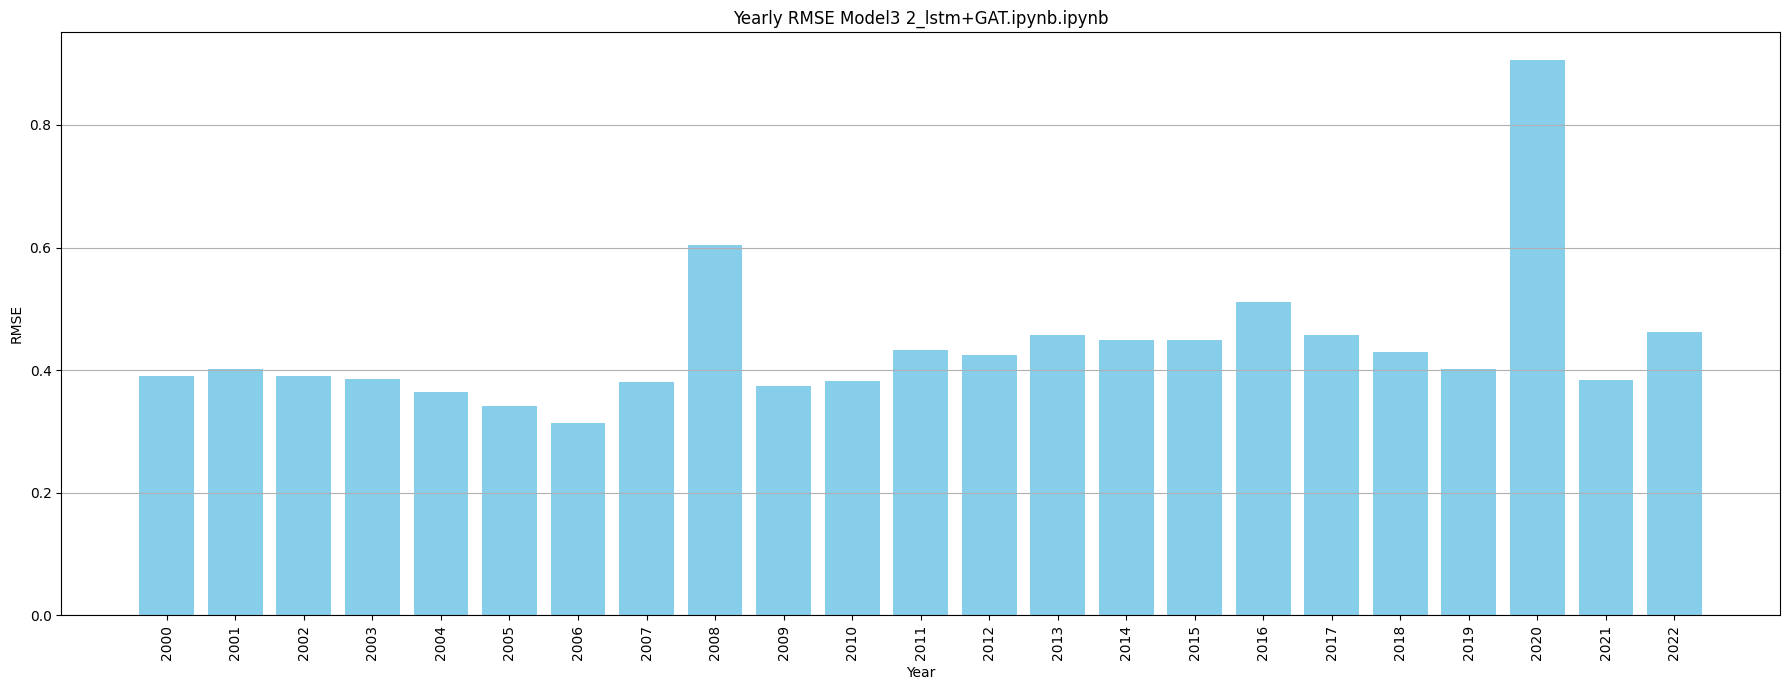

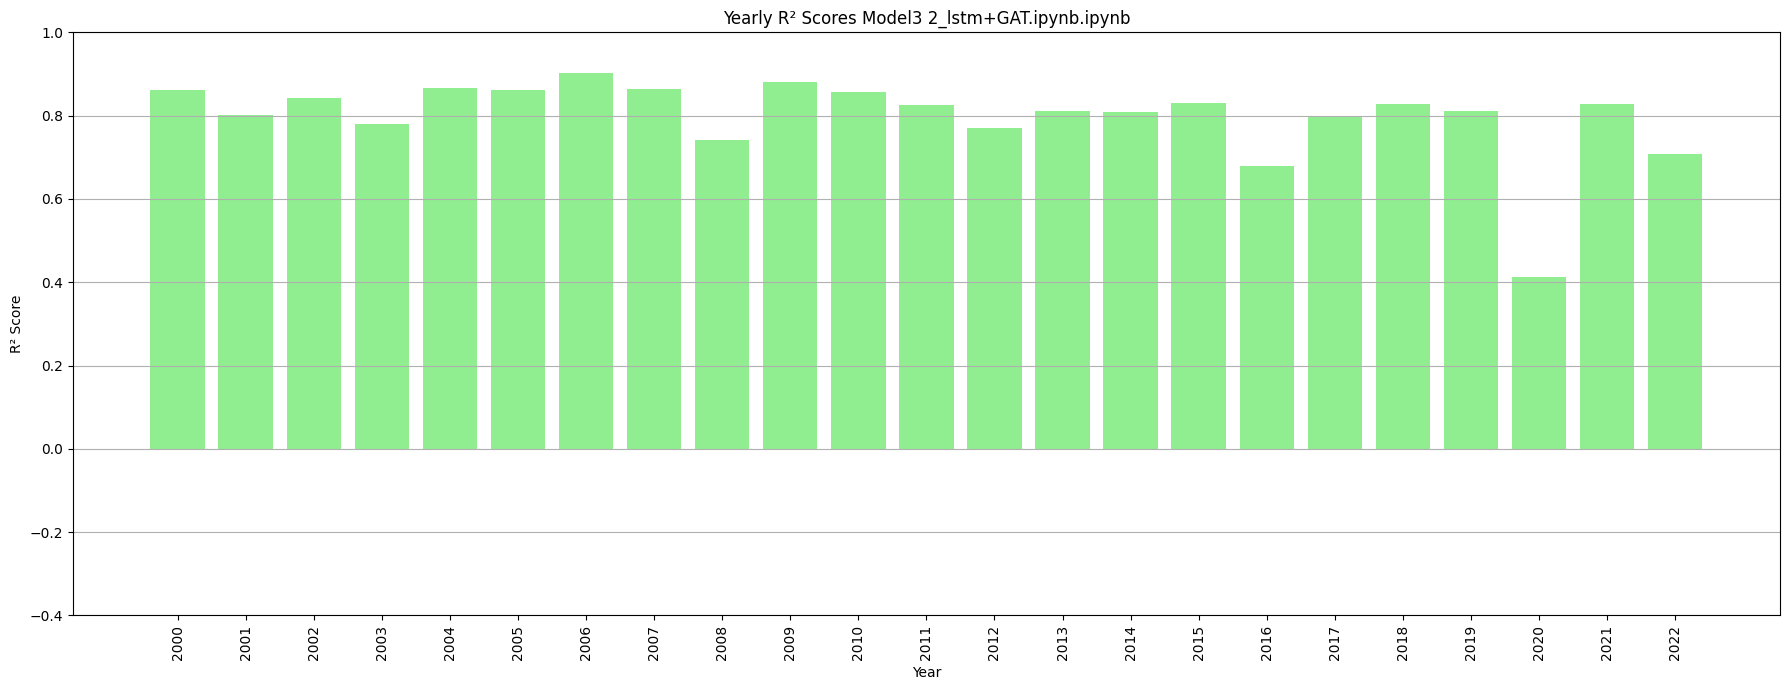

In [ ]:
# Load the results file
results_df = pd.read_csv('/content/gt_lstm_rice_yield_predictions.csv')

# Initialize dictionaries to store RMSE and R² for each year
yearly_rmse = {}
yearly_r2 = {}

# Group by year and calculate RMSE and R² for each year
for year, group in results_df.groupby('Year'):
    actual_yields = group['Actual_Yield'].values
    predicted_yields = group['Predicted_Yield'].values

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(actual_yields, predicted_yields))
    r2 = r2_score(actual_yields, predicted_yields)

    # Store the results in the dictionaries
    yearly_rmse[year] = rmse
    yearly_r2[year] = r2

# Convert the dictionaries to a DataFrame for easier viewing and visualization
yearly_metrics_df = pd.DataFrame({
    'Year': list(yearly_rmse.keys()),
    'RMSE': list(yearly_rmse.values()),
    'R2': list(yearly_r2.values())
})

# Save the yearly metrics to a CSV file
yearly_metrics_df.to_csv('/content/yearly_yield_metrics3.csv', index=False)

# Calculate and print the average yearly metrics separately
average_yearly_rmse = yearly_metrics_df['RMSE'].mean()
average_yearly_r2 = yearly_metrics_df['R2'].mean()

print("------------Yearly Metrics----------------")
print(yearly_metrics_df)
print("\n------------Average Yearly Metrics----------------")
print(f"Average yearly RMSE: {average_yearly_rmse:.4f}")
print(f"Average yearly R²: {average_yearly_r2:.4f}")

# Visualization of Yearly Metrics

# Yearly RMSE Plot
plt.figure(figsize=(18, 7))
plt.bar(yearly_metrics_df['Year'], yearly_metrics_df['RMSE'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('Yearly RMSE Model3 2_lstm+GAT.ipynb.ipynb')
plt.xticks(yearly_metrics_df['Year'], rotation=90)

plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Yearly R² Plot
plt.figure(figsize=(18, 7))
plt.bar(yearly_metrics_df['Year'], yearly_metrics_df['R2'], color='lightgreen')
plt.xlabel('Year')
plt.ylabel('R² Score')
plt.title('Yearly R² Scores Model3 2_lstm+GAT.ipynb.ipynb')
plt.xticks(yearly_metrics_df['Year'], rotation=90)
plt.ylim(-0.4, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


```
------------Average Yearly Metrics----------------
Average yearly RMSE: 0.4391
Average yearly R²: 0.7986


```

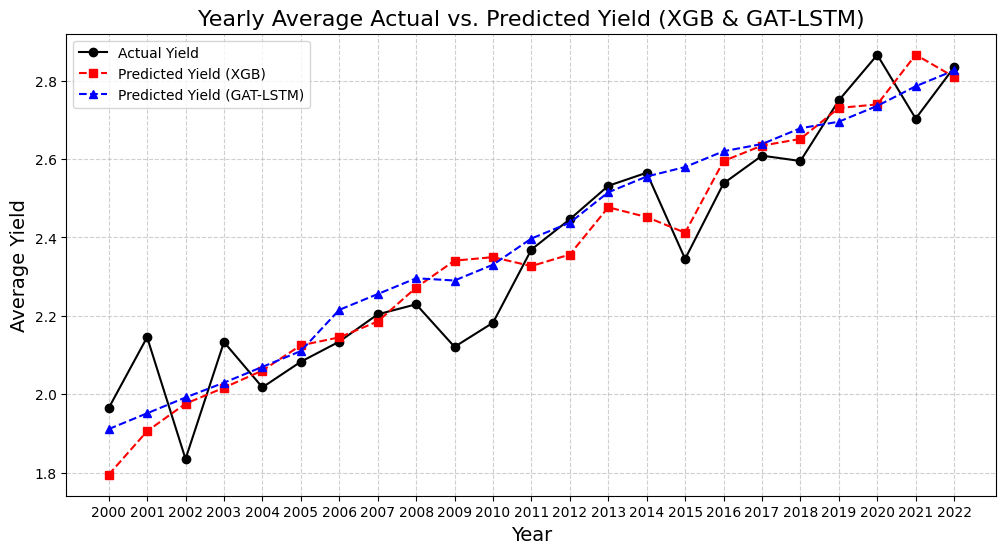

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load GAT-LSTM results from CSV
gat_lstm_df = pd.read_csv("/content/gt_lstm_xgb_rice_yield_predictions_stage3.csv")

# Group by year and compute mean actual and predicted yields for GAT-LSTM
xgb_yearly_avg = gat_lstm_df.groupby("Year")[["Actual_Yield", "Predicted_Yield_XGB"]].mean().reset_index()
# Group XGB DataFrame by year and compute mean actual and predicted yields
#xgb_yearly_avg = df.groupby("Year")[["Actual", "Predicted"]].mean().reset_index()

# Load GAT-LSTM results from CSV
gat_lstm_df = pd.read_csv("/content/gt_lstm_xgb_rice_yield_predictions_stage3.csv")

# Group by year and compute mean actual and predicted yields for GAT-LSTM
gat_lstm_yearly_avg = gat_lstm_df.groupby("Year")[["Actual_Yield", "Predicted_Yield_GATLSTM"]].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))

# Plot Actual Yield (only once)
plt.plot(xgb_yearly_avg["Year"], xgb_yearly_avg["Actual_Yield"], marker="o", linestyle="-", color="black", label="Actual Yield")

# XGB Model Predictions
plt.plot(xgb_yearly_avg["Year"], xgb_yearly_avg["Predicted_Yield_XGB"], marker="s", linestyle="--", color="red", label="Predicted Yield (XGB)")

# GAT-LSTM Model Predictions
plt.plot(gat_lstm_yearly_avg["Year"], gat_lstm_yearly_avg["Predicted_Yield_GATLSTM"], marker="^", linestyle="--", color="blue", label="Predicted Yield (GAT-LSTM)")

# Formatting the plot
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Yield", fontsize=14)
plt.title("Yearly Average Actual vs. Predicted Yield (XGB & GAT-LSTM)", fontsize=16)
plt.legend()
plt.xticks(xgb_yearly_avg["Year"])  # Ensure all years appear as ticks
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


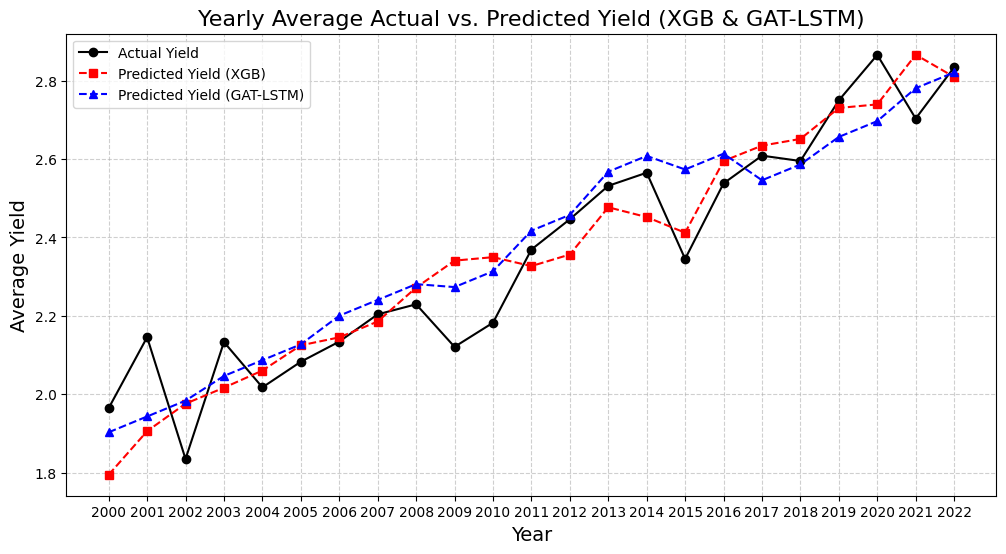

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load GAT-LSTM results from CSV
gat_lstm_df = pd.read_csv("/content/gt_lstm_xgb_rice_yield_predictions_stage3.csv")

# Group by year and compute mean actual and predicted yields for GAT-LSTM
xgb_yearly_avg = gat_lstm_df.groupby("Year")[["Actual_Yield", "Predicted_Yield_XGB"]].mean().reset_index()
# Group XGB DataFrame by year and compute mean actual and predicted yields
#xgb_yearly_avg = df.groupby("Year")[["Actual", "Predicted"]].mean().reset_index()

# Load GAT-LSTM results from CSV
gat_lstm_df = pd.read_csv("/content/gt_lstm_xgb_rice_yield_predictions_stage3.csv")

# Group by year and compute mean actual and predicted yields for GAT-LSTM
gat_lstm_yearly_avg = gat_lstm_df.groupby("Year")[["Actual_Yield", "Predicted_Yield_GATLSTM"]].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))

# Plot Actual Yield (only once)
plt.plot(xgb_yearly_avg["Year"], xgb_yearly_avg["Actual_Yield"], marker="o", linestyle="-", color="black", label="Actual Yield")

# XGB Model Predictions
plt.plot(xgb_yearly_avg["Year"], xgb_yearly_avg["Predicted_Yield_XGB"], marker="s", linestyle="--", color="red", label="Predicted Yield (XGB)")

# GAT-LSTM Model Predictions
plt.plot(gat_lstm_yearly_avg["Year"], gat_lstm_yearly_avg["Predicted_Yield_GATLSTM"], marker="^", linestyle="--", color="blue", label="Predicted Yield (GAT-LSTM)")

# Formatting the plot
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Yield", fontsize=14)
plt.title("Yearly Average Actual vs. Predicted Yield (XGB & GAT-LSTM)", fontsize=16)
plt.legend()
plt.xticks(xgb_yearly_avg["Year"])  # Ensure all years appear as ticks
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


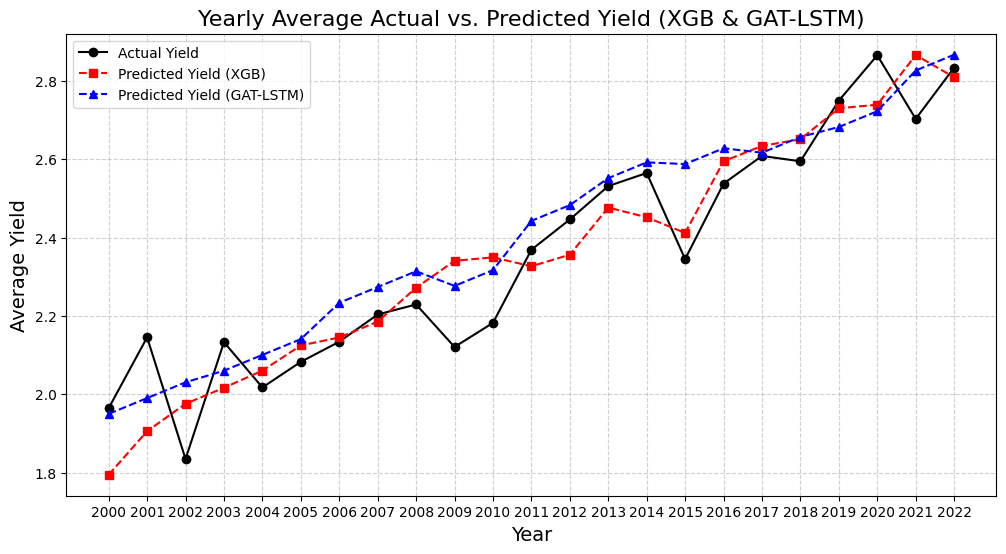

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load GAT-LSTM results from CSV
gat_lstm_df = pd.read_csv("/content/gt_lstm_xgb_rice_yield_predictions_stage3.csv")

# Group by year and compute mean actual and predicted yields for GAT-LSTM
xgb_yearly_avg = gat_lstm_df.groupby("Year")[["Actual_Yield", "Predicted_Yield_XGB"]].mean().reset_index()
# Group XGB DataFrame by year and compute mean actual and predicted yields
#xgb_yearly_avg = df.groupby("Year")[["Actual", "Predicted"]].mean().reset_index()

# Load GAT-LSTM results from CSV
gat_lstm_df = pd.read_csv("/content/gt_lstm_xgb_rice_yield_predictions_stage3.csv")

# Group by year and compute mean actual and predicted yields for GAT-LSTM
gat_lstm_yearly_avg = gat_lstm_df.groupby("Year")[["Actual_Yield", "Predicted_Yield_GATLSTM"]].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))

# Plot Actual Yield (only once)
plt.plot(xgb_yearly_avg["Year"], xgb_yearly_avg["Actual_Yield"], marker="o", linestyle="-", color="black", label="Actual Yield")

# XGB Model Predictions
plt.plot(xgb_yearly_avg["Year"], xgb_yearly_avg["Predicted_Yield_XGB"], marker="s", linestyle="--", color="red", label="Predicted Yield (XGB)")

# GAT-LSTM Model Predictions
plt.plot(gat_lstm_yearly_avg["Year"], gat_lstm_yearly_avg["Predicted_Yield_GATLSTM"], marker="^", linestyle="--", color="blue", label="Predicted Yield (GAT-LSTM)")

# Formatting the plot
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Yield", fontsize=14)
plt.title("Yearly Average Actual vs. Predicted Yield (XGB & GAT-LSTM)", fontsize=16)
plt.legend()
plt.xticks(xgb_yearly_avg["Year"])  # Ensure all years appear as ticks
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


### stagewise


Fold 1/10 - Test Years: [np.int64(2000), np.int64(2001), np.int64(2002)]
Fold 1 Epoch [1/50] - Train Loss: 1.5157, Test Loss: 0.9771, Train RMSE: 1.2311, Test RMSE: 0.9885, Train R²: -0.4075, Test R²: -0.0038
Fold 1 Epoch [2/50] - Train Loss: 1.0895, Test Loss: 0.9347, Train RMSE: 1.0438, Test RMSE: 0.9668, Train R²: -0.0117, Test R²: 0.0398
Fold 1 Epoch [3/50] - Train Loss: 1.0509, Test Loss: 0.8958, Train RMSE: 1.0251, Test RMSE: 0.9465, Train R²: 0.0241, Test R²: 0.0797
Fold 1 Epoch [4/50] - Train Loss: 1.0031, Test Loss: 0.8450, Train RMSE: 1.0016, Test RMSE: 0.9192, Train R²: 0.0684, Test R²: 0.1319
Fold 1 Epoch [5/50] - Train Loss: 0.9455, Test Loss: 0.7849, Train RMSE: 0.9724, Test RMSE: 0.8859, Train R²: 0.1219, Test R²: 0.1936
Fold 1 Epoch [6/50] - Train Loss: 0.8738, Test Loss: 0.7058, Train RMSE: 0.9348, Test RMSE: 0.8401, Train R²: 0.1885, Test R²: 0.2749
Fold 1 Epoch [7/50] - Train Loss: 0.7801, Test Loss: 0.6037, Train RMSE: 0.8833, Test RMSE: 0.7770, Train R²: 0.2755, T

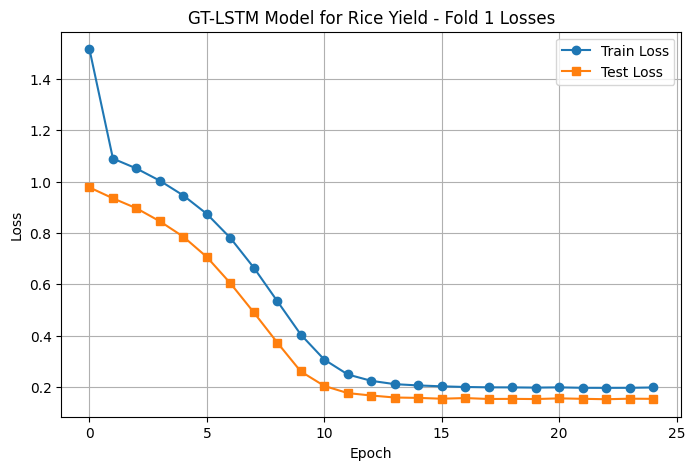


Fold 2/10 - Test Years: [np.int64(2003), np.int64(2004), np.int64(2005)]
Fold 2 Epoch [1/50] - Train Loss: 2.2146, Test Loss: 0.9300, Train RMSE: 1.4881, Test RMSE: 0.9644, Train R²: -0.9999, Test R²: -0.1041
Fold 2 Epoch [2/50] - Train Loss: 1.1363, Test Loss: 0.8642, Train RMSE: 1.0660, Test RMSE: 0.9296, Train R²: -0.0261, Test R²: -0.0259
Fold 2 Epoch [3/50] - Train Loss: 1.0823, Test Loss: 0.8309, Train RMSE: 1.0403, Test RMSE: 0.9116, Train R²: 0.0227, Test R²: 0.0135
Fold 2 Epoch [4/50] - Train Loss: 1.0435, Test Loss: 0.7913, Train RMSE: 1.0215, Test RMSE: 0.8896, Train R²: 0.0576, Test R²: 0.0605
Fold 2 Epoch [5/50] - Train Loss: 1.0002, Test Loss: 0.7432, Train RMSE: 1.0001, Test RMSE: 0.8621, Train R²: 0.0968, Test R²: 0.1176
Fold 2 Epoch [6/50] - Train Loss: 0.9487, Test Loss: 0.6894, Train RMSE: 0.9740, Test RMSE: 0.8303, Train R²: 0.1433, Test R²: 0.1816
Fold 2 Epoch [7/50] - Train Loss: 0.8858, Test Loss: 0.6247, Train RMSE: 0.9412, Test RMSE: 0.7903, Train R²: 0.2001, 

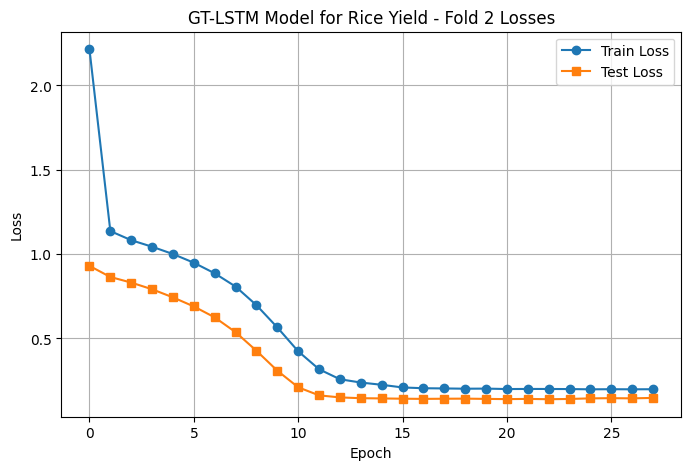


Fold 3/10 - Test Years: [np.int64(2006), np.int64(2007), np.int64(2008)]
Fold 3 Epoch [1/50] - Train Loss: 2.1524, Test Loss: 1.2711, Train RMSE: 1.4671, Test RMSE: 1.1274, Train R²: -1.0166, Test R²: -0.0900
Fold 3 Epoch [2/50] - Train Loss: 1.0859, Test Loss: 1.2467, Train RMSE: 1.0421, Test RMSE: 1.1165, Train R²: -0.0174, Test R²: -0.0691
Fold 3 Epoch [3/50] - Train Loss: 1.0424, Test Loss: 1.2252, Train RMSE: 1.0210, Test RMSE: 1.1069, Train R²: 0.0234, Test R²: -0.0507
Fold 3 Epoch [4/50] - Train Loss: 1.0122, Test Loss: 1.1825, Train RMSE: 1.0061, Test RMSE: 1.0874, Train R²: 0.0517, Test R²: -0.0141
Fold 3 Epoch [5/50] - Train Loss: 0.9750, Test Loss: 1.1369, Train RMSE: 0.9874, Test RMSE: 1.0663, Train R²: 0.0866, Test R²: 0.0250
Fold 3 Epoch [6/50] - Train Loss: 0.9337, Test Loss: 1.0933, Train RMSE: 0.9663, Test RMSE: 1.0456, Train R²: 0.1253, Test R²: 0.0624
Fold 3 Epoch [7/50] - Train Loss: 0.8864, Test Loss: 1.0270, Train RMSE: 0.9415, Test RMSE: 1.0134, Train R²: 0.1695

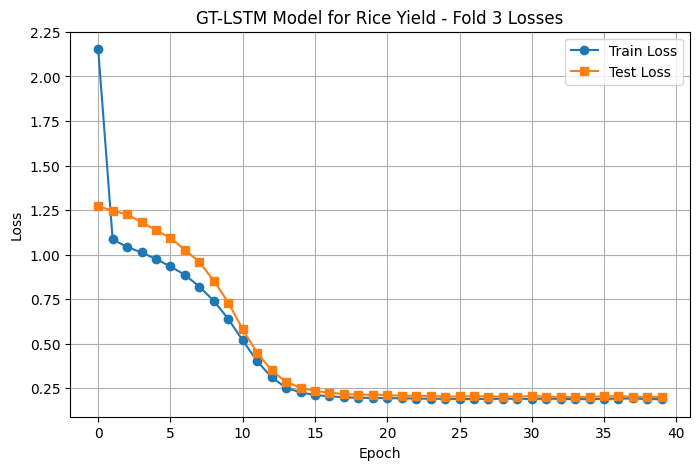


Fold 4/10 - Test Years: [np.int64(2009), np.int64(2010)]
Fold 4 Epoch [1/50] - Train Loss: 2.0475, Test Loss: 1.3674, Train RMSE: 1.4309, Test RMSE: 1.1694, Train R²: -0.8985, Test R²: -0.2420
Fold 4 Epoch [2/50] - Train Loss: 1.0696, Test Loss: 1.1895, Train RMSE: 1.0342, Test RMSE: 1.0906, Train R²: 0.0083, Test R²: -0.0804
Fold 4 Epoch [3/50] - Train Loss: 1.0121, Test Loss: 1.1625, Train RMSE: 1.0060, Test RMSE: 1.0782, Train R²: 0.0616, Test R²: -0.0559
Fold 4 Epoch [4/50] - Train Loss: 0.9553, Test Loss: 1.1070, Train RMSE: 0.9774, Test RMSE: 1.0521, Train R²: 0.1142, Test R²: -0.0055
Fold 4 Epoch [5/50] - Train Loss: 0.8942, Test Loss: 1.0198, Train RMSE: 0.9456, Test RMSE: 1.0098, Train R²: 0.1709, Test R²: 0.0738
Fold 4 Epoch [6/50] - Train Loss: 0.8230, Test Loss: 0.9642, Train RMSE: 0.9072, Test RMSE: 0.9820, Train R²: 0.2369, Test R²: 0.1242
Fold 4 Epoch [7/50] - Train Loss: 0.7406, Test Loss: 0.8406, Train RMSE: 0.8606, Test RMSE: 0.9168, Train R²: 0.3133, Test R²: 0.2365

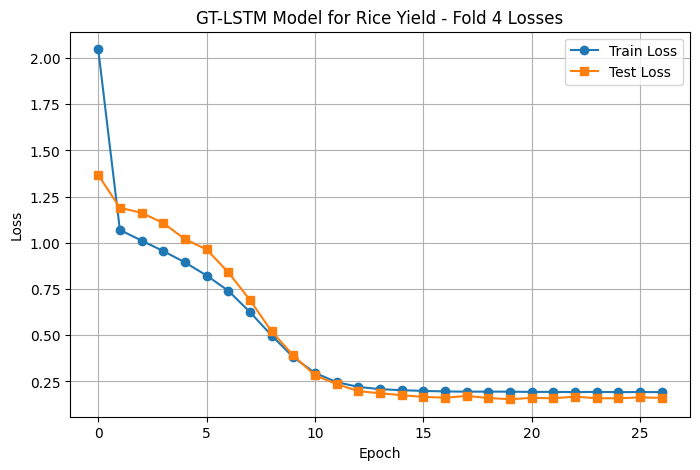


Fold 5/10 - Test Years: [np.int64(2011), np.int64(2012)]
Fold 5 Epoch [1/50] - Train Loss: 1.7615, Test Loss: 1.0516, Train RMSE: 1.3272, Test RMSE: 1.0255, Train R²: -0.6027, Test R²: -0.1334
Fold 5 Epoch [2/50] - Train Loss: 1.0880, Test Loss: 1.0089, Train RMSE: 1.0431, Test RMSE: 1.0044, Train R²: 0.0101, Test R²: -0.0874
Fold 5 Epoch [3/50] - Train Loss: 1.0440, Test Loss: 0.9750, Train RMSE: 1.0218, Test RMSE: 0.9874, Train R²: 0.0501, Test R²: -0.0509
Fold 5 Epoch [4/50] - Train Loss: 1.0056, Test Loss: 0.9307, Train RMSE: 1.0028, Test RMSE: 0.9647, Train R²: 0.0851, Test R²: -0.0031
Fold 5 Epoch [5/50] - Train Loss: 0.9587, Test Loss: 0.8786, Train RMSE: 0.9791, Test RMSE: 0.9373, Train R²: 0.1277, Test R²: 0.0531
Fold 5 Epoch [6/50] - Train Loss: 0.8946, Test Loss: 0.7990, Train RMSE: 0.9458, Test RMSE: 0.8939, Train R²: 0.1860, Test R²: 0.1388
Fold 5 Epoch [7/50] - Train Loss: 0.8038, Test Loss: 0.7139, Train RMSE: 0.8966, Test RMSE: 0.8449, Train R²: 0.2686, Test R²: 0.2305

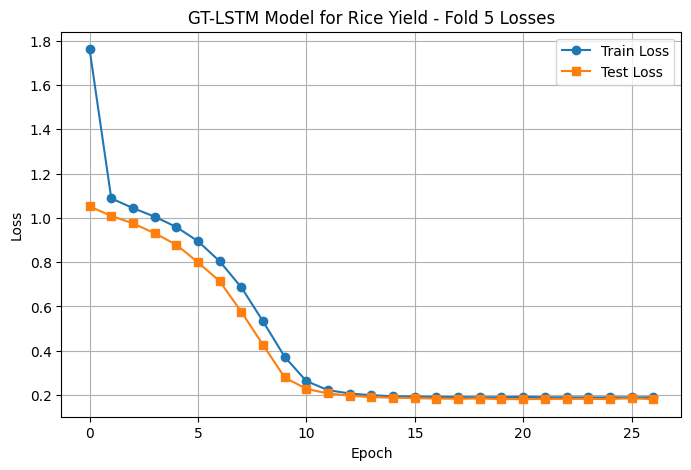


Fold 6/10 - Test Years: [np.int64(2013), np.int64(2014)]
Fold 6 Epoch [1/50] - Train Loss: 1.5964, Test Loss: 1.1916, Train RMSE: 1.2635, Test RMSE: 1.0916, Train R²: -0.4770, Test R²: -0.1012
Fold 6 Epoch [2/50] - Train Loss: 1.0648, Test Loss: 1.1583, Train RMSE: 1.0319, Test RMSE: 1.0762, Train R²: 0.0148, Test R²: -0.0704
Fold 6 Epoch [3/50] - Train Loss: 1.0306, Test Loss: 1.1168, Train RMSE: 1.0152, Test RMSE: 1.0568, Train R²: 0.0465, Test R²: -0.0320
Fold 6 Epoch [4/50] - Train Loss: 0.9860, Test Loss: 1.0563, Train RMSE: 0.9930, Test RMSE: 1.0277, Train R²: 0.0878, Test R²: 0.0239
Fold 6 Epoch [5/50] - Train Loss: 0.9250, Test Loss: 0.9795, Train RMSE: 0.9617, Test RMSE: 0.9897, Train R²: 0.1442, Test R²: 0.0949
Fold 6 Epoch [6/50] - Train Loss: 0.8544, Test Loss: 0.8877, Train RMSE: 0.9243, Test RMSE: 0.9422, Train R²: 0.2095, Test R²: 0.1797
Fold 6 Epoch [7/50] - Train Loss: 0.7593, Test Loss: 0.7543, Train RMSE: 0.8714, Test RMSE: 0.8685, Train R²: 0.2975, Test R²: 0.3030


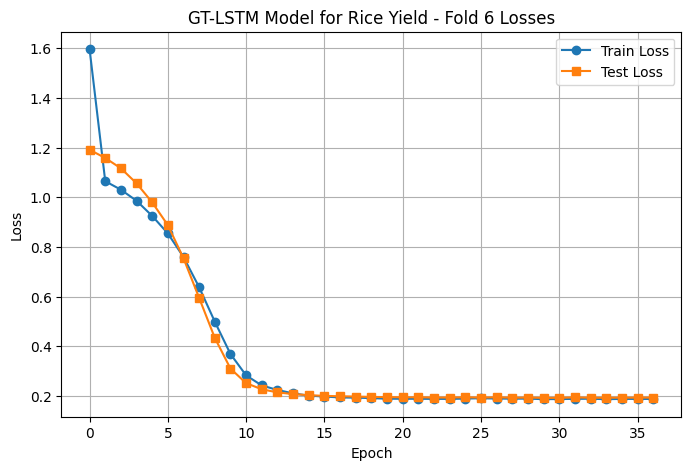


Fold 7/10 - Test Years: [np.int64(2015), np.int64(2016)]
Fold 7 Epoch [1/50] - Train Loss: 1.7125, Test Loss: 1.2241, Train RMSE: 1.3086, Test RMSE: 1.1064, Train R²: -0.5699, Test R²: -0.2126
Fold 7 Epoch [2/50] - Train Loss: 1.0741, Test Loss: 1.1501, Train RMSE: 1.0364, Test RMSE: 1.0724, Train R²: 0.0153, Test R²: -0.1393
Fold 7 Epoch [3/50] - Train Loss: 1.0332, Test Loss: 1.1143, Train RMSE: 1.0165, Test RMSE: 1.0556, Train R²: 0.0528, Test R²: -0.1038
Fold 7 Epoch [4/50] - Train Loss: 0.9958, Test Loss: 1.0721, Train RMSE: 0.9979, Test RMSE: 1.0354, Train R²: 0.0871, Test R²: -0.0620
Fold 7 Epoch [5/50] - Train Loss: 0.9531, Test Loss: 1.0121, Train RMSE: 0.9763, Test RMSE: 1.0060, Train R²: 0.1263, Test R²: -0.0026
Fold 7 Epoch [6/50] - Train Loss: 0.8981, Test Loss: 0.9656, Train RMSE: 0.9477, Test RMSE: 0.9826, Train R²: 0.1767, Test R²: 0.0435
Fold 7 Epoch [7/50] - Train Loss: 0.8286, Test Loss: 0.8640, Train RMSE: 0.9103, Test RMSE: 0.9295, Train R²: 0.2404, Test R²: 0.144

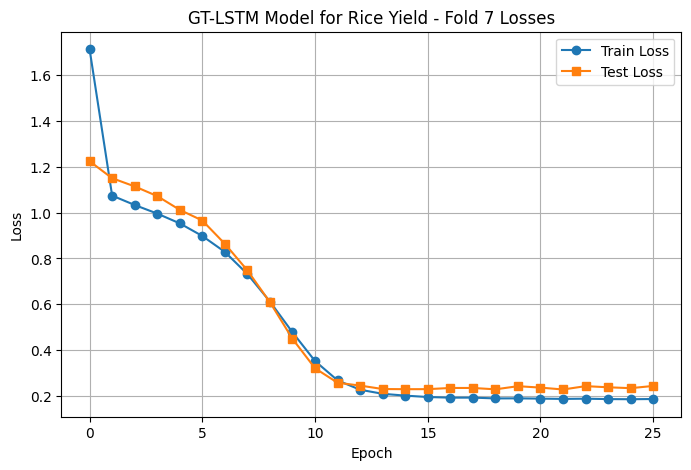


Fold 8/10 - Test Years: [np.int64(2017), np.int64(2018)]
Fold 8 Epoch [1/50] - Train Loss: 1.7862, Test Loss: 1.0964, Train RMSE: 1.3365, Test RMSE: 1.0471, Train R²: -0.6522, Test R²: -0.0410
Fold 8 Epoch [2/50] - Train Loss: 1.0795, Test Loss: 1.0766, Train RMSE: 1.0390, Test RMSE: 1.0376, Train R²: 0.0015, Test R²: -0.0221
Fold 8 Epoch [3/50] - Train Loss: 1.0462, Test Loss: 1.0295, Train RMSE: 1.0228, Test RMSE: 1.0146, Train R²: 0.0324, Test R²: 0.0226
Fold 8 Epoch [4/50] - Train Loss: 1.0012, Test Loss: 0.9852, Train RMSE: 1.0006, Test RMSE: 0.9926, Train R²: 0.0739, Test R²: 0.0647
Fold 8 Epoch [5/50] - Train Loss: 0.9431, Test Loss: 0.9276, Train RMSE: 0.9712, Test RMSE: 0.9631, Train R²: 0.1276, Test R²: 0.1194
Fold 8 Epoch [6/50] - Train Loss: 0.8742, Test Loss: 0.8492, Train RMSE: 0.9350, Test RMSE: 0.9215, Train R²: 0.1914, Test R²: 0.1937
Fold 8 Epoch [7/50] - Train Loss: 0.7953, Test Loss: 0.7476, Train RMSE: 0.8918, Test RMSE: 0.8646, Train R²: 0.2644, Test R²: 0.2902
F

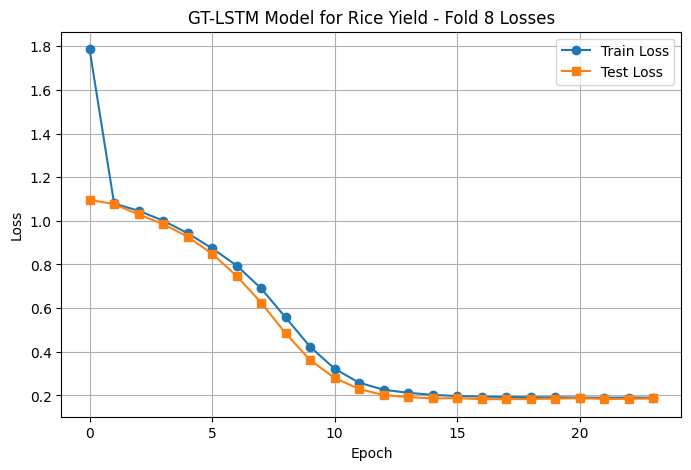


Fold 9/10 - Test Years: [np.int64(2019), np.int64(2020)]
Fold 9 Epoch [1/50] - Train Loss: 1.7835, Test Loss: 1.2181, Train RMSE: 1.3355, Test RMSE: 1.1037, Train R²: -0.6845, Test R²: -0.0771
Fold 9 Epoch [2/50] - Train Loss: 1.0705, Test Loss: 1.2000, Train RMSE: 1.0347, Test RMSE: 1.0954, Train R²: -0.0111, Test R²: -0.0611
Fold 9 Epoch [3/50] - Train Loss: 1.0363, Test Loss: 1.1668, Train RMSE: 1.0180, Test RMSE: 1.0802, Train R²: 0.0213, Test R²: -0.0318
Fold 9 Epoch [4/50] - Train Loss: 0.9948, Test Loss: 1.1453, Train RMSE: 0.9974, Test RMSE: 1.0702, Train R²: 0.0604, Test R²: -0.0128
Fold 9 Epoch [5/50] - Train Loss: 0.9395, Test Loss: 1.0760, Train RMSE: 0.9693, Test RMSE: 1.0373, Train R²: 0.1126, Test R²: 0.0485
Fold 9 Epoch [6/50] - Train Loss: 0.8668, Test Loss: 0.9924, Train RMSE: 0.9310, Test RMSE: 0.9962, Train R²: 0.1813, Test R²: 0.1225
Fold 9 Epoch [7/50] - Train Loss: 0.7772, Test Loss: 0.9028, Train RMSE: 0.8816, Test RMSE: 0.9502, Train R²: 0.2659, Test R²: 0.201

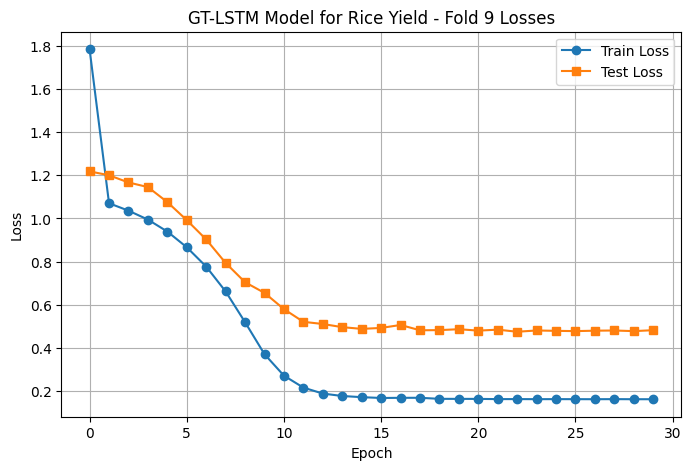


Fold 10/10 - Test Years: [np.int64(2021), np.int64(2022)]
Fold 10 Epoch [1/50] - Train Loss: 1.8366, Test Loss: 0.8703, Train RMSE: 1.3552, Test RMSE: 0.9329, Train R²: -0.6793, Test R²: -0.0859
Fold 10 Epoch [2/50] - Train Loss: 1.1103, Test Loss: 0.8274, Train RMSE: 1.0537, Test RMSE: 0.9096, Train R²: -0.0152, Test R²: -0.0323
Fold 10 Epoch [3/50] - Train Loss: 1.0502, Test Loss: 0.7713, Train RMSE: 1.0248, Test RMSE: 0.8782, Train R²: 0.0397, Test R²: 0.0377
Fold 10 Epoch [4/50] - Train Loss: 0.9985, Test Loss: 0.7238, Train RMSE: 0.9992, Test RMSE: 0.8508, Train R²: 0.0870, Test R²: 0.0970
Fold 10 Epoch [5/50] - Train Loss: 0.9378, Test Loss: 0.6521, Train RMSE: 0.9684, Test RMSE: 0.8075, Train R²: 0.1425, Test R²: 0.1864
Fold 10 Epoch [6/50] - Train Loss: 0.8541, Test Loss: 0.5705, Train RMSE: 0.9242, Test RMSE: 0.7553, Train R²: 0.2190, Test R²: 0.2882
Fold 10 Epoch [7/50] - Train Loss: 0.7440, Test Loss: 0.4741, Train RMSE: 0.8625, Test RMSE: 0.6886, Train R²: 0.3197, Test R²:

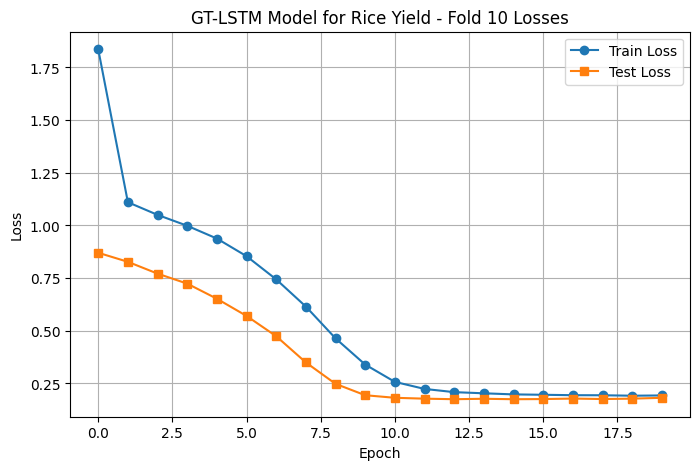


Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4344 (±0.0109)
Average Train R²: 0.8258 (±0.0074)
Average Test RMSE: 0.4537 (±0.0858)
Average Test R²: 0.7903 (±0.0776)
Cross-validation results saved to /content/gt_lstm_rice_yield_predictions.csv

District-wise Metrics:
Average RMSE: 0.3884 (±0.2379)
Average R²: 0.3070 (±0.2689)
Number of Negative R² Districts: 48
Worst 5 Districts by R²:
       District      RMSE        R2       MAE
33       Bijnor  0.201935 -0.263892  0.166292
150  Kushinagar  0.322304 -0.259628  0.227064
32      Bhiwani  0.458974 -0.211062  0.357609
146   Kozhikode  0.355416 -0.207668  0.220620
40       Chamba  0.268393 -0.180491  0.224951

Top 5 districts connected to District Amritsar (Index 7):
  District Kapurthala (Index 126): Weight = 0.505
  District Gurdaspur (Index 91): Weight = 0.503
  District Jalandhar (Index 107): Weight = 0.503
  District Moga (Index 173): Weight = 0.503
  District Hoshiarpur (Index 102): Weight = 0.50

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv
from math import radians, sin, cos, sqrt, atan2
import plotly.graph_objects as go

# Set seeds for reproducibility
SEED = 4
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Parameters
num_districts = 292
num_years = 23
months = 3
climate_unique = 9
rs_unique = 4
climate_features = climate_unique * months
rs_features = rs_unique * months

# Load and preprocess data
climate_data = pd.read_csv('/content/cp_sowing_month_cp_stage2.csv')
climate_features_cols = [col for col in climate_data.columns if col not in ['District', 'year']]
climate_data_values = climate_data[climate_features_cols].values
scaler_cp = StandardScaler()
climate_data_normalized = scaler_cp.fit_transform(climate_data_values)
climate_data_reshaped = climate_data_normalized.reshape(num_years, num_districts, months, climate_unique).transpose(0, 1, 2, 3)
climate_data_tensor = torch.tensor(climate_data_reshaped, dtype=torch.float32)

rs_data = pd.read_csv('/content/rs_sowing_month_rs_stage2.csv')
rs_features_cols = [col for col in rs_data.columns if col not in ['District', 'year']]
rs_data_values = rs_data[rs_features_cols].values
scaler_rs = StandardScaler()
rs_data_normalized = scaler_rs.fit_transform(rs_data_values)
rs_data_reshaped = rs_data_normalized.reshape(num_years, num_districts, months, rs_unique).transpose(0, 1, 2, 3)
rs_data_tensor = torch.tensor(rs_data_reshaped, dtype=torch.float32)

yield_data = pd.read_csv('/content/detrended_rice_district_yield_sens_slope.csv')
district_names = yield_data['District'].unique()
district_name_to_index = {name: idx for idx, name in enumerate(district_names)}
yield_data['District'] = yield_data['District'].map(district_name_to_index)
yield_values = yield_data[['Year', 'Detrended_Yield', 'District', 'Trend', 'Actual']].values
years = yield_values[:, 0].astype(int)
detrended_yields = yield_values[:, 1]
districts = yield_values[:, 2].astype(int)
trends = yield_values[:, 3]
actual_yields = yield_values[:, 4]
district_mapping_df = pd.DataFrame(list(district_name_to_index.items()), columns=['District_Name', 'District_Index'])
district_mapping_df.to_csv('/content/district_name_to_index_rice.csv', index=False)

district_yields = np.zeros((num_districts, num_years))
trends_per_district = np.zeros((num_districts, num_years))
actual_yields_per_district = np.zeros((num_districts, num_years))
for i in range(len(years)):
    district_index = districts[i]
    year_index = years[i] - 2000
    district_yields[district_index, year_index] = detrended_yields[i]
    trends_per_district[district_index, year_index] = trends[i]
    actual_yields_per_district[district_index, year_index] = actual_yields[i]

district_yields_tensor = torch.tensor(district_yields, dtype=torch.float32)
trends_tensor = torch.tensor(trends_per_district, dtype=torch.float32)
actual_yields_tensor = torch.tensor(actual_yields_per_district, dtype=torch.float32)

# Load centroid data (only needed for visualization and edge weights initialization)
centroid_df = pd.read_csv('/content/district_centroid_file.csv')
lat_col = next((col for col in centroid_df.columns if 'lat' in col.lower()), 'centroid_y')  # Assuming centroid_y is latitude
lon_col = next((col for col in centroid_df.columns if 'lon' in col.lower()), 'centroid_x')  # Assuming centroid_x is longitude
centroid_df = centroid_df.rename(columns={lat_col: 'latitude', lon_col: 'longitude'})
centroid_df = centroid_df.dropna(subset=['latitude', 'longitude'])
valid_centroids = centroid_df[
    (centroid_df['latitude'].between(8, 37)) &
    (centroid_df['longitude'].between(68, 97))
]
if len(valid_centroids) < len(centroid_df):
    print(f"Warning: {len(centroid_df) - len(valid_centroids)} invalid coordinates removed.")
    centroid_df = valid_centroids

# Function for consecutive GroupKFold splits
def consecutive_group_kfold(df, n_splits=10):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)
    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define the GT-LSTM Model with Edge Weights in GAT
class GTLSTMYieldPrediction(nn.Module):
    def __init__(self, num_districts=292, climate_features=18, rs_features=8,
                 hidden_dim=512, embedding_size=32, num_layers=8, heads=1):
        super(GTLSTMYieldPrediction, self).__init__()
        self.num_districts = num_districts
        self.embedding_size = embedding_size
        self.heads = heads

        # LSTM layers
        self.climate_lstm = nn.LSTM(input_size=climate_unique, hidden_size=hidden_dim,
                                    num_layers=num_layers, batch_first=True)
        self.rs_lstm = nn.LSTM(input_size=rs_unique, hidden_size=hidden_dim,
                               num_layers=num_layers, batch_first=True)

        # Dense layer to combine temporal embeddings
        self.dense = nn.Sequential(
            nn.Linear(hidden_dim * 2, embedding_size),
            nn.ReLU(),
            nn.LayerNorm(embedding_size)
        )

        # GAT layers
        self.gat1 = GATConv(in_channels=embedding_size, out_channels=embedding_size // heads, heads=heads, dropout=0.2)
        self.gat2 = GATConv(in_channels=embedding_size, out_channels=embedding_size, heads=1, dropout=0.2)
        self.norm2 = nn.LayerNorm(embedding_size)

        # Output layer
        self.yield_mlp = nn.Sequential(
            nn.Linear(embedding_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Edge weights initialization (updated to use centroid_y as latitude)
        try:
            districts_df = pd.read_csv('/content/district_centroid_file.csv')
            lat_col = next((col for col in districts_df.columns if 'lat' in col.lower()), 'centroid_y')  # Assuming centroid_y is latitude
            lon_col = next((col for col in districts_df.columns if 'lon' in col.lower()), 'centroid_x')  # Assuming centroid_x is longitude
            districts_df = districts_df.rename(columns={lat_col: 'latitude', lon_col: 'longitude'})
            districts_df = districts_df.dropna(subset=['latitude', 'longitude'])
            valid_districts = districts_df[
                (districts_df['latitude'].between(8, 37)) &
                (districts_df['longitude'].between(68, 97))
            ]
            if len(valid_districts) < len(districts_df):
                print(f"Warning: {len(districts_df) - len(valid_districts)} invalid coordinates removed.")
                districts_df = valid_districts

            district_to_centroid = dict(zip(np.arange(len(districts_df)),
                                         districts_df[['latitude', 'longitude']].values))
            if len(district_to_centroid) != num_districts:
                print(f"Warning: Number of districts in centroid file ({len(district_to_centroid)}) does not match num_districts ({num_districts}). Initializing edge_weights randomly.")
                self.edge_weights = nn.Parameter(torch.randn(num_districts, num_districts))
            else:
                distance_matrix = np.zeros((num_districts, num_districts))
                for i in range(num_districts):
                    for j in range(num_districts):
                        if i != j and i in district_to_centroid and j in district_to_centroid:
                            distance_matrix[i, j] = haversine_distance(
                                district_to_centroid[i][0], district_to_centroid[i][1],
                                district_to_centroid[j][0], district_to_centroid[j][1]
                            )
                        else:
                            distance_matrix[i, j] = np.inf
                MAX_DISTANCE_KM = 500
                edge_weights_init = np.where(distance_matrix <= MAX_DISTANCE_KM,
                                            1 / (distance_matrix + 1e-6), 0)
                self.edge_weights = nn.Parameter(torch.tensor(edge_weights_init, dtype=torch.float32))
        except FileNotFoundError:
            print("Warning: district_centroid_file.csv not found. Initializing edge_weights randomly.")
            self.edge_weights = nn.Parameter(torch.randn(num_districts, num_districts))

        self.residual_scale = nn.Parameter(torch.ones(num_districts, 1))

    def forward(self, climate_data, rs_data):
        # Process temporal data
        climate_out, _ = self.climate_lstm(climate_data)
        rs_out, _ = self.rs_lstm(rs_data)
        climate_emb = climate_out[:, -1, :]  # Shape: [292, 512]
        rs_emb = rs_out[:, -1, :]            # Shape: [292, 512]

        # Combine temporal embeddings
        combined_emb = torch.cat([climate_emb, rs_emb], dim=-1)  # Shape: [292, 1024]
        dense_out = self.dense(combined_emb)  # Shape: [292, 32]

        # GAT processing with edge weights
        adj_matrix = torch.sigmoid(self.edge_weights)  # Shape: [292, 292], values in (0, 1)
        adj_matrix = adj_matrix * (1 - torch.eye(self.num_districts, device=adj_matrix.device))  # Remove self-loops
        edge_index = (adj_matrix > 0.7).nonzero(as_tuple=False).t().contiguous()  # Shape: [2, num_edges], threshold aligned with Code 1
        edge_weight = adj_matrix[edge_index[0], edge_index[1]]  # Shape: [num_edges], weights for each edge

        # Apply GAT layers with edge weights
        gat_out = self.gat1(dense_out, edge_index, edge_weight)  # Shape: [292, 32 // heads * heads]
        gat_out = torch.relu(gat_out)
        gat_out = self.gat2(gat_out, edge_index, edge_weight)  # Shape: [292, 32]
        gat_out = torch.relu(gat_out)
        gat_out = self.norm2(gat_out)

        # Scaled residual connection
        scaled_residual = dense_out * self.residual_scale  # Shape: [292, 32]
        combined_out = gat_out + scaled_residual  # Shape: [292, 32]

        # Predict district-level yields
        district_yields = self.yield_mlp(combined_out)  # Shape: [292, 1]
        return district_yields

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Cross-validation setup
n_splits = 10
fold_train_rmses = []
fold_train_r2s = []
fold_test_rmses = []
fold_test_r2s = []
all_results = []
fold_edge_weights = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cross-validation loop using consecutive_group_kfold
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(yield_data, n_splits=n_splits)):
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"\nFold {fold + 1}/{n_splits} - Test Years: {test_years}")

    train_indices = np.array([y - 2000 for y in train_years])
    test_indices = np.array([y - 2000 for y in test_years])

    if len(set(train_years + test_years)) != num_years:
        print(f"Error: Fold {fold + 1} does not cover all years.")
        raise ValueError("Fold configuration invalid")

    train_climate = climate_data_tensor[train_indices]
    train_rs = rs_data_tensor[train_indices]
    train_yields = district_yields_tensor[:, train_indices]
    train_trends = trends_tensor[:, train_indices]
    train_actual = actual_yields_tensor[:, train_indices]
    test_climate = climate_data_tensor[test_indices]
    test_rs = rs_data_tensor[test_indices]
    test_yields = district_yields_tensor[:, test_indices]
    test_trends = trends_tensor[:, test_indices]
    test_actual = actual_yields_tensor[:, test_indices]

    model = GTLSTMYieldPrediction().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
    criterion = nn.MSELoss()

    patience = 7
    min_delta = 0.001
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    train_losses = []
    test_losses = []

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_targets = []
        for year_idx in range(len(train_indices)):
            climate_batch = train_climate[year_idx].to(device)
            rs_batch = train_rs[year_idx].to(device)
            trend_batch = train_trends[:, year_idx:year_idx+1].to(device)
            actual_batch = train_actual[:, year_idx:year_idx+1].to(device)
            pred = model(climate_batch, rs_batch)
            predicted_yields = pred + trend_batch
            loss = criterion(predicted_yields, actual_batch)
            train_loss += loss.item()
            all_train_preds.extend(predicted_yields.detach().cpu().numpy())
            all_train_targets.extend(actual_batch.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_indices)
        train_losses.append(avg_train_loss)
        train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_preds))
        train_r2 = r2_score(all_train_targets, all_train_preds)

        model.eval()
        test_loss = 0
        all_test_preds = []
        all_test_targets = []
        with torch.no_grad():
            for year_idx in range(len(test_indices)):
                climate_batch = test_climate[year_idx].to(device)
                rs_batch = test_rs[year_idx].to(device)
                trend_batch = test_trends[:, year_idx:year_idx+1].to(device)
                actual_batch = test_actual[:, year_idx:year_idx+1].to(device)
                pred = model(climate_batch, rs_batch)
                predicted_yields = pred + trend_batch
                loss = criterion(predicted_yields, actual_batch)
                test_loss += loss.item()
                all_test_preds.extend(predicted_yields.cpu().numpy())
                all_test_targets.extend(actual_batch.cpu().numpy())

        avg_test_loss = test_loss / len(test_indices)
        test_losses.append(avg_test_loss)
        test_rmse = np.sqrt(mean_squared_error(all_test_targets, all_test_preds))
        test_r2 = r2_score(all_test_targets, all_test_preds)

        print(f"Fold {fold + 1} Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, "
              f"Test Loss: {avg_test_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, "
              f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

        if avg_test_loss < best_val_loss - min_delta:
            best_val_loss = avg_test_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    fold_edge_weights.append(model.edge_weights.detach().cpu().numpy())
    fold_train_rmses.append(train_rmse)
    fold_train_r2s.append(train_r2)
    fold_test_rmses.append(test_rmse)
    fold_test_r2s.append(test_r2)

    for year_idx, year in enumerate(test_indices):
        preds = all_test_preds[year_idx * num_districts:(year_idx + 1) * num_districts]
        targets = all_test_targets[year_idx * num_districts:(year_idx + 1) * num_districts]
        for district in range(num_districts):
            actual_yield = actual_yields_per_district[district, year].item()
            predicted_yield = preds[district][0] if isinstance(preds[district], np.ndarray) else preds[district]
            all_results.append({
                'Fold': fold + 1,
                'Year': 2000 + year,
                'District': district_names[district],
                'Actual_Yield': actual_yield,
                'Predicted_Yield': predicted_yield
            })

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='s')
    plt.title(f'GT-LSTM Model for Rice Yield - Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

# Compute and print overall metrics
avg_train_rmse = np.mean(fold_train_rmses)
avg_train_r2 = np.mean(fold_train_r2s)
avg_test_rmse = np.mean(fold_test_rmses)
avg_test_r2 = np.mean(fold_test_r2s)

print("\nOverall Cross-Validation Metrics for Rice Yield Prediction:")
print(f"Average Train RMSE: {avg_train_rmse:.4f} (±{np.std(fold_train_rmses):.4f})")
print(f"Average Train R²: {avg_train_r2:.4f} (±{np.std(fold_train_r2s):.4f})")
print(f"Average Test RMSE: {avg_test_rmse:.4f} (±{np.std(fold_test_rmses):.4f})")
print(f"Average Test R²: {avg_test_r2:.4f} (±{np.std(fold_test_r2s):.4f})")

results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/gt_lstm_rice_yield_predictions.csv', index=False)
print(f"Cross-validation results saved to /content/gt_lstm_rice_yield_predictions.csv")

# Compute district-wise metrics
district_metrics = []
for district_idx in range(num_districts):
    district_actual = actual_yields_per_district[district_idx]
    district_results = results_df[results_df['District'] == district_names[district_idx]]
    district_pred = np.zeros(num_years)
    for year in range(num_years):
        year_result = district_results[district_results['Year'] == 2000 + year]
        if not year_result.empty:
            district_pred[year] = year_result['Predicted_Yield'].iloc[0]
        else:
            model.eval()
            with torch.no_grad():
                climate_batch = climate_data_tensor[year:year+1, district_idx:district_idx+1].to(device)
                rs_batch = rs_data_tensor[year:year+1, district_idx:district_idx+1].to(device)
                pred = model(climate_batch.squeeze(0), rs_batch.squeeze(0))
                trend_batch = trends_tensor[district_idx:district_idx+1, year:year+1]
                district_pred[year] = (pred + trend_batch).cpu().numpy().item()
    rmse = np.sqrt(mean_squared_error(district_actual, district_pred))
    r2 = r2_score(district_actual, district_pred)
    mae = np.mean(np.abs(district_actual - district_pred))
    district_metrics.append({
        'District': district_names[district_idx],
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    })

district_metrics_df = pd.DataFrame(district_metrics)
district_metrics_df.to_csv('/content/district_metrics_rice.csv', index=False)
print("\nDistrict-wise Metrics:")
print(f"Average RMSE: {district_metrics_df['RMSE'].mean():.4f} (±{district_metrics_df['RMSE'].std():.4f})")
print(f"Average R²: {district_metrics_df['R2'].mean():.4f} (±{district_metrics_df['R2'].std():.4f})")
print(f"Number of Negative R² Districts: {(district_metrics_df['R2'] < 0).sum()}")
print("Worst 5 Districts by R²:")
print(district_metrics_df.sort_values('R2').head(5)[['District', 'RMSE', 'R2', 'MAE']])

# Plot connections for district 7
avg_edge_weights = np.mean(fold_edge_weights, axis=0)
adj_matrix = torch.sigmoid(torch.tensor(avg_edge_weights, dtype=torch.float32))
adj_matrix = adj_matrix * (1 - torch.eye(num_districts))
edge_index = (adj_matrix > 0.5).nonzero(as_tuple=False).t().cpu().numpy()
edge_weights_map = adj_matrix[edge_index[0], edge_index[1]].cpu().numpy()

try:
    districts_df = pd.read_csv('/content/district_centroid_file.csv')
    lat_col = next((col for col in districts_df.columns if 'lat' in col.lower()), 'centroid_y')  # Assuming centroid_y is latitude
    lon_col = next((col for col in districts_df.columns if 'lon' in col.lower()), 'centroid_x')  # Assuming centroid_x is longitude
    districts_df = districts_df.rename(columns={lat_col: 'latitude', lon_col: 'longitude'})
    districts_df = districts_df.dropna(subset=['latitude', 'longitude'])
    valid_districts = districts_df[
        (districts_df['latitude'].between(8, 37)) &
        (districts_df['longitude'].between(68, 97))
    ]
    if len(valid_districts) < len(districts_df):
        print(f"Warning: {len(districts_df) - len(valid_districts)} invalid coordinates removed.")
        districts_df = valid_districts

    district_to_centroid = dict(zip(np.arange(len(districts_df)),
                                   districts_df[['latitude', 'longitude']].values))
    if len(district_to_centroid) != num_districts:
        print(f"Warning: Number of districts in centroid file ({len(district_to_centroid)}) does not match num_districts ({num_districts}). Skipping visualization.")
        raise ValueError("Mismatch in district count")
except (FileNotFoundError, ValueError) as e:
    print(f"Error: {e}. Cannot generate Mapbox visualization without valid centroid data.")
else:
    district_1 = 7
    connected_indices = edge_index[1][edge_index[0] == district_1]
    if len(connected_indices) > 0:
        edge_mask = edge_index[0] == district_1
        relevant_weights = edge_weights_map[edge_mask]
        relevant_targets = connected_indices
        top_5_indices = relevant_targets[np.argsort(relevant_weights)[::-1][:min(5, len(relevant_weights))]]
        print(f"\nTop 5 districts connected to District {district_names[district_1]} (Index {district_1}):")
        for idx, weight in zip(top_5_indices, [relevant_weights[np.where(relevant_targets == i)[0][0]] for i in top_5_indices]):
            print(f"  District {district_names[idx]} (Index {idx}): Weight = {weight:.3f}")
    else:
        top_5_indices = np.array([], dtype=int)
        print(f"No connections found for District {district_names[district_1]} (Index {district_1}).")

    district_1_centroid = district_to_centroid[district_1]
    connected_centroids = [district_to_centroid[idx] for idx in top_5_indices if idx in district_to_centroid]
    num_connected_districts = len(top_5_indices)

    lat = [district_1_centroid[0]] + [centroid[0] for centroid in connected_centroids]
    lon = [district_1_centroid[1]] + [centroid[1] for centroid in connected_centroids]
    names = [district_names[district_1]] + [district_names[idx] for idx in top_5_indices if idx < len(district_names)]
    weights = [1.0] + [relevant_weights[np.where(relevant_targets == idx)[0][0]] for idx in top_5_indices if idx in relevant_targets]
    selected_weights = [f"{w:.4f}" for w in weights]

    fig = go.Figure()
    for i in range(len(connected_centroids)):
        delta_lat = connected_centroids[i][0] - district_1_centroid[0]
        delta_lon = connected_centroids[i][1] - district_1_centroid[1]
        distance = np.sqrt(delta_lat**2 + delta_lon**2)
        if distance == 0:
            continue
        direction_lat = delta_lat / distance
        direction_lon = delta_lon / distance
        offset = 0.1
        start_lat = district_1_centroid[0] + direction_lat * offset
        start_lon = district_1_centroid[1] + direction_lon * offset
        fig.add_trace(go.Scattermapbox(
            lat=[start_lat, connected_centroids[i][0]],
            lon=[start_lon, connected_centroids[i][1]],
            mode="lines",
            line=dict(width=1, color="gray"),
            hoverinfo="none",
            showlegend=False
        ))

    fig.add_trace(go.Scattermapbox(
        lat=[centroid[0] for centroid in connected_centroids],
        lon=[centroid[1] for centroid in connected_centroids],
        mode="markers+text",
        marker=dict(size=12, color="blue"),
        text=selected_weights[1:],
        textfont=dict(size=12, color="black"),
        textposition="top center",
        name="Connected Districts"
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[district_1_centroid[0]],
        lon=[district_1_centroid[1]],
        mode="markers+text",
        marker=dict(size=22, color="red", opacity=0.8),
        text=[str(num_connected_districts)],
        textfont=dict(size=14, color="black"),
        textposition="middle center",
        name=f"{district_names[district_1]} Centroid"
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": np.mean(lat), "lon": np.mean(lon)},
        mapbox_zoom=5,
        showlegend=True,
        title=f'Top 5 Connections for District {district_names[district_1]} with Distance Weights',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
    )

    fig.show()

```
with centroid_emb
Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4365 (±0.0122)
Average Train R²: 0.8240 (±0.0085)
Average Test RMSE: 0.4599 (±0.0838)
Average Test R²: 0.7856 (±0.0736)

without centroid emb
Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4406 (±0.0091)
Average Train R²: 0.8207 (±0.0064)
Average Test RMSE: 0.4552 (±0.0895)
Average Test R²: 0.7886 (±0.0814)
```

```
using centroid lon, lat in cp file
Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4413 (±0.0101)
Average Train R²: 0.8202 (±0.0071)
Average Test RMSE: 0.4644 (±0.0815)
Average Test R²: 0.7811 (±0.0735)

------------Average Yearly Metrics----------------
Average yearly RMSE: 0.4522
Average yearly R²: 0.7865

```

```
hidden_dim=512, embedding_size=32, num_layers=2, heads=4:
ep = 50 , p = 10

Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4879 (±0.0122)
Average Train R²: 0.7801 (±0.0107)
Average Test RMSE: 0.4733 (±0.0793)
Average Test R²: 0.7721 (±0.0755)

hidden_dim=512, embedding_size=32, num_layers=2, heads=1:
ep = 50 , p = 7
Overall Cross-Validation Metrics for Rice Yield Prediction:
Average Train RMSE: 0.4393 (±0.0133)
Average Train R²: 0.8218 (±0.0095)
Average Test RMSE: 0.4550 (±0.0857)
Average Test R²: 0.7892 (±0.0769)

hidden_dim=512, embedding_size=32, num_layers=8, heads=2
Average Train RMSE: 0.4378 (±0.0127)
Average Train R²: 0.8230 (±0.0092)
Average Test RMSE: 0.4510 (±0.0858)
Average Test R²: 0.7928 (±0.0764)


```

### top 5 neighbour

In [ ]:
# Plot connections for district 7
avg_edge_weights = np.mean(fold_edge_weights, axis=0)
adj_matrix = torch.sigmoid(torch.tensor(avg_edge_weights, dtype=torch.float32))
adj_matrix = adj_matrix * (1 - torch.eye(num_districts))
edge_index = (adj_matrix > 0.5).nonzero(as_tuple=False).t().cpu().numpy()
edge_weights_map = adj_matrix[edge_index[0], edge_index[1]].cpu().numpy()

try:
    districts_df = pd.read_csv('/content/district_centroid_file.csv')
    lat_col = next((col for col in districts_df.columns if 'lat' in col.lower()), 'centroid_y')  # Assuming centroid_y is latitude
    lon_col = next((col for col in districts_df.columns if 'lon' in col.lower()), 'centroid_x')  # Assuming centroid_x is longitude
    districts_df = districts_df.rename(columns={lat_col: 'latitude', lon_col: 'longitude'})
    districts_df = districts_df.dropna(subset=['latitude', 'longitude'])
    valid_districts = districts_df[
        (districts_df['latitude'].between(8, 37)) &
        (districts_df['longitude'].between(68, 97))
    ]
    if len(valid_districts) < len(districts_df):
        print(f"Warning: {len(districts_df) - len(valid_districts)} invalid coordinates removed.")
        districts_df = valid_districts

    district_to_centroid = dict(zip(np.arange(len(districts_df)),
                                   districts_df[['latitude', 'longitude']].values))
    if len(district_to_centroid) != num_districts:
        print(f"Warning: Number of districts in centroid file ({len(district_to_centroid)}) does not match num_districts ({num_districts}). Skipping visualization.")
        raise ValueError("Mismatch in district count")
except (FileNotFoundError, ValueError) as e:
    print(f"Error: {e}. Cannot generate Mapbox visualization without valid centroid data.")
else:
    district_1 = 5
    connected_indices = edge_index[1][edge_index[0] == district_1]
    if len(connected_indices) > 0:
        edge_mask = edge_index[0] == district_1
        relevant_weights = edge_weights_map[edge_mask]
        relevant_targets = connected_indices
        top_5_indices = relevant_targets[np.argsort(relevant_weights)[::-1][:min(5, len(relevant_weights))]]
        print(f"\nTop 5 districts connected to District {district_names[district_1]} (Index {district_1}):")
        for idx, weight in zip(top_5_indices, [relevant_weights[np.where(relevant_targets == i)[0][0]] for i in top_5_indices]):
            print(f"  District {district_names[idx]} (Index {idx}): Weight = {weight:.3f}")
    else:
        top_5_indices = np.array([], dtype=int)
        print(f"No connections found for District {district_names[district_1]} (Index {district_1}).")

    district_1_centroid = district_to_centroid[district_1]
    connected_centroids = [district_to_centroid[idx] for idx in top_5_indices if idx in district_to_centroid]
    num_connected_districts = len(top_5_indices)

    lat = [district_1_centroid[0]] + [centroid[0] for centroid in connected_centroids]
    lon = [district_1_centroid[1]] + [centroid[1] for centroid in connected_centroids]
    names = [district_names[district_1]] + [district_names[idx] for idx in top_5_indices if idx < len(district_names)]
    weights = [1.0] + [relevant_weights[np.where(relevant_targets == idx)[0][0]] for idx in top_5_indices if idx in relevant_targets]
    selected_weights = [f"{w:.4f}" for w in weights]

    fig = go.Figure()
    for i in range(len(connected_centroids)):
        delta_lat = connected_centroids[i][0] - district_1_centroid[0]
        delta_lon = connected_centroids[i][1] - district_1_centroid[1]
        distance = np.sqrt(delta_lat**2 + delta_lon**2)
        if distance == 0:
            continue
        direction_lat = delta_lat / distance
        direction_lon = delta_lon / distance
        offset = 0.1
        start_lat = district_1_centroid[0] + direction_lat * offset
        start_lon = district_1_centroid[1] + direction_lon * offset
        fig.add_trace(go.Scattermapbox(
            lat=[start_lat, connected_centroids[i][0]],
            lon=[start_lon, connected_centroids[i][1]],
            mode="lines",
            line=dict(width=1, color="gray"),
            hoverinfo="none",
            showlegend=False
        ))

    fig.add_trace(go.Scattermapbox(
        lat=[centroid[0] for centroid in connected_centroids],
        lon=[centroid[1] for centroid in connected_centroids],
        mode="markers+text",
        marker=dict(size=12, color="blue"),
        text=selected_weights[1:],
        textfont=dict(size=12, color="black"),
        textposition="top center",
        name="Connected Districts"
    ))

    fig.add_trace(go.Scattermapbox(
        lat=[district_1_centroid[0]],
        lon=[district_1_centroid[1]],
        mode="markers+text",
        marker=dict(size=22, color="red", opacity=0.8),
        text=[str(num_connected_districts)],
        textfont=dict(size=14, color="black"),
        textposition="middle center",
        name=f"{district_names[district_1]} Centroid"
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_center={"lat": np.mean(lat), "lon": np.mean(lon)},
        mapbox_zoom=5,
        showlegend=True,
        title=f'Top {min(5, len(relevant_weights))} Connections for District {district_names[district_1]} with Distance Weights',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
    )

    fig.show()


Top 5 districts connected to District Ambala (Index 5):
  District Yamuna Nagar (Index 291): Weight = 0.507
  District Kurukshetra (Index 149): Weight = 0.507
  District Panchkula (Index 195): Weight = 0.506
  District Patiala (Index 199): Weight = 0.505
  District Sirmaur (Index 242): Weight = 0.505


------------Yearly Metrics----------------
    Year      RMSE        R2
0   2000  0.394711  0.857549
1   2001  0.377827  0.824017
2   2002  0.401627  0.833116
3   2003  0.387242  0.779428
4   2004  0.392312  0.846725
5   2005  0.370978  0.835423
6   2006  0.318370  0.899471
7   2007  0.369387  0.872687
8   2008  0.605441  0.740657
9   2009  0.400487  0.863631
10  2010  0.402100  0.842087
11  2011  0.435526  0.823386
12  2012  0.414947  0.778879
13  2013  0.450846  0.817095
14  2014  0.428332  0.825671
15  2015  0.459761  0.822511
16  2016  0.526377  0.657695
17  2017  0.442330  0.810250
18  2018  0.420093  0.835887
19  2019  0.387079  0.825112
20  2020  0.903395  0.416336
21  2021  0.399480  0.814857
22  2022  0.451595  0.721564

------------Average Yearly Metrics----------------
Average yearly RMSE: 0.4409
Average yearly R²: 0.7976


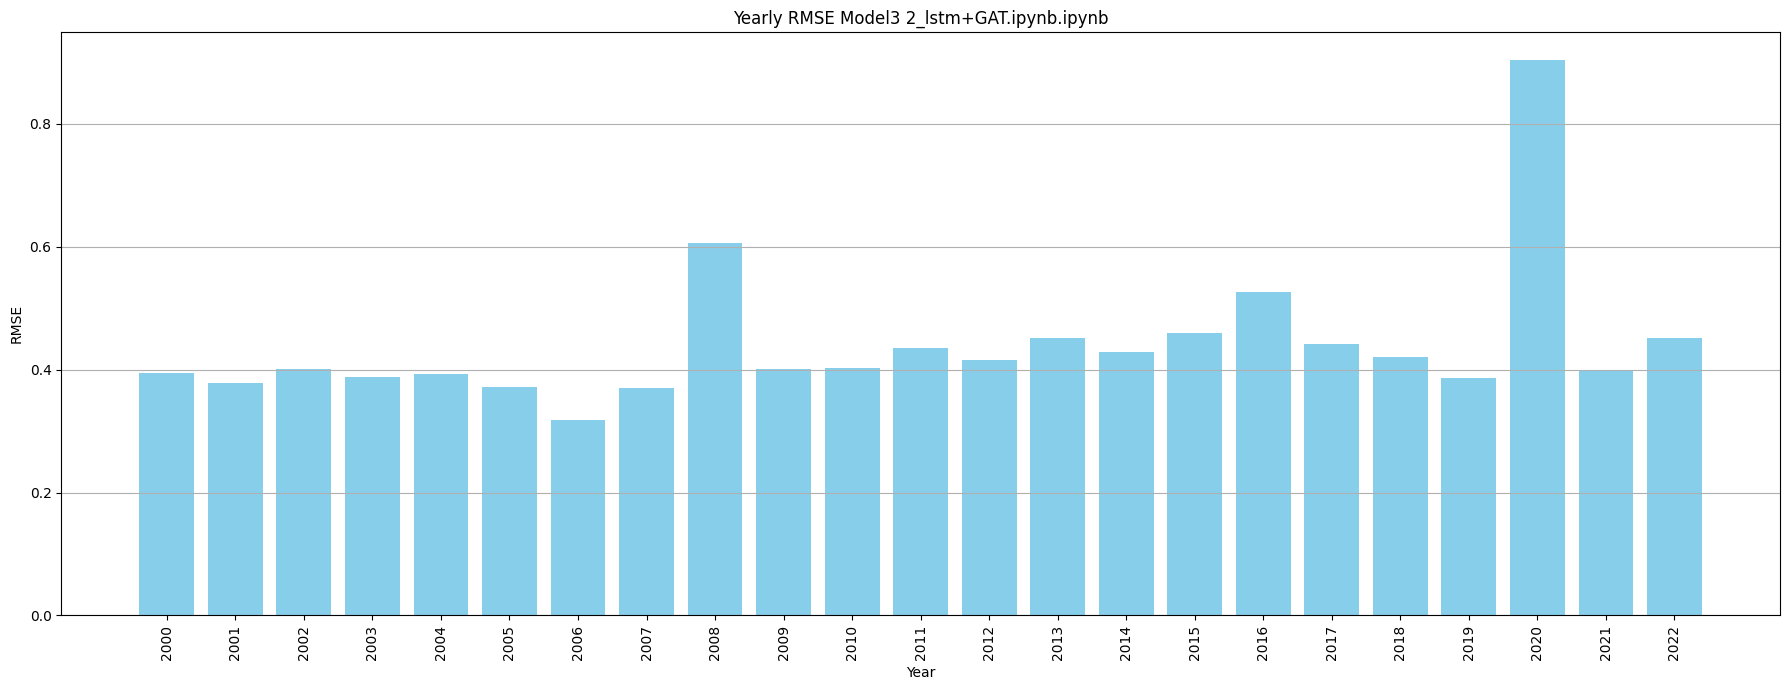

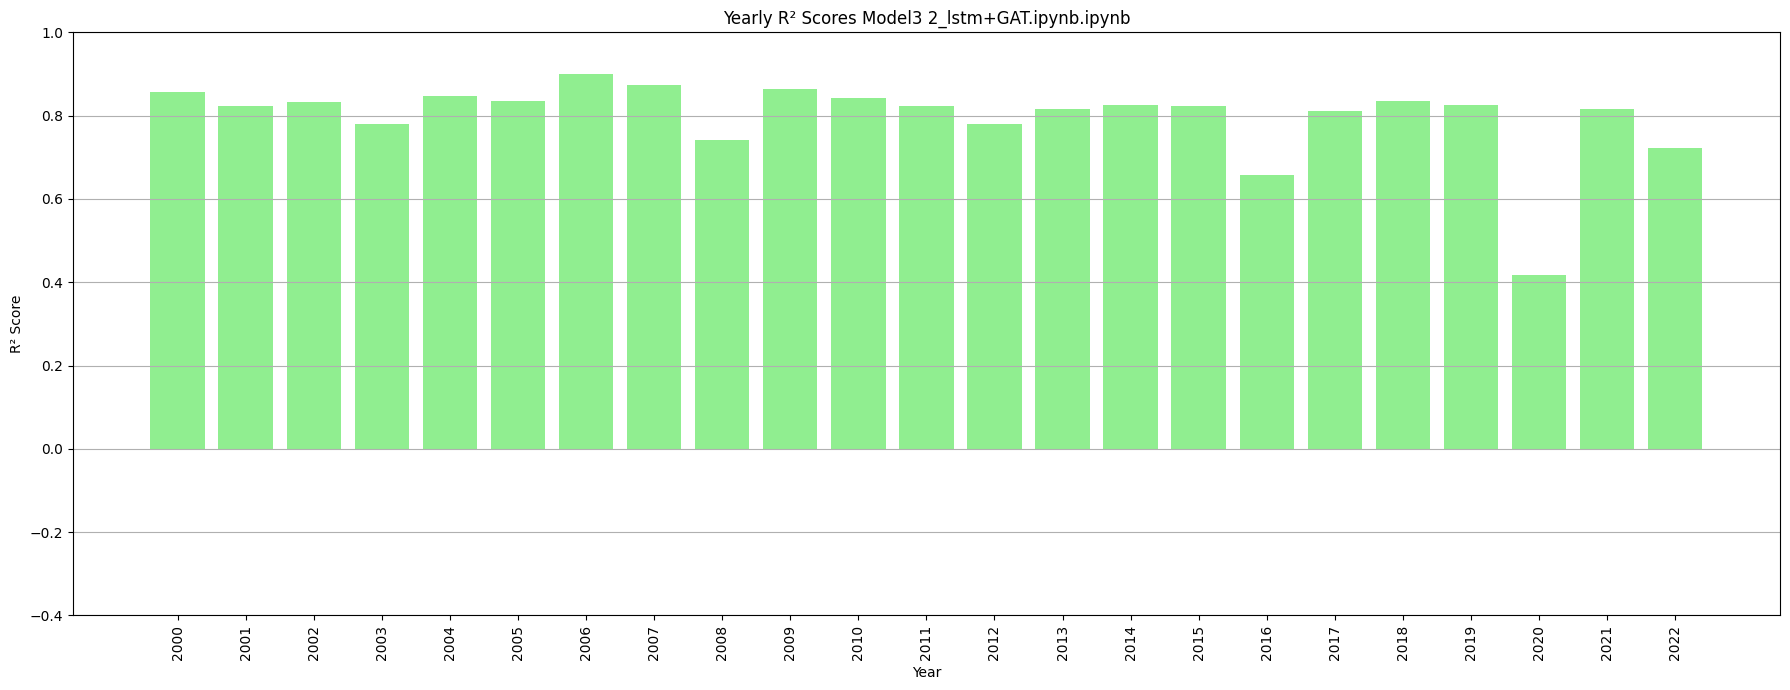

In [ ]:
# Load the results file
results_df = pd.read_csv('/content/gt_lstm_rice_yield_predictions.csv')

# Initialize dictionaries to store RMSE and R² for each year
yearly_rmse = {}
yearly_r2 = {}

# Group by year and calculate RMSE and R² for each year
for year, group in results_df.groupby('Year'):
    actual_yields = group['Actual_Yield'].values
    predicted_yields = group['Predicted_Yield'].values

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(actual_yields, predicted_yields))
    r2 = r2_score(actual_yields, predicted_yields)

    # Store the results in the dictionaries
    yearly_rmse[year] = rmse
    yearly_r2[year] = r2

# Convert the dictionaries to a DataFrame for easier viewing and visualization
yearly_metrics_df = pd.DataFrame({
    'Year': list(yearly_rmse.keys()),
    'RMSE': list(yearly_rmse.values()),
    'R2': list(yearly_r2.values())
})

# Save the yearly metrics to a CSV file
yearly_metrics_df.to_csv('/content/yearly_yield_metrics3.csv', index=False)

# Calculate and print the average yearly metrics separately
average_yearly_rmse = yearly_metrics_df['RMSE'].mean()
average_yearly_r2 = yearly_metrics_df['R2'].mean()

print("------------Yearly Metrics----------------")
print(yearly_metrics_df)
print("\n------------Average Yearly Metrics----------------")
print(f"Average yearly RMSE: {average_yearly_rmse:.4f}")
print(f"Average yearly R²: {average_yearly_r2:.4f}")

# Visualization of Yearly Metrics

# Yearly RMSE Plot
plt.figure(figsize=(18, 7))
plt.bar(yearly_metrics_df['Year'], yearly_metrics_df['RMSE'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('Yearly RMSE Model3 2_lstm+GAT.ipynb.ipynb')
plt.xticks(yearly_metrics_df['Year'], rotation=90)

plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Yearly R² Plot
plt.figure(figsize=(18, 7))
plt.bar(yearly_metrics_df['Year'], yearly_metrics_df['R2'], color='lightgreen')
plt.xlabel('Year')
plt.ylabel('R² Score')
plt.title('Yearly R² Scores Model3 2_lstm+GAT.ipynb.ipynb')
plt.xticks(yearly_metrics_df['Year'], rotation=90)
plt.ylim(-0.4, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


```
------------Average Yearly Metrics----------------
Average yearly RMSE: 0.4391
Average yearly R²: 0.7986


stage 3
------------Average Yearly Metrics----------------
Average yearly RMSE: 0.4463
Average yearly R²: 0.7934

```

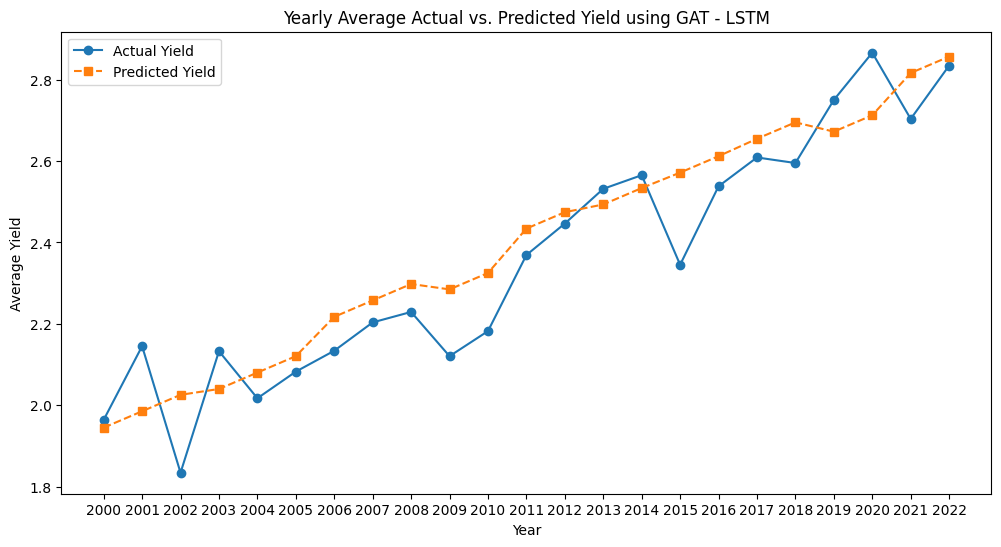

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Load the results file
results_df = pd.read_csv('/content/gt_lstm_rice_yield_predictions.csv')

# Group by year and compute mean actual and predicted yields
yearly_avg_yield = results_df.groupby('Year')[['Actual_Yield', 'Predicted_Yield']].mean().reset_index()

# Plot the actual vs predicted yield over the years
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_yield['Year'], yearly_avg_yield['Actual_Yield'], marker='o', linestyle='-', label='Actual Yield')
plt.plot(yearly_avg_yield['Year'], yearly_avg_yield['Predicted_Yield'], marker='s', linestyle='--', label='Predicted Yield')

# Formatting the plot
plt.xlabel('Year')
plt.ylabel('Average Yield')
plt.title('Yearly Average Actual vs. Predicted Yield using GAT - LSTM')
plt.legend()
plt.xticks(yearly_avg_yield['Year'])  # Ensure all years appear as ticks
plt.show()


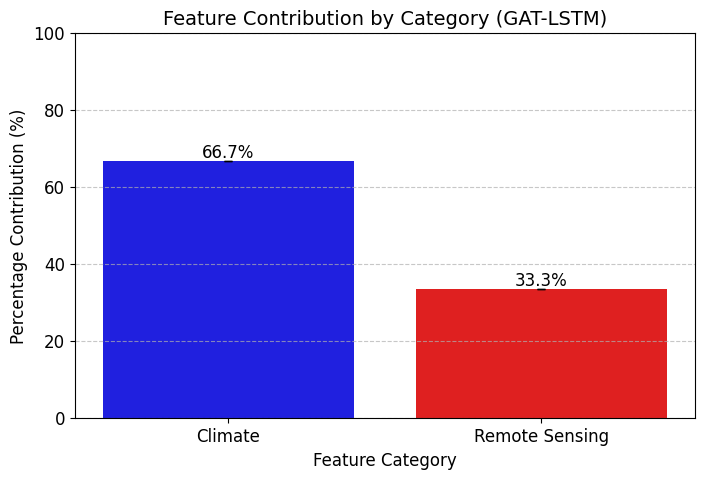


Feature importance results saved to /content/gat_lstm_feature_importance.csv
  Feature Category  Average Importance       Std_Dev  Percentage Contribution
0          Climate       -3.447298e-09  6.894596e-09                66.666667
1   Remote Sensing       -1.723649e-09  5.170947e-09                33.333333


In [ ]:
# Use the final trained model from the last fold for permutation importance
final_model = model  # Assume this is the best model from the last fold
final_model.eval()

# Prepare full dataset for permutation importance
X_climate = climate_data_tensor.to(device)  # Shape: [num_years, num_districts, 4, 9]
X_rs = rs_data_tensor.to(device)           # Shape: [num_years, num_districts, 4, 4]
X_centroid = centroid_tensor.to(device)    # Shape: [num_districts, 2]
y_actual = actual_yields_tensor.to(device) # Shape: [num_districts, num_years]
y_trends = trends_tensor.to(device)        # Shape: [num_districts, num_years]

# Function to compute predictions for the full dataset
def predict_full_dataset(model, climate_data, rs_data, centroid_data):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for year_idx in range(num_years):
            climate_batch = climate_data[year_idx].to(device)
            rs_batch = rs_data[year_idx].to(device)
            centroid_batch = centroid_data.to(device)
            trend_batch = y_trends[:, year_idx:year_idx+1].to(device)
            pred = model(climate_batch, rs_batch, centroid_batch)
            predicted_yields = pred + trend_batch
            all_preds.append(predicted_yields.cpu().numpy())
    return np.concatenate(all_preds, axis=1)  # Shape: [num_districts, num_years]

# Baseline predictions
baseline_preds = predict_full_dataset(final_model, X_climate, X_rs, X_centroid)
baseline_rmse = np.sqrt(mean_squared_error(y_actual.cpu().numpy().flatten(), baseline_preds.flatten()))

# Define feature categories (excluding centroid features)
climate_features = 9  # Number of features per time step in climate data
rs_features = 4      # Number of features per time step in RS data

# Permutation importance function (only for climate and RS features)
def compute_permutation_importance(model, climate_data, rs_data, centroid_data, y_true, n_repeats=10):
    importances = {'Climate': [], 'Remote Sensing': []}
    original_preds = predict_full_dataset(model, climate_data, rs_data, centroid_data)

    for _ in range(n_repeats):
        # Permute Climate features
        perm_climate = climate_data.clone()
        for t in range(perm_climate.shape[2]):  # Permute across time steps
            for f in range(perm_climate.shape[3]):  # Permute across features
                perm_climate[:, :, t, f] = perm_climate[:, torch.randperm(num_districts), t, f]
        perm_preds_climate = predict_full_dataset(model, perm_climate, rs_data, centroid_data)
        rmse_climate = np.sqrt(mean_squared_error(y_true.cpu().numpy().flatten(), perm_preds_climate.flatten()))
        importances['Climate'].append(baseline_rmse - rmse_climate)

        # Permute Remote Sensing features
        perm_rs = rs_data.clone()
        for t in range(perm_rs.shape[2]):  # Permute across time steps
            for f in range(perm_rs.shape[3]):  # Permute across features
                perm_rs[:, :, t, f] = perm_rs[:, torch.randperm(num_districts), t, f]
        perm_preds_rs = predict_full_dataset(model, climate_data, perm_rs, centroid_data)
        rmse_rs = np.sqrt(mean_squared_error(y_true.cpu().numpy().flatten(), perm_preds_rs.flatten()))
        importances['Remote Sensing'].append(baseline_rmse - rmse_rs)

    return {k: (np.mean(v), np.std(v)) for k, v in importances.items()}

# Compute permutation importance
importances = compute_permutation_importance(final_model, X_climate, X_rs, X_centroid, y_actual)

# Prepare data for visualization
category_importance_df = pd.DataFrame({
    'Feature Category': list(importances.keys()),
    'Average Importance': [imp[0] for imp in importances.values()],
    'Std_Dev': [imp[1] for imp in importances.values()]
})

# Calculate percentage contribution
total_importance = category_importance_df['Average Importance'].sum()
category_importance_df['Percentage Contribution'] = (category_importance_df['Average Importance'] / total_importance) * 100

# Plot Feature Contribution by Category
plt.figure(figsize=(8, 5))
colors = ['blue', 'red']  # Colors for Climate and Remote Sensing
ax = sns.barplot(
    data=category_importance_df,
    x="Feature Category",
    y="Percentage Contribution",
    hue="Feature Category",  # Use hue to assign colors
    palette=colors,
    dodge=False,  # Prevent bars from being split
    legend=False  # Disable legend since hue is used for coloring
)

# Compute standard error for error bars
std_error = category_importance_df['Std_Dev'] / np.sqrt(10)  # Standard error = Std_Dev / sqrt(n_repeats)

# Add error bars manually
for i, bar in enumerate(ax.patches):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    err = std_error.iloc[i]
    ax.errorbar(x, y, yerr=err, color='black', capsize=3, capthick=1, linewidth=1)

# Annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom",
        fontsize=12, color="black"
    )

# Set labels and grid
plt.title("Feature Contribution by Category (GAT-LSTM)", fontsize=14)
plt.ylabel("Percentage Contribution (%)", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Ensures y-axis goes up to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Save results to CSV
category_importance_df.to_csv('/content/gat_lstm_feature_importance.csv', index=False)
print("\nFeature importance results saved to /content/gat_lstm_feature_importance.csv")
print(category_importance_df)

```
Feature importance results saved to /content/gat_lstm_feature_importance.csv
  Feature Category  Average Importance       Std_Dev  Percentage Contribution
0          Climate       -3.447298e-09  6.894596e-09                66.666667
1   Remote Sensing       -1.723649e-09  5.170947e-09                33.333333

```